In [1]:
# 原配置的n_iter为150000
'运行sp500等数据需要修改 配置文件里的输入维度 数据读取路径 缺失数量k要小于数据行数 train文件里分割数据的batchsize 分割长度和采样率可能也要改'
%run train.py -c config/config_SSSDS4.json

'运行sp500等数据需要修改 配置文件里的输入维度 数据读取路径 缺失数量k要小于数据行数 train文件里分割数据的batchsize 分割长度和采样率可能也要改'

In [1]:
# %run inference.py -c config/config_SSSDS4.json

In [2]:
'使用SA模型需要修改配置 in_channels改为数据维度'
'train函数里要增加参数 batch_size_per_gpu 或在配置文件里去掉该参数'
'batch_size_per_gpu好像一直都没用到 可以删掉'
%run train.py -c config/config_SSSDSA.json

%run inference.py -c config/config_SSSDSA.json

'batch_size_per_gpu好像一直都没用到 可以删掉'

In [4]:
'diffwave模型速度较快 不需要参数 batch_size_per_gpu'
%run train.py -c config/config_DiffWave.json

'这个速度较快 不需要参数 batch_size_per_gpu'

In [3]:
%run inference.py -c config/config_DiffWave.json

In [1]:
import os
import argparse
import json
import numpy as np
import torch
import torch.nn as nn

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap                         # 注意版本对应 numba0.56.4到0.58.1 对应 numpy1.23.4

from utils.util import find_max_epoch, print_size, training_loss, calc_diffusion_hyperparams
from utils.util import get_mask_mnr, get_mask_bm, get_mask_rm

from imputers.DiffWaveImputer import DiffWaveImputer
from imputers.SSSDSAImputer import SSSDSAImputer
from imputers.SSSDS4Imputer import SSSDS4Imputer
# from imputers.CSDI import CSDIImputer  # csdi在当前方法里因为参数不一致不好用

import time

CUDA extension for cauchy multiplication not found. Install by going to extensions/cauchy/ and running `python setup.py install`. This should speed up end-to-end training by 10-50%
Falling back on slow Cauchy kernel. Install at least one of pykeops or the CUDA extension for efficiency.


In [4]:
parser = argparse.ArgumentParser()
# parser.add_argument('-c', '--config', type=str, default='./config/config_SSSDS4.json', help='JSON file for configuration')
parser.add_argument('-c', '--config', type=str, default='./config/config_SSSDS4-sp500.json')  # 用sp500数据集

# parser.add_argument('-c', '--config', type=str, default='./config/config_DiffWave-sp500.json') # 用diffwave处理sp500数据集 效果会比sssd差一点
                                                                                                 # loss下降没那么快 最低值也没那么低
                                                                                                                                   

args = parser.parse_args(args=[])
print(args)

with open(args.config) as f:
    data = f.read()

config = json.loads(data)
print(config)

Namespace(config='./config/config_SSSDS4-sp500.json')
{'diffusion_config': {'T': 200, 'beta_0': 0.0001, 'beta_T': 0.02}, 'wavenet_config': {'in_channels': 6, 'out_channels': 6, 'num_res_layers': 36, 'res_channels': 128, 'skip_channels': 128, 'diffusion_step_embed_dim_in': 128, 'diffusion_step_embed_dim_mid': 512, 'diffusion_step_embed_dim_out': 512, 's4_lmax': 100, 's4_d_state': 64, 's4_dropout': 0.0, 's4_bidirectional': 1, 's4_layernorm': 1}, 'train_config': {'output_directory': './results/sp500/90', 'ckpt_iter': 'max', 'iters_per_ckpt': 500, 'iters_per_logging': 500, 'n_iters': 1000, 'learning_rate': 0.0002, 'only_generate_missing': 1, 'use_model': 2, 'masking': 'rm', 'missing_k': 20}, 'trainset_config': {'train_data_path': './datasets/sp500.npy', 'test_data_path': './datasets/sp500.npy', 'segment_length': 100, 'sampling_rate': 100}, 'gen_config': {'output_directory': './results/sp500/90', 'ckpt_path': './results/sp500/90/'}}


In [5]:
train_config = config["train_config"]  # training parameters

global trainset_config
trainset_config = config["trainset_config"]  # to load trainset

global diffusion_config
diffusion_config = config["diffusion_config"]  # basic hyperparameters

global diffusion_hyperparams
diffusion_hyperparams = calc_diffusion_hyperparams(
                      **diffusion_config)  # 具体的beta alpha值   dictionary of all diffusion hyperparameters

global model_config

if train_config['use_model'] == 0:
    model_config = config['wavenet_config']
elif train_config['use_model'] == 1:
    model_config = config['sashimi_config']
elif train_config['use_model'] == 2:
    model_config = config['wavenet_config']
    
    
# print(diffusion_hyperparams)
print(train_config)
print(model_config)

'修改配置 可以再配置文件里修改 也可以直接修改'
model_config['in_channels']=6   
model_config['out_channels']=6   
model_config['num_res_layers']=18            # 对于sp500 残差层的数量会和损失下降的平滑度有关 36比18平滑 但是也不一定 可能看随机性
# model_config['res_channels']=256             # 中间维度从128变为256后 收敛速度好像快了一些  但最终的损失值还是差不多
# model_config['skip_channels']=256 

print(model_config)

{'output_directory': './results/sp500/90', 'ckpt_iter': 'max', 'iters_per_ckpt': 500, 'iters_per_logging': 500, 'n_iters': 1000, 'learning_rate': 0.0002, 'only_generate_missing': 1, 'use_model': 2, 'masking': 'rm', 'missing_k': 20}
{'in_channels': 6, 'out_channels': 6, 'num_res_layers': 36, 'res_channels': 128, 'skip_channels': 128, 'diffusion_step_embed_dim_in': 128, 'diffusion_step_embed_dim_mid': 512, 'diffusion_step_embed_dim_out': 512, 's4_lmax': 100, 's4_d_state': 64, 's4_dropout': 0.0, 's4_bidirectional': 1, 's4_layernorm': 1}
{'in_channels': 6, 'out_channels': 6, 'num_res_layers': 18, 'res_channels': 128, 'skip_channels': 128, 'diffusion_step_embed_dim_in': 128, 'diffusion_step_embed_dim_mid': 512, 'diffusion_step_embed_dim_out': 512, 's4_lmax': 100, 's4_d_state': 64, 's4_dropout': 0.0, 's4_bidirectional': 1, 's4_layernorm': 1}


In [6]:
output_directory = './results/mujoco/90'
ckpt_iter = 'max'
n_iters = 10000
iters_per_ckpt = 100
iters_per_logging = 100
# batch_size_per_gpu         # SA模型需要 S4和DiffWave不需要        
learning_rate = 0.0002

use_model = 2

only_generate_missing = 1       # 加噪方式 全局还是局部加噪
masking = 'rm'               # 缺失值产生方式
missing_k = 20

In [7]:
local_path = "T{}_beta0{}_betaT{}".format(diffusion_config["T"],
                                              diffusion_config["beta_0"],
                                              diffusion_config["beta_T"])
print(local_path)


output_directory = os.path.join(output_directory, local_path)
if not os.path.isdir(output_directory):
    os.makedirs(output_directory)
    os.chmod(output_directory, 0o775)               # 给文件夹设置权限
print("output directory", output_directory, flush=True)

# map diffusion hyperparameters to gpu
for key in diffusion_hyperparams:
    if key != "T":
        diffusion_hyperparams[key] = diffusion_hyperparams[key].cuda()
        
        
# predefine model
if use_model == 0:
    net = DiffWaveImputer(**model_config).cuda()
elif use_model == 1:
    net = SSSDSAImputer(**model_config).cuda()
elif use_model == 2:
    net = SSSDS4Imputer(**model_config).cuda()    # 使用这个模型
else:
    print('Model chosen not available.')
    

print_size(net)

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

T200_beta00.0001_betaT0.02
output directory ./results/mujoco/90\T200_beta00.0001_betaT0.02
SSSDS4Imputer Parameters: 7.547142M


In [8]:
'数据读取'
training_data = np.load(trainset_config['train_data_path'])
np.random.shuffle(training_data)
print(training_data.shape)
# print(training_data[0])

(5775, 30, 6)


In [9]:
# training_data = np.split(training_data, 160, 0)    # 把原数据集进行分割 注意要好整除
training_data = np.split(training_data, 55, 0)      # 对于sp500 每55次是一个epoch
print(len(training_data), training_data[0].shape)

training_data = np.array(training_data)
# print(training_data.shape)

training_data = torch.from_numpy(training_data).float().cuda()
print(training_data.shape)

# for batch in training_data:
#     print(batch.shape)

55 (105, 30, 6)
torch.Size([55, 105, 30, 6])


In [14]:
'掩码产生过程和训练'
'-----这里每个batch里 每个数据的掩码都一样 不同batch里数据的掩码不一样-----'
'这里缺失率是固定的0.2  不同的缺失率要另外训练'
'无监督任务的话缺失掩码应该没有用'
missing_k = 20    # 注意缺失值产生的方式 这个值不是缺失率 而是缺失的行数 所以该值要小于数据的时间步的步数
                  # 由于有100行 所以缺失率为0.2 所以训练时缺失率是固定的 不同的缺失率要另外训练
iters = 0

loss_list=[]


n_iters = 10

while iters < n_iters + 1:

    start_time = time.time()
    
    for batch in training_data:      # 这里没有用dataloader 对于sp500 每55次是一个epoch
        
#         print(batch.shape)                                   # [105, 30, 6]  
#         print(batch[0].shape)                                # [30, 6]
    

        transposed_mask = get_mask_rm(batch[0], missing_k)     # 1为保留 0为缺失 这里是一个方块数据对应的掩码   一批数据里每个样本对应的掩码都一样
#         print(transposed_mask.shape)                         # [100, 14]  无监督合成任务该掩码应该没有用到
#         print(transposed_mask)

        mask = transposed_mask.permute(1, 0)    # 行列互换 [14, 100]  这么做应该是为了方便用transformer或s4处理 这两者默认应该是横向处理的
#         print(mask.shape)
#         print(mask)

        mask = mask.repeat(batch.size()[0], 1, 1).float().cuda()  # [50, 14, 100] 掩码重复batch次 意味着每个batch里的样本对应的掩码都一样
#         print(mask.shape)
#         print(mask)

        loss_mask = ~mask.bool()        # 用于计算损失的掩码 掩码里的0变成1 1变成0 再换成true和false  属于用true false表示的逆掩码 
#         print(loss_mask.shape)        # 这里true为缺失 false为保留
#         print(loss_mask)

        batch = batch.permute(0, 2, 1)   # 数据也和掩码一样 行列互换
#         print(batch.shape)


        optimizer.zero_grad()

        X = batch, batch, mask, loss_mask    # 变成了元祖形式 可以像字典一样访问   
#         print(X[2])                          # 两个原数据batch一样 一个用于加噪 一个用于和掩码相乘 产生已有值做监督 其实用一个batch就行


#         这里基本上是一个ddpm的加噪和预测噪声的过程 多了监督条件 缺失掩码
        loss = training_loss(net, nn.MSELoss(), X, diffusion_hyperparams,
                             only_generate_missing=only_generate_missing)

        loss.backward()
        optimizer.step()
        
        
        if iters % iters_per_logging == 0:
                print("iteration: {} \tloss: {}".format(iters, loss.item()))
                
#         if iters > 0 and iters % iters_per_ckpt == 0:
#                 checkpoint_name = '{}.pkl'.format(iters)
#                 torch.save({'model_state_dict': net.state_dict(),
#                             'optimizer_state_dict': optimizer.state_dict()},
#                            os.path.join(output_directory, checkpoint_name))
    
        loss_list.append(loss.item())
        
        iters += 1
        
#     end_time = time.time()
#     execution_time = end_time - start_time   # 数据集遍历完一次的时间  sp500差不多9.5s
#     print(execution_time)     

iteration: 0 	loss: 0.09806988388299942


55


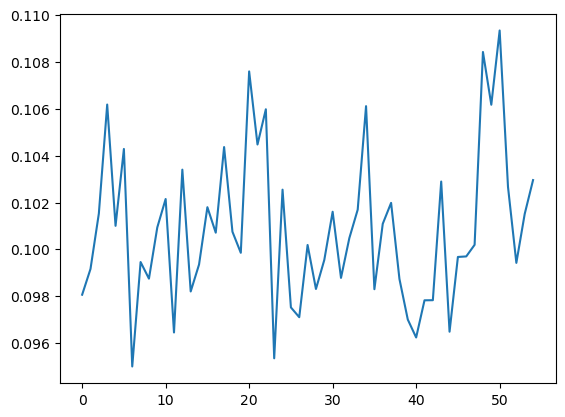

In [15]:
print(len(loss_list))

plt.figure()
plt.plot(loss_list)


In [10]:
'保存和导入模型参数'
# torch.save( net.state_dict(),"./sp500_S4_iter_10000.pth" )

net = SSSDS4Imputer(**model_config).cuda()
net.load_state_dict(torch.load( "./sp500_S4_iter_10000.pth"))

# net.eval()

<All keys matched successfully>

In [11]:
'------无监督合成实验 采样-------'

def std_normal(size):
    """
    Generate the standard Gaussian variable of a certain size
    """
    return torch.normal(0, 1, size=size).cuda()


size=(5775,6,30)

_dh = diffusion_hyperparams
T, Alpha, Alpha_bar, Sigma = _dh["T"], _dh["Alpha"], _dh["Alpha_bar"], _dh["Sigma"]

assert len(Alpha) == T
assert len(Alpha_bar) == T
assert len(Sigma) == T
assert len(size) == 3

# print(T, Alpha)

x = std_normal(size)      # xT  shape为 [采样数, 14 ,100]
cond = 1
mask = 1


In [12]:
with torch.no_grad(): 
        
        for t in range(T - 1, -1, -1):        # 开始减噪  199 到0
                
            diffusion_steps = (t * torch.ones((size[0], 1))).cuda()  # use the corresponding reverse step
                       
            epsilon_theta = net((x, cond, mask, diffusion_steps,))  # predict \epsilon according to \epsilon_\theta
            
            # 计算xt-1的均值 update x_{t-1} to \mu_\theta(x_t)
            x = (x - (1 - Alpha[t]) / torch.sqrt(1 - Alpha_bar[t]) * epsilon_theta) / torch.sqrt(Alpha[t])
            
            if t > 0:
                x = x + Sigma[t] * std_normal(size)  # x0不加标准差  add the variance term to x_{t-1}
                              

In [13]:
print(x.shape)

result = x.permute(0, 2, 1)
print(result.shape)
# print(result)

torch.Size([5775, 6, 30])
torch.Size([5775, 30, 6])


(5775, 180)
(5775, 2)


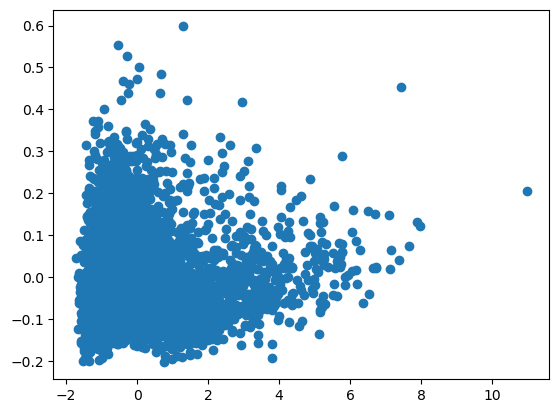

In [14]:
result = result.cpu().numpy().reshape(5775,-1)
print(result.shape)


pca = PCA(2)
pca_res1 = pca.fit_transform(result)
print(pca_res1.shape)

plt.figure()
plt.scatter(pca_res1[:,0],pca_res1[:,1])

(5775, 30, 6)
(5775, 180)
(5775, 2)


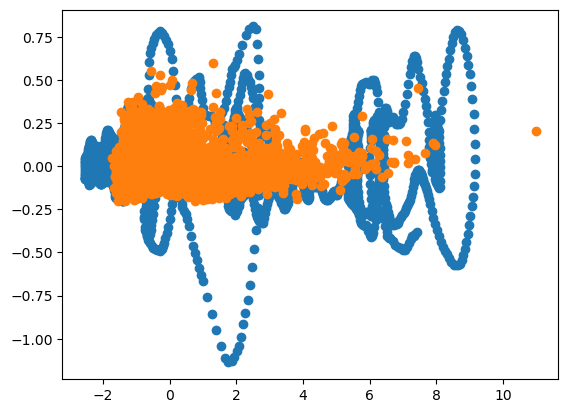

In [15]:
training_data = np.load(trainset_config['train_data_path'])
np.random.shuffle(training_data)
print(training_data.shape)
# print(training_data[0])

# ori_data = training_data.reshape(-1,6)
ori_data = training_data.reshape(5775,-1)
print(ori_data.shape)
# print(ori_data[0:3])


pca = PCA(2)
pca_res = pca.fit_transform(ori_data)
print(pca_res.shape)

plt.figure()
plt.scatter(pca_res[:,0],pca_res[:,1])
plt.scatter(pca_res1[:,0],pca_res1[:,1])

In [16]:
concat_data = np.concatenate((result, ori_data), axis=0)
print(concat_data.shape)

tsne = TSNE(n_components=2, verbose=1, perplexity=40,random_state=20,n_iter=500)    # 固定随机种子random_state=20
tsne_results = tsne.fit_transform(concat_data) 

(11550, 180)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 11550 samples in 0.002s...


C:\Users\PC123\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 11550 samples in 0.371s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11550
[t-SNE] Computed conditional probabilities for sample 2000 / 11550
[t-SNE] Computed conditional probabilities for sample 3000 / 11550
[t-SNE] Computed conditional probabilities for sample 4000 / 11550
[t-SNE] Computed conditional probabilities for sample 5000 / 11550
[t-SNE] Computed conditional probabilities for sample 6000 / 11550
[t-SNE] Computed conditional probabilities for sample 7000 / 11550
[t-SNE] Computed conditional probabilities for sample 8000 / 11550
[t-SNE] Computed conditional probabilities for sample 9000 / 11550
[t-SNE] Computed conditional probabilities for sample 10000 / 11550
[t-SNE] Computed conditional probabilities for sample 11000 / 11550
[t-SNE] Computed conditional probabilities for sample 11550 / 11550
[t-SNE] Mean sigma: 0.064189
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.971710
[t-SNE] KL divergence after 

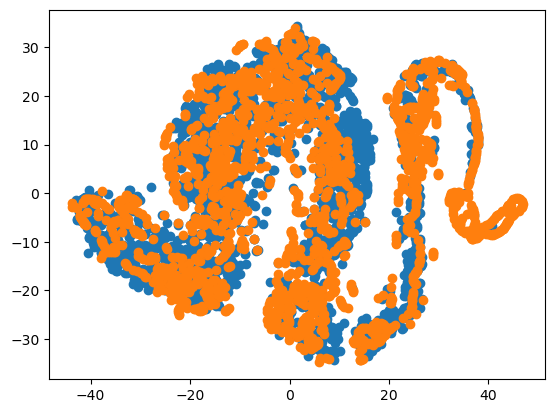

In [19]:
plt.figure()
plt.scatter(tsne_results[:2000,0],tsne_results[:2000,1])
plt.scatter(tsne_results[5775:7775,0],tsne_results[5775:7775,1])
# plt.savefig('tsne',dpi=500)


C:\Users\PC123\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\PC123\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(11550, 2)


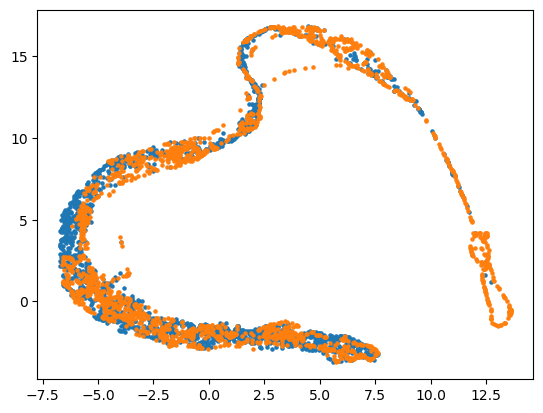

In [20]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(concat_data)
print(embedding.shape)

# plt.figure()
# plt.scatter(embedding[:, 0], embedding[:, 1],  cmap='Spectral', s=5)

plt.figure()
plt.scatter(embedding[:2000, 0], embedding[:2000, 1],  cmap='Spectral', s=5)
plt.scatter(embedding[5775:7775, 0], embedding[5775:7775, 1],  cmap='Spectral', s=5)

In [21]:
'下面用timegan里的先取均值 再拼接 再做tsne的方法 比上面的多了取均值的过程'
# x = current_sample.cpu().numpy()
# print(x.shape,current_sample.shape)

ori_data = training_data
generated_data = x.permute(0, 2, 1).cpu().numpy()
print(ori_data.shape, generated_data.shape)

# x = torch.randn(4000,30,6).numpy()    # 用随机数试一下  不能重合 说明模型生成的数据和原数据有相似性


anal_sample_no = min([4000, len(ori_data)])       # 取2000
idx = np.random.permutation(len(ori_data))[:anal_sample_no]


ori_data = np.asarray(ori_data)
generated_data = np.asarray(generated_data)

ori_data = ori_data[idx]
generated_data = generated_data[idx]


for i in range(4000):
    if i == 0:
        prep_data = np.reshape(np.mean(ori_data[0, :, :], 1), [1, 30])
        
    else:
        prep_data = np.concatenate(
            (prep_data, np.reshape(np.mean(ori_data[i, :, :], 1), [1, 30]))
        )

print(prep_data.shape)


# x1= data1.cpu().numpy()
# print(x1.shape,data1.shape)

for i in range(4000):
    if i == 0:
        prep_data1 = np.reshape(np.mean(generated_data[0, :, :], 1), [1, 30])
        
    else:
        prep_data1 = np.concatenate(
            (prep_data1, np.reshape(np.mean(generated_data[i, :, :], 1), [1, 30]))
        )
print(prep_data1.shape)

'上部分为原样本 下部分为生成样本'
x2 = np.concatenate((prep_data, prep_data1), axis=0)
print(x2.shape)

(5775, 30, 6) (5775, 30, 6)
(4000, 30)
(4000, 30)
(8000, 30)


(1000,)
(1000,)


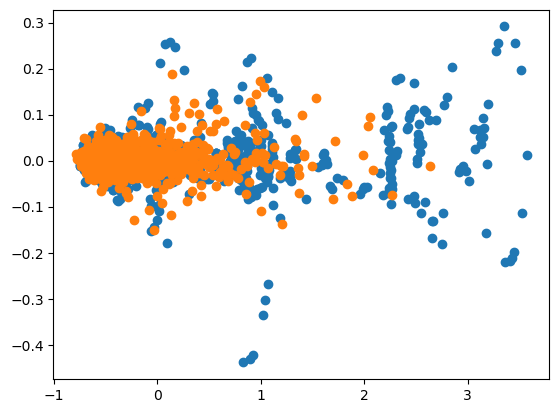

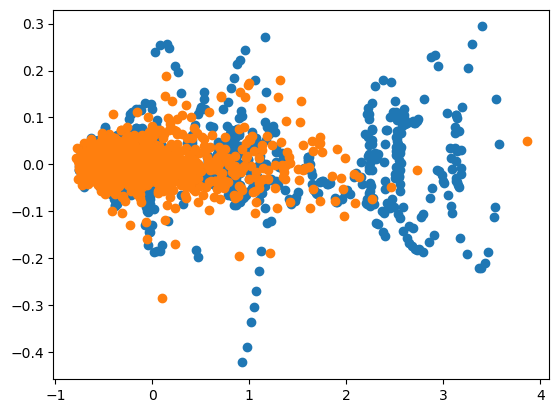

In [23]:
pca = PCA(2)
pca_res = pca.fit_transform(x2)

# 使用随机索引 减少点数
indexe1=np.random.permutation(4000)[:1000]
print(indexe1.shape)

indexe2=np.random.permutation( range(4000,8000) )[:1000]
print(indexe2.shape)


plt.figure()
plt.scatter(pca_res[indexe1,0],pca_res[indexe1,1])
plt.scatter(pca_res[indexe2,0],pca_res[indexe2,1])

plt.figure()
plt.scatter(pca_res[:2000,0],pca_res[:2000,1])
plt.scatter(pca_res[4000:6000,0],pca_res[4000:6000,1])

In [24]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40,random_state=20,n_iter=500)    # 固定随机种子random_state=20
tsne_results = tsne.fit_transform(x2)           # 拼接后一起训练
print(tsne_results.shape)

C:\Users\PC123\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.001s...
[t-SNE] Computed neighbors for 8000 samples in 0.190s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.014708
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.393150
[t-SNE] KL divergence after 500 iterations: 1.270604
(8000, 2)


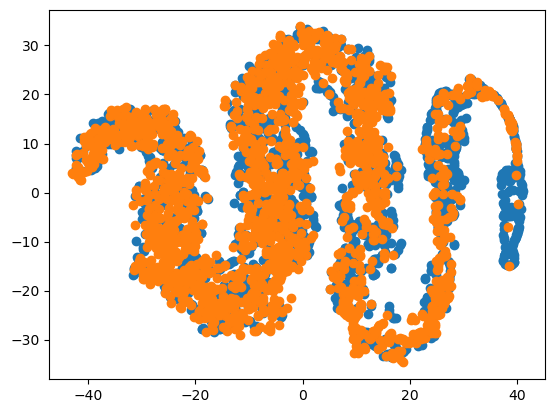

In [25]:
plt.figure()
plt.scatter(tsne_results[:2000,0],tsne_results[:2000,1])
plt.scatter(tsne_results[4000:6000,0],tsne_results[4000:6000,1])
# plt.savefig('tsne',dpi=500)

In [26]:
'------ae重构实验----------'

import matplotlib.pyplot as plt

'one-shot 单个样本'
training_data = np.load(trainset_config['train_data_path'])
training_data = np.array(training_data)
x = torch.from_numpy(training_data).float().cuda()
x = x[30:31].permute(0,2,1)
print(x.shape)


torch.Size([1, 6, 30])


In [27]:
'获取x0的逆推码xT'
'注意里面噪声模块和下面的公式里有相同的参数x 就是同一个结果在不停迭代改变'
'注意torch.ones后的参数和样本数一致'
'注意ddim和 ddpm采样时 t可以不用取端点 因为公式里有t-1  用ddim inversion也一样 不用取端点 因为有t+1'

inverted_x = x

with torch.no_grad():        
    for t in range(0, T-1, 1):                       # 0到198 不取最后一步 因为有t+1     
#         diffusion_steps = (t * torch.ones((size[0], 1))).cuda()  # use the corresponding reverse step       
        diffusion_steps = (t * torch.ones((1, 1))).cuda()          # 注意要把size[0]换成1 如果有2个样本 就是2
        epsilon_theta = net((inverted_x, cond, mask, diffusion_steps))  # predict \epsilon according to \epsilon_\theta
        inverted_x = ( torch.sqrt(Alpha_bar[t+1]) * (inverted_x - torch.sqrt(1-Alpha_bar[t]) * epsilon_theta) ) / torch.sqrt(Alpha_bar[t]) + \
                                                                                                     torch.sqrt(1-Alpha_bar[t+1])* epsilon_theta
  

In [28]:
print(inverted_x.shape)
criterion = nn.MSELoss(reduction="mean")
RMSE = torch.sqrt(criterion(x, inverted_x))
print(RMSE)


torch.Size([1, 6, 30])
tensor(0.5631, device='cuda:0')


In [29]:
'从逆推码xT通过ddim恢复原x0'

recove = inverted_x

with torch.no_grad():        
    for t in range(T-1, 0, -1):                       #  199到1  因为有t-1     
#         diffusion_steps = (t * torch.ones((size[0], 1))).cuda()  # use the corresponding reverse step       
        diffusion_steps = (t * torch.ones((1, 1))).cuda()          # 注意要把size[0]换成1 如果有2个样本 就是2
        epsilon_theta = net((recove, cond, mask, diffusion_steps))  # predict \epsilon according to \epsilon_\theta
        recove = ( torch.sqrt(Alpha_bar[t-1]) * (recove - torch.sqrt(1-Alpha_bar[t]) * epsilon_theta) ) / torch.sqrt(Alpha_bar[t]) + \
                                                                                              torch.sqrt(1-Alpha_bar[t-1])* epsilon_theta

In [30]:
print(x.shape)
print(recove.shape)

criterion = nn.MSELoss(reduction="mean")
RMSE = torch.sqrt(criterion(x, recove))
print(RMSE)

torch.Size([1, 6, 30])
torch.Size([1, 6, 30])
tensor(0.0026, device='cuda:0')


(1, 30, 6)
(30,)


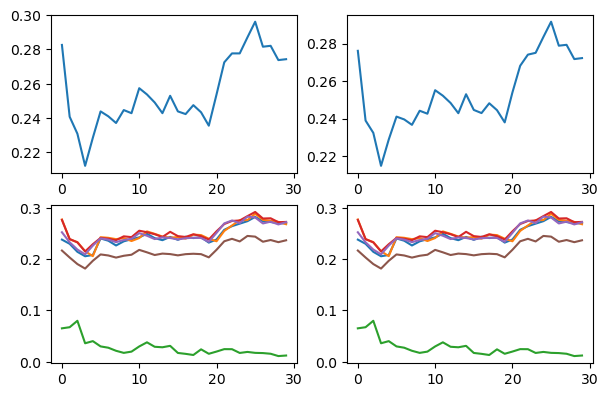

In [31]:
x_plot = x.permute(0, 2, 1).cpu().numpy()
print(x_plot.shape)
print(x_plot[0][:,1].shape)

recove_plot = recove.permute(0, 2, 1).cpu().numpy()

inverted_plot = inverted_x.permute(0, 2, 1).cpu().numpy()


fig = plt.figure(figsize=(7,7))

plt.subplot(3,2,1)
plt.plot(x_plot[0][:,3])       # 第二列属性

plt.subplot(3,2,2)
plt.plot(recove_plot[0][:,3])      


plt.subplot(3,2,3)
plt.plot(recove_plot[0][:,:])  

plt.subplot(3,2,4)
plt.plot(recove_plot[0][:,:]) 


# plt.subplot(3,2,5)
# plt.plot(inverted_plot[0][:,:]) 

In [32]:
'-----样本进行缺失后brits补全-----'
'这个样本照理来说不应该在原数据集里'
from torch.autograd import Variable
from pypots.data import load_specific_dataset, mcar, masked_fill
from pypots.imputation import MRNN,BRITS,SAITS
from pypots.utils.metrics import cal_mse,cal_rmse,cal_mae
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [33]:
'----使用原数据集-----'

training_data = np.load(trainset_config['train_data_path'])
training_data = np.array(training_data)
x = torch.from_numpy(training_data).float().cuda()
# x = x[30:31].permute(0,2,1)      # saits训练不用换维度
x = x[30:31]
print(x.shape)
print(x[0][0])


np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)

'对数据进行缺失 '
'X_ori是原数据  X_missed是缺失后的数据 '
'missing_mask是缺失掩码 0为缺失 1为保留    indicating_mask和missing_mask相反 显示哪些位置缺失 缺失了显示1 '
X_ori, X_missed, missing_mask, indicating_mask = mcar(x, 0.3, np.nan)   # 可以用0或np.nan来填补缺失位置
print(X_ori[0][0])
print(X_missed[0][0])
print(missing_mask[0][0])
print(indicating_mask[0][0])

torch.Size([1, 30, 6])
tensor([0.2398, 0.2836, 0.0719, 0.2826, 0.2550, 0.2185], device='cuda:0')
tensor([0.2398, 0.2836, 0.0719, 0.2826, 0.2550, 0.2185], device='cuda:0')
tensor([0.2398, 0.2836, 0.0719, 0.2826,    nan,    nan], device='cuda:0')
tensor([1., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 1., 1.], device='cuda:0')


In [34]:
'使用其他数据集  上下两个数据用一个即可 zero-shot补全'

oneshot_data = np.loadtxt('AAL.csv',delimiter = ",")
norm_data = MinMaxScaler().fit_transform(oneshot_data)
x_oneshot = np.array(norm_data[10:40])
x_oneshot = torch.from_numpy(x_oneshot).float().cuda()
x_oneshot = x_oneshot.unsqueeze(dim=0)
print(x_oneshot.shape)

X_ori, X_missed, missing_mask, indicating_mask = mcar(x_oneshot, 0.3, np.nan)
print(X_ori[0][0])

torch.Size([1, 30, 6])
tensor([0.3361, 0.3359, 0.0015, 0.3310, 0.3304, 0.3304], device='cuda:0')


In [35]:
'用saits进行初步补全'

import gc
gc.collect()
torch.cuda.empty_cache()


rmse_list =[]
imputation_list = []

for i in range(1):             # 运行5次计算标准差
    

    saits = SAITS(n_steps=30, n_features=6, n_layers=2, d_model=128, d_inner=64, n_heads=4, d_k=64, d_v=64, dropout=0.1, batch_size=10, epochs=3000)
    
#     saits = BRITS(n_steps=30, n_features=6, rnn_hidden_size=64, batch_size=1, epochs=50)
#     saits = MRNN(n_steps=30, n_features=6, rnn_hidden_size=64, batch_size=1, epochs=100)
    
    dataset = {"X": X_missed}
    
    saits.fit(dataset)               # train the model. Here I use the whole dataset as the training set, because ground truth is not visible to the model.
    imputation = saits.impute(dataset)  # impute the originally-missing values and artificially-missing values
    imputation_list.append(imputation)
    
    imputation = torch.from_numpy(imputation).cuda()

    mae = cal_mae(imputation, X_ori, indicating_mask)    # 计算缺失位置的损失
    mse = cal_mse(imputation, X_ori, indicating_mask)
    rmse = cal_rmse(imputation, X_ori, indicating_mask)
    print(mae,mse, rmse)
    
    rmse_list.append(rmse)
    
'''
 np.random.seed(5)
 
 mr 0.3                                            mr 05                                         mr 0.7                                     

epoch     mae        mse        rmse               epoch     mae        mse        rmse              mae        mse        rmse      
2000      0.0069   8.6589e-05   0.0093(0.0090)                                                       0.0133      0.0003    0.0175
3000      0.0075   0.0001       0.0084 (0.0082)                                                               0.0123      0.0003    0.0160
5000      0.0053   5.6983e-05   0.0075(0.0074)                                                       0.00885     0.000152  0.01233
7000      0.0057   7.5455e-05   0.0087                                                               0.0104      0.0002    0.0138
10000     0.0066   7.9513e-05    0.0089                                                              0.0149      0.0006    0.0248

'''

2025-02-10 13:23:03 [INFO]: No given device, using default device: cuda
2025-02-10 13:23:03 [WARNING]: saving_path not given. Model files and tensorboard file will not be saved.
2025-02-10 13:23:03 [INFO]: Model initialized successfully with the number of trainable parameters: 597,780
2025-02-10 13:23:03 [INFO]: epoch 0: training loss 0.9377
2025-02-10 13:23:03 [INFO]: epoch 1: training loss 0.7148
2025-02-10 13:23:03 [INFO]: epoch 2: training loss 0.6952
2025-02-10 13:23:03 [INFO]: epoch 3: training loss 0.5225
2025-02-10 13:23:03 [INFO]: epoch 4: training loss 0.4947
2025-02-10 13:23:03 [INFO]: epoch 5: training loss 0.5003
2025-02-10 13:23:03 [INFO]: epoch 6: training loss 0.5176
2025-02-10 13:23:03 [INFO]: epoch 7: training loss 0.4229
2025-02-10 13:23:03 [INFO]: epoch 8: training loss 0.3402
2025-02-10 13:23:03 [INFO]: epoch 9: training loss 0.3678
2025-02-10 13:23:03 [INFO]: epoch 10: training loss 0.3553
2025-02-10 13:23:03 [INFO]: epoch 11: training loss 0.3981
2025-02-10 13:23

2025-02-10 13:23:05 [INFO]: epoch 134: training loss 0.0690
2025-02-10 13:23:05 [INFO]: epoch 135: training loss 0.0766
2025-02-10 13:23:05 [INFO]: epoch 136: training loss 0.0808
2025-02-10 13:23:05 [INFO]: epoch 137: training loss 0.0881
2025-02-10 13:23:05 [INFO]: epoch 138: training loss 0.1167
2025-02-10 13:23:05 [INFO]: epoch 139: training loss 0.0843
2025-02-10 13:23:05 [INFO]: epoch 140: training loss 0.0869
2025-02-10 13:23:05 [INFO]: epoch 141: training loss 0.0889
2025-02-10 13:23:05 [INFO]: epoch 142: training loss 0.0787
2025-02-10 13:23:05 [INFO]: epoch 143: training loss 0.0780
2025-02-10 13:23:05 [INFO]: epoch 144: training loss 0.0776
2025-02-10 13:23:05 [INFO]: epoch 145: training loss 0.0669
2025-02-10 13:23:05 [INFO]: epoch 146: training loss 0.0723
2025-02-10 13:23:05 [INFO]: epoch 147: training loss 0.0819
2025-02-10 13:23:05 [INFO]: epoch 148: training loss 0.0856
2025-02-10 13:23:05 [INFO]: epoch 149: training loss 0.0763
2025-02-10 13:23:05 [INFO]: epoch 150: t

2025-02-10 13:23:06 [INFO]: epoch 271: training loss 0.0572
2025-02-10 13:23:06 [INFO]: epoch 272: training loss 0.0491
2025-02-10 13:23:06 [INFO]: epoch 273: training loss 0.0493
2025-02-10 13:23:06 [INFO]: epoch 274: training loss 0.0668
2025-02-10 13:23:07 [INFO]: epoch 275: training loss 0.0568
2025-02-10 13:23:07 [INFO]: epoch 276: training loss 0.0493
2025-02-10 13:23:07 [INFO]: epoch 277: training loss 0.0566
2025-02-10 13:23:07 [INFO]: epoch 278: training loss 0.0575
2025-02-10 13:23:07 [INFO]: epoch 279: training loss 0.0542
2025-02-10 13:23:07 [INFO]: epoch 280: training loss 0.0570
2025-02-10 13:23:07 [INFO]: epoch 281: training loss 0.0547
2025-02-10 13:23:07 [INFO]: epoch 282: training loss 0.0494
2025-02-10 13:23:07 [INFO]: epoch 283: training loss 0.0573
2025-02-10 13:23:07 [INFO]: epoch 284: training loss 0.0634
2025-02-10 13:23:07 [INFO]: epoch 285: training loss 0.0525
2025-02-10 13:23:07 [INFO]: epoch 286: training loss 0.0605
2025-02-10 13:23:07 [INFO]: epoch 287: t

2025-02-10 13:23:08 [INFO]: epoch 408: training loss 0.0319
2025-02-10 13:23:08 [INFO]: epoch 409: training loss 0.0346
2025-02-10 13:23:08 [INFO]: epoch 410: training loss 0.0379
2025-02-10 13:23:08 [INFO]: epoch 411: training loss 0.0314
2025-02-10 13:23:08 [INFO]: epoch 412: training loss 0.0374
2025-02-10 13:23:08 [INFO]: epoch 413: training loss 0.0289
2025-02-10 13:23:08 [INFO]: epoch 414: training loss 0.0324
2025-02-10 13:23:08 [INFO]: epoch 415: training loss 0.0374
2025-02-10 13:23:08 [INFO]: epoch 416: training loss 0.0305
2025-02-10 13:23:08 [INFO]: epoch 417: training loss 0.0328
2025-02-10 13:23:08 [INFO]: epoch 418: training loss 0.0319
2025-02-10 13:23:08 [INFO]: epoch 419: training loss 0.0285
2025-02-10 13:23:08 [INFO]: epoch 420: training loss 0.0362
2025-02-10 13:23:08 [INFO]: epoch 421: training loss 0.0381
2025-02-10 13:23:08 [INFO]: epoch 422: training loss 0.0364
2025-02-10 13:23:08 [INFO]: epoch 423: training loss 0.0455
2025-02-10 13:23:08 [INFO]: epoch 424: t

2025-02-10 13:23:10 [INFO]: epoch 545: training loss 0.0278
2025-02-10 13:23:10 [INFO]: epoch 546: training loss 0.0313
2025-02-10 13:23:10 [INFO]: epoch 547: training loss 0.0345
2025-02-10 13:23:10 [INFO]: epoch 548: training loss 0.0296
2025-02-10 13:23:10 [INFO]: epoch 549: training loss 0.0334
2025-02-10 13:23:10 [INFO]: epoch 550: training loss 0.0325
2025-02-10 13:23:10 [INFO]: epoch 551: training loss 0.0320
2025-02-10 13:23:10 [INFO]: epoch 552: training loss 0.0336
2025-02-10 13:23:10 [INFO]: epoch 553: training loss 0.0273
2025-02-10 13:23:10 [INFO]: epoch 554: training loss 0.0259
2025-02-10 13:23:10 [INFO]: epoch 555: training loss 0.0283
2025-02-10 13:23:10 [INFO]: epoch 556: training loss 0.0318
2025-02-10 13:23:10 [INFO]: epoch 557: training loss 0.0268
2025-02-10 13:23:10 [INFO]: epoch 558: training loss 0.0316
2025-02-10 13:23:10 [INFO]: epoch 559: training loss 0.0307
2025-02-10 13:23:10 [INFO]: epoch 560: training loss 0.0290
2025-02-10 13:23:10 [INFO]: epoch 561: t

2025-02-10 13:23:12 [INFO]: epoch 682: training loss 0.0268
2025-02-10 13:23:12 [INFO]: epoch 683: training loss 0.0278
2025-02-10 13:23:12 [INFO]: epoch 684: training loss 0.0239
2025-02-10 13:23:12 [INFO]: epoch 685: training loss 0.0226
2025-02-10 13:23:12 [INFO]: epoch 686: training loss 0.0275
2025-02-10 13:23:12 [INFO]: epoch 687: training loss 0.0224
2025-02-10 13:23:12 [INFO]: epoch 688: training loss 0.0239
2025-02-10 13:23:12 [INFO]: epoch 689: training loss 0.0269
2025-02-10 13:23:12 [INFO]: epoch 690: training loss 0.0261
2025-02-10 13:23:12 [INFO]: epoch 691: training loss 0.0258
2025-02-10 13:23:12 [INFO]: epoch 692: training loss 0.0242
2025-02-10 13:23:12 [INFO]: epoch 693: training loss 0.0224
2025-02-10 13:23:12 [INFO]: epoch 694: training loss 0.0276
2025-02-10 13:23:12 [INFO]: epoch 695: training loss 0.0228
2025-02-10 13:23:12 [INFO]: epoch 696: training loss 0.0233
2025-02-10 13:23:12 [INFO]: epoch 697: training loss 0.0218
2025-02-10 13:23:12 [INFO]: epoch 698: t

2025-02-10 13:23:14 [INFO]: epoch 819: training loss 0.0257
2025-02-10 13:23:14 [INFO]: epoch 820: training loss 0.0255
2025-02-10 13:23:14 [INFO]: epoch 821: training loss 0.0245
2025-02-10 13:23:14 [INFO]: epoch 822: training loss 0.0267
2025-02-10 13:23:14 [INFO]: epoch 823: training loss 0.0285
2025-02-10 13:23:14 [INFO]: epoch 824: training loss 0.0218
2025-02-10 13:23:14 [INFO]: epoch 825: training loss 0.0241
2025-02-10 13:23:14 [INFO]: epoch 826: training loss 0.0271
2025-02-10 13:23:14 [INFO]: epoch 827: training loss 0.0222
2025-02-10 13:23:14 [INFO]: epoch 828: training loss 0.0300
2025-02-10 13:23:14 [INFO]: epoch 829: training loss 0.0212
2025-02-10 13:23:14 [INFO]: epoch 830: training loss 0.0194
2025-02-10 13:23:14 [INFO]: epoch 831: training loss 0.0322
2025-02-10 13:23:14 [INFO]: epoch 832: training loss 0.0271
2025-02-10 13:23:14 [INFO]: epoch 833: training loss 0.0260
2025-02-10 13:23:14 [INFO]: epoch 834: training loss 0.0310
2025-02-10 13:23:14 [INFO]: epoch 835: t

2025-02-10 13:23:15 [INFO]: epoch 956: training loss 0.0228
2025-02-10 13:23:15 [INFO]: epoch 957: training loss 0.0180
2025-02-10 13:23:15 [INFO]: epoch 958: training loss 0.0190
2025-02-10 13:23:15 [INFO]: epoch 959: training loss 0.0204
2025-02-10 13:23:15 [INFO]: epoch 960: training loss 0.0212
2025-02-10 13:23:15 [INFO]: epoch 961: training loss 0.0208
2025-02-10 13:23:15 [INFO]: epoch 962: training loss 0.0210
2025-02-10 13:23:15 [INFO]: epoch 963: training loss 0.0176
2025-02-10 13:23:15 [INFO]: epoch 964: training loss 0.0245
2025-02-10 13:23:15 [INFO]: epoch 965: training loss 0.0211
2025-02-10 13:23:15 [INFO]: epoch 966: training loss 0.0187
2025-02-10 13:23:16 [INFO]: epoch 967: training loss 0.0216
2025-02-10 13:23:16 [INFO]: epoch 968: training loss 0.0174
2025-02-10 13:23:16 [INFO]: epoch 969: training loss 0.0174
2025-02-10 13:23:16 [INFO]: epoch 970: training loss 0.0181
2025-02-10 13:23:16 [INFO]: epoch 971: training loss 0.0194
2025-02-10 13:23:16 [INFO]: epoch 972: t

2025-02-10 13:23:17 [INFO]: epoch 1092: training loss 0.0178
2025-02-10 13:23:17 [INFO]: epoch 1093: training loss 0.0150
2025-02-10 13:23:17 [INFO]: epoch 1094: training loss 0.0192
2025-02-10 13:23:17 [INFO]: epoch 1095: training loss 0.0145
2025-02-10 13:23:17 [INFO]: epoch 1096: training loss 0.0175
2025-02-10 13:23:17 [INFO]: epoch 1097: training loss 0.0174
2025-02-10 13:23:17 [INFO]: epoch 1098: training loss 0.0163
2025-02-10 13:23:17 [INFO]: epoch 1099: training loss 0.0174
2025-02-10 13:23:17 [INFO]: epoch 1100: training loss 0.0213
2025-02-10 13:23:17 [INFO]: epoch 1101: training loss 0.0163
2025-02-10 13:23:17 [INFO]: epoch 1102: training loss 0.0172
2025-02-10 13:23:17 [INFO]: epoch 1103: training loss 0.0186
2025-02-10 13:23:17 [INFO]: epoch 1104: training loss 0.0161
2025-02-10 13:23:17 [INFO]: epoch 1105: training loss 0.0162
2025-02-10 13:23:17 [INFO]: epoch 1106: training loss 0.0172
2025-02-10 13:23:17 [INFO]: epoch 1107: training loss 0.0198
2025-02-10 13:23:17 [INF

2025-02-10 13:23:19 [INFO]: epoch 1227: training loss 0.0154
2025-02-10 13:23:19 [INFO]: epoch 1228: training loss 0.0147
2025-02-10 13:23:19 [INFO]: epoch 1229: training loss 0.0170
2025-02-10 13:23:19 [INFO]: epoch 1230: training loss 0.0131
2025-02-10 13:23:19 [INFO]: epoch 1231: training loss 0.0149
2025-02-10 13:23:19 [INFO]: epoch 1232: training loss 0.0151
2025-02-10 13:23:19 [INFO]: epoch 1233: training loss 0.0162
2025-02-10 13:23:19 [INFO]: epoch 1234: training loss 0.0178
2025-02-10 13:23:19 [INFO]: epoch 1235: training loss 0.0186
2025-02-10 13:23:19 [INFO]: epoch 1236: training loss 0.0174
2025-02-10 13:23:19 [INFO]: epoch 1237: training loss 0.0181
2025-02-10 13:23:19 [INFO]: epoch 1238: training loss 0.0176
2025-02-10 13:23:19 [INFO]: epoch 1239: training loss 0.0157
2025-02-10 13:23:19 [INFO]: epoch 1240: training loss 0.0148
2025-02-10 13:23:19 [INFO]: epoch 1241: training loss 0.0157
2025-02-10 13:23:19 [INFO]: epoch 1242: training loss 0.0177
2025-02-10 13:23:19 [INF

2025-02-10 13:23:21 [INFO]: epoch 1362: training loss 0.0137
2025-02-10 13:23:21 [INFO]: epoch 1363: training loss 0.0185
2025-02-10 13:23:21 [INFO]: epoch 1364: training loss 0.0157
2025-02-10 13:23:21 [INFO]: epoch 1365: training loss 0.0180
2025-02-10 13:23:21 [INFO]: epoch 1366: training loss 0.0220
2025-02-10 13:23:21 [INFO]: epoch 1367: training loss 0.0192
2025-02-10 13:23:21 [INFO]: epoch 1368: training loss 0.0212
2025-02-10 13:23:21 [INFO]: epoch 1369: training loss 0.0201
2025-02-10 13:23:21 [INFO]: epoch 1370: training loss 0.0150
2025-02-10 13:23:21 [INFO]: epoch 1371: training loss 0.0163
2025-02-10 13:23:21 [INFO]: epoch 1372: training loss 0.0177
2025-02-10 13:23:21 [INFO]: epoch 1373: training loss 0.0150
2025-02-10 13:23:21 [INFO]: epoch 1374: training loss 0.0167
2025-02-10 13:23:21 [INFO]: epoch 1375: training loss 0.0153
2025-02-10 13:23:21 [INFO]: epoch 1376: training loss 0.0154
2025-02-10 13:23:21 [INFO]: epoch 1377: training loss 0.0210
2025-02-10 13:23:21 [INF

2025-02-10 13:23:22 [INFO]: epoch 1497: training loss 0.0125
2025-02-10 13:23:22 [INFO]: epoch 1498: training loss 0.0149
2025-02-10 13:23:22 [INFO]: epoch 1499: training loss 0.0151
2025-02-10 13:23:22 [INFO]: epoch 1500: training loss 0.0139
2025-02-10 13:23:22 [INFO]: epoch 1501: training loss 0.0178
2025-02-10 13:23:22 [INFO]: epoch 1502: training loss 0.0161
2025-02-10 13:23:22 [INFO]: epoch 1503: training loss 0.0182
2025-02-10 13:23:22 [INFO]: epoch 1504: training loss 0.0162
2025-02-10 13:23:22 [INFO]: epoch 1505: training loss 0.0169
2025-02-10 13:23:22 [INFO]: epoch 1506: training loss 0.0162
2025-02-10 13:23:22 [INFO]: epoch 1507: training loss 0.0132
2025-02-10 13:23:23 [INFO]: epoch 1508: training loss 0.0150
2025-02-10 13:23:23 [INFO]: epoch 1509: training loss 0.0158
2025-02-10 13:23:23 [INFO]: epoch 1510: training loss 0.0149
2025-02-10 13:23:23 [INFO]: epoch 1511: training loss 0.0125
2025-02-10 13:23:23 [INFO]: epoch 1512: training loss 0.0167
2025-02-10 13:23:23 [INF

2025-02-10 13:23:24 [INFO]: epoch 1632: training loss 0.0189
2025-02-10 13:23:24 [INFO]: epoch 1633: training loss 0.0114
2025-02-10 13:23:24 [INFO]: epoch 1634: training loss 0.0161
2025-02-10 13:23:24 [INFO]: epoch 1635: training loss 0.0111
2025-02-10 13:23:24 [INFO]: epoch 1636: training loss 0.0124
2025-02-10 13:23:24 [INFO]: epoch 1637: training loss 0.0120
2025-02-10 13:23:24 [INFO]: epoch 1638: training loss 0.0124
2025-02-10 13:23:24 [INFO]: epoch 1639: training loss 0.0113
2025-02-10 13:23:24 [INFO]: epoch 1640: training loss 0.0149
2025-02-10 13:23:24 [INFO]: epoch 1641: training loss 0.0126
2025-02-10 13:23:24 [INFO]: epoch 1642: training loss 0.0145
2025-02-10 13:23:24 [INFO]: epoch 1643: training loss 0.0145
2025-02-10 13:23:24 [INFO]: epoch 1644: training loss 0.0126
2025-02-10 13:23:24 [INFO]: epoch 1645: training loss 0.0151
2025-02-10 13:23:24 [INFO]: epoch 1646: training loss 0.0130
2025-02-10 13:23:24 [INFO]: epoch 1647: training loss 0.0121
2025-02-10 13:23:24 [INF

2025-02-10 13:23:26 [INFO]: epoch 1767: training loss 0.0094
2025-02-10 13:23:26 [INFO]: epoch 1768: training loss 0.0129
2025-02-10 13:23:26 [INFO]: epoch 1769: training loss 0.0120
2025-02-10 13:23:26 [INFO]: epoch 1770: training loss 0.0139
2025-02-10 13:23:26 [INFO]: epoch 1771: training loss 0.0098
2025-02-10 13:23:26 [INFO]: epoch 1772: training loss 0.0105
2025-02-10 13:23:26 [INFO]: epoch 1773: training loss 0.0131
2025-02-10 13:23:26 [INFO]: epoch 1774: training loss 0.0120
2025-02-10 13:23:26 [INFO]: epoch 1775: training loss 0.0128
2025-02-10 13:23:26 [INFO]: epoch 1776: training loss 0.0098
2025-02-10 13:23:26 [INFO]: epoch 1777: training loss 0.0113
2025-02-10 13:23:26 [INFO]: epoch 1778: training loss 0.0114
2025-02-10 13:23:26 [INFO]: epoch 1779: training loss 0.0130
2025-02-10 13:23:26 [INFO]: epoch 1780: training loss 0.0104
2025-02-10 13:23:26 [INFO]: epoch 1781: training loss 0.0118
2025-02-10 13:23:26 [INFO]: epoch 1782: training loss 0.0093
2025-02-10 13:23:26 [INF

2025-02-10 13:23:28 [INFO]: epoch 1902: training loss 0.0107
2025-02-10 13:23:28 [INFO]: epoch 1903: training loss 0.0154
2025-02-10 13:23:28 [INFO]: epoch 1904: training loss 0.0094
2025-02-10 13:23:28 [INFO]: epoch 1905: training loss 0.0115
2025-02-10 13:23:28 [INFO]: epoch 1906: training loss 0.0129
2025-02-10 13:23:28 [INFO]: epoch 1907: training loss 0.0100
2025-02-10 13:23:28 [INFO]: epoch 1908: training loss 0.0103
2025-02-10 13:23:28 [INFO]: epoch 1909: training loss 0.0093
2025-02-10 13:23:28 [INFO]: epoch 1910: training loss 0.0091
2025-02-10 13:23:28 [INFO]: epoch 1911: training loss 0.0099
2025-02-10 13:23:28 [INFO]: epoch 1912: training loss 0.0108
2025-02-10 13:23:28 [INFO]: epoch 1913: training loss 0.0094
2025-02-10 13:23:28 [INFO]: epoch 1914: training loss 0.0112
2025-02-10 13:23:28 [INFO]: epoch 1915: training loss 0.0098
2025-02-10 13:23:28 [INFO]: epoch 1916: training loss 0.0110
2025-02-10 13:23:28 [INFO]: epoch 1917: training loss 0.0090
2025-02-10 13:23:28 [INF

2025-02-10 13:23:29 [INFO]: epoch 2037: training loss 0.0072
2025-02-10 13:23:29 [INFO]: epoch 2038: training loss 0.0088
2025-02-10 13:23:29 [INFO]: epoch 2039: training loss 0.0116
2025-02-10 13:23:29 [INFO]: epoch 2040: training loss 0.0094
2025-02-10 13:23:29 [INFO]: epoch 2041: training loss 0.0092
2025-02-10 13:23:29 [INFO]: epoch 2042: training loss 0.0088
2025-02-10 13:23:29 [INFO]: epoch 2043: training loss 0.0091
2025-02-10 13:23:29 [INFO]: epoch 2044: training loss 0.0103
2025-02-10 13:23:29 [INFO]: epoch 2045: training loss 0.0093
2025-02-10 13:23:29 [INFO]: epoch 2046: training loss 0.0107
2025-02-10 13:23:29 [INFO]: epoch 2047: training loss 0.0078
2025-02-10 13:23:29 [INFO]: epoch 2048: training loss 0.0100
2025-02-10 13:23:29 [INFO]: epoch 2049: training loss 0.0094
2025-02-10 13:23:29 [INFO]: epoch 2050: training loss 0.0095
2025-02-10 13:23:30 [INFO]: epoch 2051: training loss 0.0085
2025-02-10 13:23:30 [INFO]: epoch 2052: training loss 0.0086
2025-02-10 13:23:30 [INF

2025-02-10 13:23:31 [INFO]: epoch 2172: training loss 0.0103
2025-02-10 13:23:31 [INFO]: epoch 2173: training loss 0.0090
2025-02-10 13:23:31 [INFO]: epoch 2174: training loss 0.0137
2025-02-10 13:23:31 [INFO]: epoch 2175: training loss 0.0120
2025-02-10 13:23:31 [INFO]: epoch 2176: training loss 0.0117
2025-02-10 13:23:31 [INFO]: epoch 2177: training loss 0.0136
2025-02-10 13:23:31 [INFO]: epoch 2178: training loss 0.0094
2025-02-10 13:23:31 [INFO]: epoch 2179: training loss 0.0118
2025-02-10 13:23:31 [INFO]: epoch 2180: training loss 0.0108
2025-02-10 13:23:31 [INFO]: epoch 2181: training loss 0.0089
2025-02-10 13:23:31 [INFO]: epoch 2182: training loss 0.0139
2025-02-10 13:23:31 [INFO]: epoch 2183: training loss 0.0113
2025-02-10 13:23:31 [INFO]: epoch 2184: training loss 0.0105
2025-02-10 13:23:31 [INFO]: epoch 2185: training loss 0.0104
2025-02-10 13:23:31 [INFO]: epoch 2186: training loss 0.0104
2025-02-10 13:23:31 [INFO]: epoch 2187: training loss 0.0124
2025-02-10 13:23:31 [INF

2025-02-10 13:23:33 [INFO]: epoch 2307: training loss 0.0088
2025-02-10 13:23:33 [INFO]: epoch 2308: training loss 0.0098
2025-02-10 13:23:33 [INFO]: epoch 2309: training loss 0.0101
2025-02-10 13:23:33 [INFO]: epoch 2310: training loss 0.0107
2025-02-10 13:23:33 [INFO]: epoch 2311: training loss 0.0106
2025-02-10 13:23:33 [INFO]: epoch 2312: training loss 0.0089
2025-02-10 13:23:33 [INFO]: epoch 2313: training loss 0.0074
2025-02-10 13:23:33 [INFO]: epoch 2314: training loss 0.0094
2025-02-10 13:23:33 [INFO]: epoch 2315: training loss 0.0101
2025-02-10 13:23:33 [INFO]: epoch 2316: training loss 0.0090
2025-02-10 13:23:33 [INFO]: epoch 2317: training loss 0.0093
2025-02-10 13:23:33 [INFO]: epoch 2318: training loss 0.0089
2025-02-10 13:23:33 [INFO]: epoch 2319: training loss 0.0096
2025-02-10 13:23:33 [INFO]: epoch 2320: training loss 0.0090
2025-02-10 13:23:33 [INFO]: epoch 2321: training loss 0.0089
2025-02-10 13:23:33 [INFO]: epoch 2322: training loss 0.0084
2025-02-10 13:23:33 [INF

2025-02-10 13:23:35 [INFO]: epoch 2442: training loss 0.0072
2025-02-10 13:23:35 [INFO]: epoch 2443: training loss 0.0108
2025-02-10 13:23:35 [INFO]: epoch 2444: training loss 0.0098
2025-02-10 13:23:35 [INFO]: epoch 2445: training loss 0.0101
2025-02-10 13:23:35 [INFO]: epoch 2446: training loss 0.0092
2025-02-10 13:23:35 [INFO]: epoch 2447: training loss 0.0088
2025-02-10 13:23:35 [INFO]: epoch 2448: training loss 0.0097
2025-02-10 13:23:35 [INFO]: epoch 2449: training loss 0.0103
2025-02-10 13:23:35 [INFO]: epoch 2450: training loss 0.0080
2025-02-10 13:23:35 [INFO]: epoch 2451: training loss 0.0087
2025-02-10 13:23:35 [INFO]: epoch 2452: training loss 0.0088
2025-02-10 13:23:35 [INFO]: epoch 2453: training loss 0.0090
2025-02-10 13:23:35 [INFO]: epoch 2454: training loss 0.0093
2025-02-10 13:23:35 [INFO]: epoch 2455: training loss 0.0107
2025-02-10 13:23:35 [INFO]: epoch 2456: training loss 0.0115
2025-02-10 13:23:35 [INFO]: epoch 2457: training loss 0.0089
2025-02-10 13:23:35 [INF

2025-02-10 13:23:36 [INFO]: epoch 2577: training loss 0.0097
2025-02-10 13:23:36 [INFO]: epoch 2578: training loss 0.0091
2025-02-10 13:23:36 [INFO]: epoch 2579: training loss 0.0092
2025-02-10 13:23:36 [INFO]: epoch 2580: training loss 0.0070
2025-02-10 13:23:36 [INFO]: epoch 2581: training loss 0.0081
2025-02-10 13:23:36 [INFO]: epoch 2582: training loss 0.0070
2025-02-10 13:23:36 [INFO]: epoch 2583: training loss 0.0106
2025-02-10 13:23:36 [INFO]: epoch 2584: training loss 0.0106
2025-02-10 13:23:36 [INFO]: epoch 2585: training loss 0.0078
2025-02-10 13:23:36 [INFO]: epoch 2586: training loss 0.0102
2025-02-10 13:23:36 [INFO]: epoch 2587: training loss 0.0114
2025-02-10 13:23:36 [INFO]: epoch 2588: training loss 0.0086
2025-02-10 13:23:36 [INFO]: epoch 2589: training loss 0.0127
2025-02-10 13:23:36 [INFO]: epoch 2590: training loss 0.0122
2025-02-10 13:23:36 [INFO]: epoch 2591: training loss 0.0083
2025-02-10 13:23:36 [INFO]: epoch 2592: training loss 0.0127
2025-02-10 13:23:36 [INF

2025-02-10 13:23:38 [INFO]: epoch 2712: training loss 0.0109
2025-02-10 13:23:38 [INFO]: epoch 2713: training loss 0.0093
2025-02-10 13:23:38 [INFO]: epoch 2714: training loss 0.0099
2025-02-10 13:23:38 [INFO]: epoch 2715: training loss 0.0109
2025-02-10 13:23:38 [INFO]: epoch 2716: training loss 0.0083
2025-02-10 13:23:38 [INFO]: epoch 2717: training loss 0.0100
2025-02-10 13:23:38 [INFO]: epoch 2718: training loss 0.0090
2025-02-10 13:23:38 [INFO]: epoch 2719: training loss 0.0069
2025-02-10 13:23:38 [INFO]: epoch 2720: training loss 0.0088
2025-02-10 13:23:38 [INFO]: epoch 2721: training loss 0.0078
2025-02-10 13:23:38 [INFO]: epoch 2722: training loss 0.0093
2025-02-10 13:23:38 [INFO]: epoch 2723: training loss 0.0115
2025-02-10 13:23:38 [INFO]: epoch 2724: training loss 0.0084
2025-02-10 13:23:38 [INFO]: epoch 2725: training loss 0.0142
2025-02-10 13:23:38 [INFO]: epoch 2726: training loss 0.0091
2025-02-10 13:23:38 [INFO]: epoch 2727: training loss 0.0090
2025-02-10 13:23:38 [INF

2025-02-10 13:23:40 [INFO]: epoch 2847: training loss 0.0089
2025-02-10 13:23:40 [INFO]: epoch 2848: training loss 0.0101
2025-02-10 13:23:40 [INFO]: epoch 2849: training loss 0.0078
2025-02-10 13:23:40 [INFO]: epoch 2850: training loss 0.0087
2025-02-10 13:23:40 [INFO]: epoch 2851: training loss 0.0089
2025-02-10 13:23:40 [INFO]: epoch 2852: training loss 0.0080
2025-02-10 13:23:40 [INFO]: epoch 2853: training loss 0.0080
2025-02-10 13:23:40 [INFO]: epoch 2854: training loss 0.0079
2025-02-10 13:23:40 [INFO]: epoch 2855: training loss 0.0094
2025-02-10 13:23:40 [INFO]: epoch 2856: training loss 0.0085
2025-02-10 13:23:40 [INFO]: epoch 2857: training loss 0.0074
2025-02-10 13:23:40 [INFO]: epoch 2858: training loss 0.0092
2025-02-10 13:23:40 [INFO]: epoch 2859: training loss 0.0080
2025-02-10 13:23:40 [INFO]: epoch 2860: training loss 0.0074
2025-02-10 13:23:40 [INFO]: epoch 2861: training loss 0.0098
2025-02-10 13:23:40 [INFO]: epoch 2862: training loss 0.0076
2025-02-10 13:23:40 [INF

2025-02-10 13:23:41 [INFO]: epoch 2982: training loss 0.0065
2025-02-10 13:23:41 [INFO]: epoch 2983: training loss 0.0093
2025-02-10 13:23:41 [INFO]: epoch 2984: training loss 0.0084
2025-02-10 13:23:41 [INFO]: epoch 2985: training loss 0.0096
2025-02-10 13:23:41 [INFO]: epoch 2986: training loss 0.0084
2025-02-10 13:23:41 [INFO]: epoch 2987: training loss 0.0079
2025-02-10 13:23:42 [INFO]: epoch 2988: training loss 0.0115
2025-02-10 13:23:42 [INFO]: epoch 2989: training loss 0.0079
2025-02-10 13:23:42 [INFO]: epoch 2990: training loss 0.0101
2025-02-10 13:23:42 [INFO]: epoch 2991: training loss 0.0111
2025-02-10 13:23:42 [INFO]: epoch 2992: training loss 0.0073
2025-02-10 13:23:42 [INFO]: epoch 2993: training loss 0.0110
2025-02-10 13:23:42 [INFO]: epoch 2994: training loss 0.0067
2025-02-10 13:23:42 [INFO]: epoch 2995: training loss 0.0114
2025-02-10 13:23:42 [INFO]: epoch 2996: training loss 0.0100
2025-02-10 13:23:42 [INFO]: epoch 2997: training loss 0.0074
2025-02-10 13:23:42 [INF

tensor(0.0069, device='cuda:0') tensor(0.0001, device='cuda:0') tensor(0.0102, device='cuda:0')


'\n np.random.seed(5)\n \n mr 0.3                                            mr 05                                         mr 0.7                                     \n\nepoch     mae        mse        rmse               epoch     mae        mse        rmse              mae        mse        rmse      \n2000      0.0069   8.6589e-05   0.0093(0.0090)                                                       0.0133      0.0003    0.0175\n3000      0.0075   0.0001       0.0084 (0.0082)                                                               0.0123      0.0003    0.0160\n5000      0.0053   5.6983e-05   0.0075(0.0074)                                                       0.00885     0.000152  0.01233\n7000      0.0057   7.5455e-05   0.0087                                                               0.0104      0.0002    0.0138\n10000     0.0066   7.9513e-05    0.0089                                                              0.0149      0.0006    0.0248\n\n'

In [36]:
print(imputation[0][0])
print(X_ori[0][0])
mse = cal_mse(imputation, X_ori, missing_mask)  # 观测位置没有改变
print(mse)

tensor([0.3361, 0.3363, 0.0021, 0.3310, 0.3314, 0.3304], device='cuda:0')
tensor([0.3361, 0.3359, 0.0015, 0.3310, 0.3304, 0.3304], device='cuda:0')
tensor(0., device='cuda:0')


In [37]:
'获得初步补全数据的逆推码'
inverted_x = imputation.permute(0,2,1) 

with torch.no_grad():        
    for t in range(0, T-1, 1):                       # 0到198 不取最后一步 因为有t+1     
#         diffusion_steps = (t * torch.ones((size[0], 1))).cuda()  # use the corresponding reverse step       
        diffusion_steps = (t * torch.ones((1, 1))).cuda()          # 注意要把size[0]换成1 如果有2个样本 就是2
        epsilon_theta = net((inverted_x, cond, mask, diffusion_steps))  # predict \epsilon according to \epsilon_\theta
        inverted_x = ( torch.sqrt(Alpha_bar[t+1]) * (inverted_x - torch.sqrt(1-Alpha_bar[t]) * epsilon_theta) ) / torch.sqrt(Alpha_bar[t]) + \
                                                                                                     torch.sqrt(1-Alpha_bar[t+1])* epsilon_theta

In [38]:
mse = cal_mse( inverted_x.permute(0,2,1), X_ori )  
print(mse)

tensor(0.4163, device='cuda:0')


In [39]:
'对逆推码进行重构 观测位置的损失引导'
# random_noise = std_normal( (1,6,30) ) 
# initial_data = Variable( random_noise, requires_grad=True)

initial_data = Variable( inverted_x, requires_grad=True)

optimizer_o = torch.optim.Adam(  [initial_data],lr=0.001)  # 优化谁 放入谁的参数 
# optimizer_o = torch.optim.Adam(  net.parameters() ) # 优化模型

mse_criterion = nn.MSELoss().cuda()

lista = []

net.eval()

import gc
gc.collect()
torch.cuda.empty_cache()   # 释放显存 不然下面的程序要用很大显存 运行一次后停下 不好运行第二次

In [40]:
torch.manual_seed(5)
torch.cuda.manual_seed_all(5)

for i in range(0,50):

    xT = initial_data
    
#     with torch.no_grad():       # 不能加这句 否则无法传递梯度更新变量 
    for t in range(T-1, 0, -1):                       #  199到1  因为有t-1     
        diffusion_steps = (t * torch.ones((1, 1))).cuda()          # 注意要把size[0]换成1 如果有2个样本 就是2
        epsilon_theta = net((xT, cond, mask, diffusion_steps))  # predict \epsilon according to \epsilon_\theta
        xT = ( torch.sqrt(Alpha_bar[t-1]) * (xT - torch.sqrt(1-Alpha_bar[t]) * epsilon_theta) ) / torch.sqrt(Alpha_bar[t]) + \
                                                                                       torch.sqrt(1-Alpha_bar[t-1])* epsilon_theta
    
#     rmse = cal_rmse( xT.permute(0,2,1), X_ori, missing_mask  )
#     print(rmse)
    
#     optimizer_o.zero_grad()
#     rmse.backward() 
#     optimizer_o.step()
    
    
    mse = mse_criterion( xT.permute(0,2,1) * missing_mask, X_ori * missing_mask )    # 观测位置损失进行引导优化
    print( torch.sqrt(mse) )
    
    optimizer_o.zero_grad()
#     torch.sqrt(mae).backward(retain_graph=True)  # 显存使用会暴增
    torch.sqrt(mse).backward() 
    optimizer_o.step()
    

tensor(0.0021, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0011, device='cuda:0',

In [41]:
'缺失位置的损失 结果可以好一些 但是有限 学习率lr的设置对优化过程的波动性有影响 但最终结果区别不大  低学习率更加稳定  需要更低 优化次数得要很多'
'每次优化时 都是在之前的saits的结果上有提升  但是提升都有限 '
'比如saits epoch2000的缺失位置损失为0.0093 使用该方法后 最好可能就是0.009 '  
'若saits的epoch5000为0.0054  那么也只会在结果上提升一些 比如到0.005 '

rmse = cal_rmse(xT.permute(0,2,1), X_ori, indicating_mask)   #  计算缺失位置的损失
print(rmse)

tensor(0.0101, device='cuda:0', grad_fn=<SqrtBackward0>)


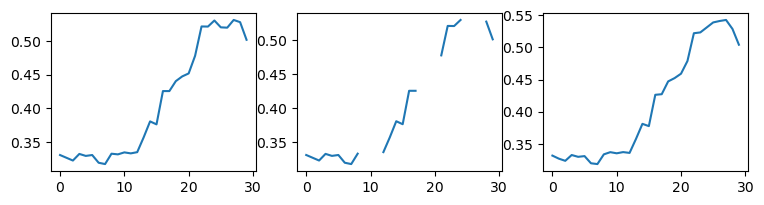

In [42]:
'对补全后数据进行画图'
x_plot = X_ori.cpu().numpy()

recove_plot = xT.permute(0, 2, 1).detach().cpu().numpy()

missing_plot = X_missed.cpu().numpy()

fig = plt.figure(figsize=(9,7))

plt.subplot(3,3,1)
plt.plot(x_plot[0][:,3])    

plt.subplot(3,3,2)
plt.plot(missing_plot[0][:,3])   

plt.subplot(3,3,3)
plt.plot(recove_plot[0][:,3])   

In [241]:
'使用其他数据集  上下两个数据用一个即可 zero-shot补全'

oneshot_data = np.loadtxt('AAL.csv',delimiter = ",")
norm_data = MinMaxScaler().fit_transform(oneshot_data)
x_oneshot = np.array(norm_data[10:40])    # 40-70     seed1 100-130
x_oneshot = torch.from_numpy(x_oneshot).float().cuda()
x_oneshot = x_oneshot.unsqueeze(dim=0)
print(x_oneshot.shape)



np.random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed_all(2)

X_ori, X_missed, missing_mask, indicating_mask = mcar(x_oneshot, 0.5, np.nan)
print(X_missed[0][0])

torch.Size([1, 30, 6])
tensor([   nan, 0.3359,    nan,    nan, 0.3304,    nan], device='cuda:0')


In [242]:
from tqdm import tqdm

import gc
gc.collect()
torch.cuda.empty_cache()


rmse_list =[]
imputation_list = []

for i in tqdm( range(10) ):             # 运行5次计算标准差
    
    gc.collect()
    torch.cuda.empty_cache()
    
    
    saits = SAITS(n_steps=30, n_features=6, n_layers=2, d_model=128, d_inner=64, n_heads=4, d_k=64, d_v=64, dropout=0.1, batch_size=10, epochs=1500)
    
    dataset = {"X": X_missed}
    
    saits.fit(dataset)               
    imputation = saits.impute(dataset)  
    imputation_list.append(imputation)
    
    imputation = torch.from_numpy(imputation).cuda()

    mae = cal_mae(imputation, X_ori, indicating_mask)    # 计算缺失位置的损失
    mse = cal_mse(imputation, X_ori, indicating_mask)
    rmse = cal_rmse(imputation, X_ori, indicating_mask)
    print(mae,mse, rmse)
    
    rmse_list.append(rmse)
    


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]2024-11-25 20:24:52 [INFO]: No given device, using default device: cuda
2024-11-25 20:24:52 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2024-11-25 20:24:52 [INFO]: Model initialized successfully with the number of trainable parameters: 597,780
2024-11-25 20:24:52 [INFO]: epoch 0: training loss 0.8634
2024-11-25 20:24:52 [INFO]: epoch 1: training loss 0.8138
2024-11-25 20:24:52 [INFO]: epoch 2: training loss 0.4844
2024-11-25 20:24:52 [INFO]: epoch 3: training loss 0.5337
2024-11-25 20:24:52 [INFO]: epoch 4: training loss 0.4468
2024-11-25 20:24:52 [INFO]: epoch 5: training loss 0.4918
2024-11-25 20:24:52 [INFO]: epoch 6: training loss 0.4932
2024-11-25 20:24:52 [INFO]: epoch 7: training loss 0.4170
2024-11-25 20:24:52 [INFO]: epoch 8: training loss 0.3601
2024-11-25 20:24:52 [INFO]: epoch 9: training loss 0.4005
2024-11-25 20:24:5

2024-11-25 20:24:54 [INFO]: epoch 132: training loss 0.1030
2024-11-25 20:24:54 [INFO]: epoch 133: training loss 0.1198
2024-11-25 20:24:54 [INFO]: epoch 134: training loss 0.1177
2024-11-25 20:24:54 [INFO]: epoch 135: training loss 0.1138
2024-11-25 20:24:54 [INFO]: epoch 136: training loss 0.1085
2024-11-25 20:24:54 [INFO]: epoch 137: training loss 0.0919
2024-11-25 20:24:54 [INFO]: epoch 138: training loss 0.1240
2024-11-25 20:24:54 [INFO]: epoch 139: training loss 0.1018
2024-11-25 20:24:54 [INFO]: epoch 140: training loss 0.1100
2024-11-25 20:24:54 [INFO]: epoch 141: training loss 0.1061
2024-11-25 20:24:54 [INFO]: epoch 142: training loss 0.0910
2024-11-25 20:24:54 [INFO]: epoch 143: training loss 0.1138
2024-11-25 20:24:54 [INFO]: epoch 144: training loss 0.1246
2024-11-25 20:24:54 [INFO]: epoch 145: training loss 0.0992
2024-11-25 20:24:54 [INFO]: epoch 146: training loss 0.0914
2024-11-25 20:24:54 [INFO]: epoch 147: training loss 0.1148
2024-11-25 20:24:54 [INFO]: epoch 148: t

2024-11-25 20:24:56 [INFO]: epoch 269: training loss 0.0735
2024-11-25 20:24:56 [INFO]: epoch 270: training loss 0.0765
2024-11-25 20:24:56 [INFO]: epoch 271: training loss 0.0830
2024-11-25 20:24:56 [INFO]: epoch 272: training loss 0.0709
2024-11-25 20:24:56 [INFO]: epoch 273: training loss 0.0820
2024-11-25 20:24:56 [INFO]: epoch 274: training loss 0.0914
2024-11-25 20:24:56 [INFO]: epoch 275: training loss 0.0766
2024-11-25 20:24:56 [INFO]: epoch 276: training loss 0.0704
2024-11-25 20:24:56 [INFO]: epoch 277: training loss 0.0694
2024-11-25 20:24:56 [INFO]: epoch 278: training loss 0.0840
2024-11-25 20:24:56 [INFO]: epoch 279: training loss 0.0769
2024-11-25 20:24:56 [INFO]: epoch 280: training loss 0.0928
2024-11-25 20:24:56 [INFO]: epoch 281: training loss 0.0757
2024-11-25 20:24:56 [INFO]: epoch 282: training loss 0.0629
2024-11-25 20:24:56 [INFO]: epoch 283: training loss 0.0700
2024-11-25 20:24:56 [INFO]: epoch 284: training loss 0.0681
2024-11-25 20:24:56 [INFO]: epoch 285: t

2024-11-25 20:24:57 [INFO]: epoch 406: training loss 0.0559
2024-11-25 20:24:57 [INFO]: epoch 407: training loss 0.0530
2024-11-25 20:24:57 [INFO]: epoch 408: training loss 0.0580
2024-11-25 20:24:57 [INFO]: epoch 409: training loss 0.0533
2024-11-25 20:24:57 [INFO]: epoch 410: training loss 0.0545
2024-11-25 20:24:57 [INFO]: epoch 411: training loss 0.0501
2024-11-25 20:24:57 [INFO]: epoch 412: training loss 0.0486
2024-11-25 20:24:58 [INFO]: epoch 413: training loss 0.0566
2024-11-25 20:24:58 [INFO]: epoch 414: training loss 0.0491
2024-11-25 20:24:58 [INFO]: epoch 415: training loss 0.0617
2024-11-25 20:24:58 [INFO]: epoch 416: training loss 0.0574
2024-11-25 20:24:58 [INFO]: epoch 417: training loss 0.0466
2024-11-25 20:24:58 [INFO]: epoch 418: training loss 0.0455
2024-11-25 20:24:58 [INFO]: epoch 419: training loss 0.0484
2024-11-25 20:24:58 [INFO]: epoch 420: training loss 0.0504
2024-11-25 20:24:58 [INFO]: epoch 421: training loss 0.0481
2024-11-25 20:24:58 [INFO]: epoch 422: t

2024-11-25 20:24:59 [INFO]: epoch 543: training loss 0.0470
2024-11-25 20:24:59 [INFO]: epoch 544: training loss 0.0456
2024-11-25 20:24:59 [INFO]: epoch 545: training loss 0.0480
2024-11-25 20:24:59 [INFO]: epoch 546: training loss 0.0425
2024-11-25 20:24:59 [INFO]: epoch 547: training loss 0.0424
2024-11-25 20:24:59 [INFO]: epoch 548: training loss 0.0387
2024-11-25 20:24:59 [INFO]: epoch 549: training loss 0.0440
2024-11-25 20:24:59 [INFO]: epoch 550: training loss 0.0477
2024-11-25 20:24:59 [INFO]: epoch 551: training loss 0.0416
2024-11-25 20:24:59 [INFO]: epoch 552: training loss 0.0406
2024-11-25 20:24:59 [INFO]: epoch 553: training loss 0.0399
2024-11-25 20:24:59 [INFO]: epoch 554: training loss 0.0478
2024-11-25 20:24:59 [INFO]: epoch 555: training loss 0.0425
2024-11-25 20:24:59 [INFO]: epoch 556: training loss 0.0503
2024-11-25 20:24:59 [INFO]: epoch 557: training loss 0.0481
2024-11-25 20:25:00 [INFO]: epoch 558: training loss 0.0471
2024-11-25 20:25:00 [INFO]: epoch 559: t

2024-11-25 20:25:01 [INFO]: epoch 680: training loss 0.0346
2024-11-25 20:25:01 [INFO]: epoch 681: training loss 0.0316
2024-11-25 20:25:01 [INFO]: epoch 682: training loss 0.0353
2024-11-25 20:25:01 [INFO]: epoch 683: training loss 0.0324
2024-11-25 20:25:01 [INFO]: epoch 684: training loss 0.0339
2024-11-25 20:25:01 [INFO]: epoch 685: training loss 0.0421
2024-11-25 20:25:01 [INFO]: epoch 686: training loss 0.0341
2024-11-25 20:25:01 [INFO]: epoch 687: training loss 0.0312
2024-11-25 20:25:01 [INFO]: epoch 688: training loss 0.0355
2024-11-25 20:25:01 [INFO]: epoch 689: training loss 0.0340
2024-11-25 20:25:01 [INFO]: epoch 690: training loss 0.0284
2024-11-25 20:25:01 [INFO]: epoch 691: training loss 0.0399
2024-11-25 20:25:01 [INFO]: epoch 692: training loss 0.0364
2024-11-25 20:25:01 [INFO]: epoch 693: training loss 0.0329
2024-11-25 20:25:01 [INFO]: epoch 694: training loss 0.0341
2024-11-25 20:25:01 [INFO]: epoch 695: training loss 0.0348
2024-11-25 20:25:01 [INFO]: epoch 696: t

2024-11-25 20:25:03 [INFO]: epoch 817: training loss 0.0378
2024-11-25 20:25:03 [INFO]: epoch 818: training loss 0.0395
2024-11-25 20:25:03 [INFO]: epoch 819: training loss 0.0330
2024-11-25 20:25:03 [INFO]: epoch 820: training loss 0.0326
2024-11-25 20:25:03 [INFO]: epoch 821: training loss 0.0321
2024-11-25 20:25:03 [INFO]: epoch 822: training loss 0.0385
2024-11-25 20:25:03 [INFO]: epoch 823: training loss 0.0347
2024-11-25 20:25:03 [INFO]: epoch 824: training loss 0.0296
2024-11-25 20:25:03 [INFO]: epoch 825: training loss 0.0320
2024-11-25 20:25:03 [INFO]: epoch 826: training loss 0.0404
2024-11-25 20:25:03 [INFO]: epoch 827: training loss 0.0347
2024-11-25 20:25:03 [INFO]: epoch 828: training loss 0.0322
2024-11-25 20:25:03 [INFO]: epoch 829: training loss 0.0388
2024-11-25 20:25:03 [INFO]: epoch 830: training loss 0.0333
2024-11-25 20:25:03 [INFO]: epoch 831: training loss 0.0300
2024-11-25 20:25:03 [INFO]: epoch 832: training loss 0.0297
2024-11-25 20:25:03 [INFO]: epoch 833: t

2024-11-25 20:25:05 [INFO]: epoch 954: training loss 0.0317
2024-11-25 20:25:05 [INFO]: epoch 955: training loss 0.0324
2024-11-25 20:25:05 [INFO]: epoch 956: training loss 0.0333
2024-11-25 20:25:05 [INFO]: epoch 957: training loss 0.0290
2024-11-25 20:25:05 [INFO]: epoch 958: training loss 0.0301
2024-11-25 20:25:05 [INFO]: epoch 959: training loss 0.0315
2024-11-25 20:25:05 [INFO]: epoch 960: training loss 0.0285
2024-11-25 20:25:05 [INFO]: epoch 961: training loss 0.0286
2024-11-25 20:25:05 [INFO]: epoch 962: training loss 0.0262
2024-11-25 20:25:05 [INFO]: epoch 963: training loss 0.0314
2024-11-25 20:25:05 [INFO]: epoch 964: training loss 0.0321
2024-11-25 20:25:05 [INFO]: epoch 965: training loss 0.0329
2024-11-25 20:25:05 [INFO]: epoch 966: training loss 0.0313
2024-11-25 20:25:05 [INFO]: epoch 967: training loss 0.0306
2024-11-25 20:25:05 [INFO]: epoch 968: training loss 0.0268
2024-11-25 20:25:05 [INFO]: epoch 969: training loss 0.0338
2024-11-25 20:25:05 [INFO]: epoch 970: t

2024-11-25 20:25:07 [INFO]: epoch 1090: training loss 0.0316
2024-11-25 20:25:07 [INFO]: epoch 1091: training loss 0.0279
2024-11-25 20:25:07 [INFO]: epoch 1092: training loss 0.0265
2024-11-25 20:25:07 [INFO]: epoch 1093: training loss 0.0242
2024-11-25 20:25:07 [INFO]: epoch 1094: training loss 0.0309
2024-11-25 20:25:07 [INFO]: epoch 1095: training loss 0.0296
2024-11-25 20:25:07 [INFO]: epoch 1096: training loss 0.0249
2024-11-25 20:25:07 [INFO]: epoch 1097: training loss 0.0374
2024-11-25 20:25:07 [INFO]: epoch 1098: training loss 0.0264
2024-11-25 20:25:07 [INFO]: epoch 1099: training loss 0.0319
2024-11-25 20:25:07 [INFO]: epoch 1100: training loss 0.0313
2024-11-25 20:25:07 [INFO]: epoch 1101: training loss 0.0315
2024-11-25 20:25:07 [INFO]: epoch 1102: training loss 0.0312
2024-11-25 20:25:07 [INFO]: epoch 1103: training loss 0.0284
2024-11-25 20:25:07 [INFO]: epoch 1104: training loss 0.0278
2024-11-25 20:25:07 [INFO]: epoch 1105: training loss 0.0345
2024-11-25 20:25:07 [INF

2024-11-25 20:25:08 [INFO]: epoch 1225: training loss 0.0286
2024-11-25 20:25:08 [INFO]: epoch 1226: training loss 0.0266
2024-11-25 20:25:08 [INFO]: epoch 1227: training loss 0.0244
2024-11-25 20:25:08 [INFO]: epoch 1228: training loss 0.0219
2024-11-25 20:25:08 [INFO]: epoch 1229: training loss 0.0239
2024-11-25 20:25:08 [INFO]: epoch 1230: training loss 0.0215
2024-11-25 20:25:08 [INFO]: epoch 1231: training loss 0.0285
2024-11-25 20:25:08 [INFO]: epoch 1232: training loss 0.0251
2024-11-25 20:25:08 [INFO]: epoch 1233: training loss 0.0245
2024-11-25 20:25:08 [INFO]: epoch 1234: training loss 0.0254
2024-11-25 20:25:08 [INFO]: epoch 1235: training loss 0.0244
2024-11-25 20:25:08 [INFO]: epoch 1236: training loss 0.0270
2024-11-25 20:25:08 [INFO]: epoch 1237: training loss 0.0258
2024-11-25 20:25:09 [INFO]: epoch 1238: training loss 0.0228
2024-11-25 20:25:09 [INFO]: epoch 1239: training loss 0.0247
2024-11-25 20:25:09 [INFO]: epoch 1240: training loss 0.0250
2024-11-25 20:25:09 [INF

2024-11-25 20:25:10 [INFO]: epoch 1360: training loss 0.0234
2024-11-25 20:25:10 [INFO]: epoch 1361: training loss 0.0222
2024-11-25 20:25:10 [INFO]: epoch 1362: training loss 0.0279
2024-11-25 20:25:10 [INFO]: epoch 1363: training loss 0.0264
2024-11-25 20:25:10 [INFO]: epoch 1364: training loss 0.0197
2024-11-25 20:25:10 [INFO]: epoch 1365: training loss 0.0206
2024-11-25 20:25:10 [INFO]: epoch 1366: training loss 0.0214
2024-11-25 20:25:10 [INFO]: epoch 1367: training loss 0.0233
2024-11-25 20:25:10 [INFO]: epoch 1368: training loss 0.0258
2024-11-25 20:25:10 [INFO]: epoch 1369: training loss 0.0239
2024-11-25 20:25:10 [INFO]: epoch 1370: training loss 0.0331
2024-11-25 20:25:10 [INFO]: epoch 1371: training loss 0.0249
2024-11-25 20:25:10 [INFO]: epoch 1372: training loss 0.0257
2024-11-25 20:25:10 [INFO]: epoch 1373: training loss 0.0290
2024-11-25 20:25:10 [INFO]: epoch 1374: training loss 0.0266
2024-11-25 20:25:10 [INFO]: epoch 1375: training loss 0.0263
2024-11-25 20:25:10 [INF

2024-11-25 20:25:12 [INFO]: epoch 1495: training loss 0.0307
2024-11-25 20:25:12 [INFO]: epoch 1496: training loss 0.0254
2024-11-25 20:25:12 [INFO]: epoch 1497: training loss 0.0296
2024-11-25 20:25:12 [INFO]: epoch 1498: training loss 0.0222
2024-11-25 20:25:12 [INFO]: epoch 1499: training loss 0.0260
2024-11-25 20:25:12 [INFO]: Finished training.
 10%|████████▎                                                                          | 1/10 [00:20<03:03, 20.39s/it]2024-11-25 20:25:12 [INFO]: No given device, using default device: cuda


tensor(0.0192, device='cuda:0') tensor(0.0005, device='cuda:0') tensor(0.0224, device='cuda:0')


2024-11-25 20:25:12 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2024-11-25 20:25:12 [INFO]: Model initialized successfully with the number of trainable parameters: 597,780
2024-11-25 20:25:12 [INFO]: epoch 0: training loss 0.8009
2024-11-25 20:25:12 [INFO]: epoch 1: training loss 0.8247
2024-11-25 20:25:12 [INFO]: epoch 2: training loss 0.7149
2024-11-25 20:25:12 [INFO]: epoch 3: training loss 0.5240
2024-11-25 20:25:12 [INFO]: epoch 4: training loss 0.5489
2024-11-25 20:25:12 [INFO]: epoch 5: training loss 0.3742
2024-11-25 20:25:12 [INFO]: epoch 6: training loss 0.4168
2024-11-25 20:25:12 [INFO]: epoch 7: training loss 0.2997
2024-11-25 20:25:12 [INFO]: epoch 8: training loss 0.3401
2024-11-25 20:25:12 [INFO]: epoch 9: training loss 0.3535
2024-11-25 20:25:12 [INFO]: epoch 10: training loss 0.3291
2024-11-25 20:25:12 [INFO]: epoch 11: training loss 0.3484
2024-11-25 20:25:12 [INFO]: epoch 12: training loss 0.3459
2024-11-25 20:25:12 [INFO]: epoc

2024-11-25 20:25:14 [INFO]: epoch 135: training loss 0.1282
2024-11-25 20:25:14 [INFO]: epoch 136: training loss 0.1148
2024-11-25 20:25:14 [INFO]: epoch 137: training loss 0.1191
2024-11-25 20:25:14 [INFO]: epoch 138: training loss 0.1326
2024-11-25 20:25:14 [INFO]: epoch 139: training loss 0.1390
2024-11-25 20:25:14 [INFO]: epoch 140: training loss 0.1297
2024-11-25 20:25:14 [INFO]: epoch 141: training loss 0.1478
2024-11-25 20:25:14 [INFO]: epoch 142: training loss 0.1280
2024-11-25 20:25:14 [INFO]: epoch 143: training loss 0.1265
2024-11-25 20:25:14 [INFO]: epoch 144: training loss 0.1235
2024-11-25 20:25:14 [INFO]: epoch 145: training loss 0.1431
2024-11-25 20:25:14 [INFO]: epoch 146: training loss 0.1083
2024-11-25 20:25:14 [INFO]: epoch 147: training loss 0.1107
2024-11-25 20:25:14 [INFO]: epoch 148: training loss 0.1072
2024-11-25 20:25:14 [INFO]: epoch 149: training loss 0.1157
2024-11-25 20:25:14 [INFO]: epoch 150: training loss 0.1048
2024-11-25 20:25:14 [INFO]: epoch 151: t

2024-11-25 20:25:16 [INFO]: epoch 272: training loss 0.0572
2024-11-25 20:25:16 [INFO]: epoch 273: training loss 0.0548
2024-11-25 20:25:16 [INFO]: epoch 274: training loss 0.0556
2024-11-25 20:25:16 [INFO]: epoch 275: training loss 0.0648
2024-11-25 20:25:16 [INFO]: epoch 276: training loss 0.0665
2024-11-25 20:25:16 [INFO]: epoch 277: training loss 0.0530
2024-11-25 20:25:16 [INFO]: epoch 278: training loss 0.0729
2024-11-25 20:25:16 [INFO]: epoch 279: training loss 0.0706
2024-11-25 20:25:16 [INFO]: epoch 280: training loss 0.0598
2024-11-25 20:25:16 [INFO]: epoch 281: training loss 0.0686
2024-11-25 20:25:16 [INFO]: epoch 282: training loss 0.0710
2024-11-25 20:25:16 [INFO]: epoch 283: training loss 0.0493
2024-11-25 20:25:16 [INFO]: epoch 284: training loss 0.0576
2024-11-25 20:25:16 [INFO]: epoch 285: training loss 0.0659
2024-11-25 20:25:16 [INFO]: epoch 286: training loss 0.0629
2024-11-25 20:25:16 [INFO]: epoch 287: training loss 0.0529
2024-11-25 20:25:16 [INFO]: epoch 288: t

2024-11-25 20:25:18 [INFO]: epoch 409: training loss 0.0376
2024-11-25 20:25:18 [INFO]: epoch 410: training loss 0.0428
2024-11-25 20:25:18 [INFO]: epoch 411: training loss 0.0417
2024-11-25 20:25:18 [INFO]: epoch 412: training loss 0.0555
2024-11-25 20:25:18 [INFO]: epoch 413: training loss 0.0421
2024-11-25 20:25:18 [INFO]: epoch 414: training loss 0.0353
2024-11-25 20:25:18 [INFO]: epoch 415: training loss 0.0450
2024-11-25 20:25:18 [INFO]: epoch 416: training loss 0.0502
2024-11-25 20:25:18 [INFO]: epoch 417: training loss 0.0472
2024-11-25 20:25:18 [INFO]: epoch 418: training loss 0.0519
2024-11-25 20:25:18 [INFO]: epoch 419: training loss 0.0522
2024-11-25 20:25:18 [INFO]: epoch 420: training loss 0.0503
2024-11-25 20:25:18 [INFO]: epoch 421: training loss 0.0599
2024-11-25 20:25:18 [INFO]: epoch 422: training loss 0.0403
2024-11-25 20:25:18 [INFO]: epoch 423: training loss 0.0574
2024-11-25 20:25:18 [INFO]: epoch 424: training loss 0.0517
2024-11-25 20:25:18 [INFO]: epoch 425: t

2024-11-25 20:25:19 [INFO]: epoch 546: training loss 0.0437
2024-11-25 20:25:19 [INFO]: epoch 547: training loss 0.0345
2024-11-25 20:25:20 [INFO]: epoch 548: training loss 0.0454
2024-11-25 20:25:20 [INFO]: epoch 549: training loss 0.0380
2024-11-25 20:25:20 [INFO]: epoch 550: training loss 0.0390
2024-11-25 20:25:20 [INFO]: epoch 551: training loss 0.0369
2024-11-25 20:25:20 [INFO]: epoch 552: training loss 0.0344
2024-11-25 20:25:20 [INFO]: epoch 553: training loss 0.0361
2024-11-25 20:25:20 [INFO]: epoch 554: training loss 0.0444
2024-11-25 20:25:20 [INFO]: epoch 555: training loss 0.0352
2024-11-25 20:25:20 [INFO]: epoch 556: training loss 0.0334
2024-11-25 20:25:20 [INFO]: epoch 557: training loss 0.0409
2024-11-25 20:25:20 [INFO]: epoch 558: training loss 0.0375
2024-11-25 20:25:20 [INFO]: epoch 559: training loss 0.0390
2024-11-25 20:25:20 [INFO]: epoch 560: training loss 0.0414
2024-11-25 20:25:20 [INFO]: epoch 561: training loss 0.0371
2024-11-25 20:25:20 [INFO]: epoch 562: t

2024-11-25 20:25:21 [INFO]: epoch 683: training loss 0.0383
2024-11-25 20:25:21 [INFO]: epoch 684: training loss 0.0295
2024-11-25 20:25:21 [INFO]: epoch 685: training loss 0.0311
2024-11-25 20:25:21 [INFO]: epoch 686: training loss 0.0342
2024-11-25 20:25:21 [INFO]: epoch 687: training loss 0.0319
2024-11-25 20:25:21 [INFO]: epoch 688: training loss 0.0264
2024-11-25 20:25:21 [INFO]: epoch 689: training loss 0.0312
2024-11-25 20:25:21 [INFO]: epoch 690: training loss 0.0292
2024-11-25 20:25:21 [INFO]: epoch 691: training loss 0.0262
2024-11-25 20:25:21 [INFO]: epoch 692: training loss 0.0289
2024-11-25 20:25:21 [INFO]: epoch 693: training loss 0.0305
2024-11-25 20:25:21 [INFO]: epoch 694: training loss 0.0321
2024-11-25 20:25:21 [INFO]: epoch 695: training loss 0.0304
2024-11-25 20:25:21 [INFO]: epoch 696: training loss 0.0350
2024-11-25 20:25:21 [INFO]: epoch 697: training loss 0.0344
2024-11-25 20:25:21 [INFO]: epoch 698: training loss 0.0344
2024-11-25 20:25:21 [INFO]: epoch 699: t

2024-11-25 20:25:23 [INFO]: epoch 820: training loss 0.0308
2024-11-25 20:25:23 [INFO]: epoch 821: training loss 0.0281
2024-11-25 20:25:23 [INFO]: epoch 822: training loss 0.0223
2024-11-25 20:25:23 [INFO]: epoch 823: training loss 0.0223
2024-11-25 20:25:23 [INFO]: epoch 824: training loss 0.0242
2024-11-25 20:25:23 [INFO]: epoch 825: training loss 0.0209
2024-11-25 20:25:23 [INFO]: epoch 826: training loss 0.0328
2024-11-25 20:25:23 [INFO]: epoch 827: training loss 0.0317
2024-11-25 20:25:23 [INFO]: epoch 828: training loss 0.0258
2024-11-25 20:25:23 [INFO]: epoch 829: training loss 0.0376
2024-11-25 20:25:23 [INFO]: epoch 830: training loss 0.0333
2024-11-25 20:25:23 [INFO]: epoch 831: training loss 0.0292
2024-11-25 20:25:23 [INFO]: epoch 832: training loss 0.0333
2024-11-25 20:25:23 [INFO]: epoch 833: training loss 0.0421
2024-11-25 20:25:23 [INFO]: epoch 834: training loss 0.0317
2024-11-25 20:25:23 [INFO]: epoch 835: training loss 0.0405
2024-11-25 20:25:23 [INFO]: epoch 836: t

2024-11-25 20:25:25 [INFO]: epoch 957: training loss 0.0294
2024-11-25 20:25:25 [INFO]: epoch 958: training loss 0.0321
2024-11-25 20:25:25 [INFO]: epoch 959: training loss 0.0207
2024-11-25 20:25:25 [INFO]: epoch 960: training loss 0.0273
2024-11-25 20:25:25 [INFO]: epoch 961: training loss 0.0243
2024-11-25 20:25:25 [INFO]: epoch 962: training loss 0.0222
2024-11-25 20:25:25 [INFO]: epoch 963: training loss 0.0296
2024-11-25 20:25:25 [INFO]: epoch 964: training loss 0.0225
2024-11-25 20:25:25 [INFO]: epoch 965: training loss 0.0283
2024-11-25 20:25:25 [INFO]: epoch 966: training loss 0.0302
2024-11-25 20:25:25 [INFO]: epoch 967: training loss 0.0270
2024-11-25 20:25:25 [INFO]: epoch 968: training loss 0.0255
2024-11-25 20:25:25 [INFO]: epoch 969: training loss 0.0271
2024-11-25 20:25:25 [INFO]: epoch 970: training loss 0.0243
2024-11-25 20:25:25 [INFO]: epoch 971: training loss 0.0294
2024-11-25 20:25:25 [INFO]: epoch 972: training loss 0.0249
2024-11-25 20:25:25 [INFO]: epoch 973: t

2024-11-25 20:25:27 [INFO]: epoch 1093: training loss 0.0224
2024-11-25 20:25:27 [INFO]: epoch 1094: training loss 0.0226
2024-11-25 20:25:27 [INFO]: epoch 1095: training loss 0.0302
2024-11-25 20:25:27 [INFO]: epoch 1096: training loss 0.0261
2024-11-25 20:25:27 [INFO]: epoch 1097: training loss 0.0246
2024-11-25 20:25:27 [INFO]: epoch 1098: training loss 0.0252
2024-11-25 20:25:27 [INFO]: epoch 1099: training loss 0.0258
2024-11-25 20:25:27 [INFO]: epoch 1100: training loss 0.0201
2024-11-25 20:25:27 [INFO]: epoch 1101: training loss 0.0216
2024-11-25 20:25:27 [INFO]: epoch 1102: training loss 0.0208
2024-11-25 20:25:27 [INFO]: epoch 1103: training loss 0.0251
2024-11-25 20:25:27 [INFO]: epoch 1104: training loss 0.0175
2024-11-25 20:25:27 [INFO]: epoch 1105: training loss 0.0214
2024-11-25 20:25:27 [INFO]: epoch 1106: training loss 0.0213
2024-11-25 20:25:27 [INFO]: epoch 1107: training loss 0.0255
2024-11-25 20:25:27 [INFO]: epoch 1108: training loss 0.0186
2024-11-25 20:25:27 [INF

2024-11-25 20:25:28 [INFO]: epoch 1228: training loss 0.0266
2024-11-25 20:25:28 [INFO]: epoch 1229: training loss 0.0258
2024-11-25 20:25:29 [INFO]: epoch 1230: training loss 0.0221
2024-11-25 20:25:29 [INFO]: epoch 1231: training loss 0.0304
2024-11-25 20:25:29 [INFO]: epoch 1232: training loss 0.0228
2024-11-25 20:25:29 [INFO]: epoch 1233: training loss 0.0210
2024-11-25 20:25:29 [INFO]: epoch 1234: training loss 0.0256
2024-11-25 20:25:29 [INFO]: epoch 1235: training loss 0.0217
2024-11-25 20:25:29 [INFO]: epoch 1236: training loss 0.0216
2024-11-25 20:25:29 [INFO]: epoch 1237: training loss 0.0250
2024-11-25 20:25:29 [INFO]: epoch 1238: training loss 0.0247
2024-11-25 20:25:29 [INFO]: epoch 1239: training loss 0.0209
2024-11-25 20:25:29 [INFO]: epoch 1240: training loss 0.0226
2024-11-25 20:25:29 [INFO]: epoch 1241: training loss 0.0220
2024-11-25 20:25:29 [INFO]: epoch 1242: training loss 0.0263
2024-11-25 20:25:29 [INFO]: epoch 1243: training loss 0.0254
2024-11-25 20:25:29 [INF

2024-11-25 20:25:30 [INFO]: epoch 1363: training loss 0.0218
2024-11-25 20:25:30 [INFO]: epoch 1364: training loss 0.0207
2024-11-25 20:25:30 [INFO]: epoch 1365: training loss 0.0205
2024-11-25 20:25:30 [INFO]: epoch 1366: training loss 0.0215
2024-11-25 20:25:30 [INFO]: epoch 1367: training loss 0.0251
2024-11-25 20:25:30 [INFO]: epoch 1368: training loss 0.0236
2024-11-25 20:25:30 [INFO]: epoch 1369: training loss 0.0198
2024-11-25 20:25:30 [INFO]: epoch 1370: training loss 0.0188
2024-11-25 20:25:30 [INFO]: epoch 1371: training loss 0.0227
2024-11-25 20:25:30 [INFO]: epoch 1372: training loss 0.0213
2024-11-25 20:25:30 [INFO]: epoch 1373: training loss 0.0267
2024-11-25 20:25:30 [INFO]: epoch 1374: training loss 0.0230
2024-11-25 20:25:30 [INFO]: epoch 1375: training loss 0.0203
2024-11-25 20:25:30 [INFO]: epoch 1376: training loss 0.0198
2024-11-25 20:25:30 [INFO]: epoch 1377: training loss 0.0253
2024-11-25 20:25:30 [INFO]: epoch 1378: training loss 0.0230
2024-11-25 20:25:30 [INF

2024-11-25 20:25:32 [INFO]: epoch 1498: training loss 0.0205
2024-11-25 20:25:32 [INFO]: epoch 1499: training loss 0.0228
2024-11-25 20:25:32 [INFO]: Finished training.
 20%|████████████████▌                                                                  | 2/10 [00:40<02:41, 20.21s/it]2024-11-25 20:25:32 [INFO]: No given device, using default device: cuda


tensor(0.0174, device='cuda:0') tensor(0.0005, device='cuda:0') tensor(0.0232, device='cuda:0')


2024-11-25 20:25:32 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2024-11-25 20:25:32 [INFO]: Model initialized successfully with the number of trainable parameters: 597,780
2024-11-25 20:25:32 [INFO]: epoch 0: training loss 0.9249
2024-11-25 20:25:32 [INFO]: epoch 1: training loss 0.7177
2024-11-25 20:25:32 [INFO]: epoch 2: training loss 0.5547
2024-11-25 20:25:32 [INFO]: epoch 3: training loss 0.5652
2024-11-25 20:25:32 [INFO]: epoch 4: training loss 0.5936
2024-11-25 20:25:32 [INFO]: epoch 5: training loss 0.3627
2024-11-25 20:25:32 [INFO]: epoch 6: training loss 0.4208
2024-11-25 20:25:32 [INFO]: epoch 7: training loss 0.3984
2024-11-25 20:25:32 [INFO]: epoch 8: training loss 0.4904
2024-11-25 20:25:32 [INFO]: epoch 9: training loss 0.3865
2024-11-25 20:25:32 [INFO]: epoch 10: training loss 0.3243
2024-11-25 20:25:32 [INFO]: epoch 11: training loss 0.3434
2024-11-25 20:25:32 [INFO]: epoch 12: training loss 0.3722
2024-11-25 20:25:32 [INFO]: epoc

2024-11-25 20:25:34 [INFO]: epoch 135: training loss 0.1044
2024-11-25 20:25:34 [INFO]: epoch 136: training loss 0.1228
2024-11-25 20:25:34 [INFO]: epoch 137: training loss 0.1129
2024-11-25 20:25:34 [INFO]: epoch 138: training loss 0.0983
2024-11-25 20:25:34 [INFO]: epoch 139: training loss 0.0902
2024-11-25 20:25:34 [INFO]: epoch 140: training loss 0.1233
2024-11-25 20:25:34 [INFO]: epoch 141: training loss 0.0983
2024-11-25 20:25:34 [INFO]: epoch 142: training loss 0.0829
2024-11-25 20:25:34 [INFO]: epoch 143: training loss 0.0958
2024-11-25 20:25:34 [INFO]: epoch 144: training loss 0.0780
2024-11-25 20:25:34 [INFO]: epoch 145: training loss 0.0920
2024-11-25 20:25:34 [INFO]: epoch 146: training loss 0.0727
2024-11-25 20:25:34 [INFO]: epoch 147: training loss 0.0899
2024-11-25 20:25:34 [INFO]: epoch 148: training loss 0.0901
2024-11-25 20:25:34 [INFO]: epoch 149: training loss 0.1022
2024-11-25 20:25:34 [INFO]: epoch 150: training loss 0.0966
2024-11-25 20:25:34 [INFO]: epoch 151: t

2024-11-25 20:25:36 [INFO]: epoch 272: training loss 0.0623
2024-11-25 20:25:36 [INFO]: epoch 273: training loss 0.0536
2024-11-25 20:25:36 [INFO]: epoch 274: training loss 0.0610
2024-11-25 20:25:36 [INFO]: epoch 275: training loss 0.0588
2024-11-25 20:25:36 [INFO]: epoch 276: training loss 0.0626
2024-11-25 20:25:36 [INFO]: epoch 277: training loss 0.0641
2024-11-25 20:25:36 [INFO]: epoch 278: training loss 0.0506
2024-11-25 20:25:36 [INFO]: epoch 279: training loss 0.0520
2024-11-25 20:25:36 [INFO]: epoch 280: training loss 0.0556
2024-11-25 20:25:36 [INFO]: epoch 281: training loss 0.0573
2024-11-25 20:25:36 [INFO]: epoch 282: training loss 0.0594
2024-11-25 20:25:36 [INFO]: epoch 283: training loss 0.0683
2024-11-25 20:25:36 [INFO]: epoch 284: training loss 0.0546
2024-11-25 20:25:36 [INFO]: epoch 285: training loss 0.0670
2024-11-25 20:25:36 [INFO]: epoch 286: training loss 0.0659
2024-11-25 20:25:36 [INFO]: epoch 287: training loss 0.0517
2024-11-25 20:25:36 [INFO]: epoch 288: t

2024-11-25 20:25:38 [INFO]: epoch 409: training loss 0.0484
2024-11-25 20:25:38 [INFO]: epoch 410: training loss 0.0602
2024-11-25 20:25:38 [INFO]: epoch 411: training loss 0.0466
2024-11-25 20:25:38 [INFO]: epoch 412: training loss 0.0468
2024-11-25 20:25:38 [INFO]: epoch 413: training loss 0.0494
2024-11-25 20:25:38 [INFO]: epoch 414: training loss 0.0511
2024-11-25 20:25:38 [INFO]: epoch 415: training loss 0.0441
2024-11-25 20:25:38 [INFO]: epoch 416: training loss 0.0516
2024-11-25 20:25:38 [INFO]: epoch 417: training loss 0.0461
2024-11-25 20:25:38 [INFO]: epoch 418: training loss 0.0543
2024-11-25 20:25:38 [INFO]: epoch 419: training loss 0.0507
2024-11-25 20:25:38 [INFO]: epoch 420: training loss 0.0560
2024-11-25 20:25:38 [INFO]: epoch 421: training loss 0.0403
2024-11-25 20:25:38 [INFO]: epoch 422: training loss 0.0452
2024-11-25 20:25:38 [INFO]: epoch 423: training loss 0.0475
2024-11-25 20:25:38 [INFO]: epoch 424: training loss 0.0500
2024-11-25 20:25:38 [INFO]: epoch 425: t

2024-11-25 20:25:39 [INFO]: epoch 546: training loss 0.0365
2024-11-25 20:25:39 [INFO]: epoch 547: training loss 0.0377
2024-11-25 20:25:40 [INFO]: epoch 548: training loss 0.0364
2024-11-25 20:25:40 [INFO]: epoch 549: training loss 0.0373
2024-11-25 20:25:40 [INFO]: epoch 550: training loss 0.0367
2024-11-25 20:25:40 [INFO]: epoch 551: training loss 0.0366
2024-11-25 20:25:40 [INFO]: epoch 552: training loss 0.0318
2024-11-25 20:25:40 [INFO]: epoch 553: training loss 0.0379
2024-11-25 20:25:40 [INFO]: epoch 554: training loss 0.0389
2024-11-25 20:25:40 [INFO]: epoch 555: training loss 0.0357
2024-11-25 20:25:40 [INFO]: epoch 556: training loss 0.0412
2024-11-25 20:25:40 [INFO]: epoch 557: training loss 0.0357
2024-11-25 20:25:40 [INFO]: epoch 558: training loss 0.0393
2024-11-25 20:25:40 [INFO]: epoch 559: training loss 0.0339
2024-11-25 20:25:40 [INFO]: epoch 560: training loss 0.0423
2024-11-25 20:25:40 [INFO]: epoch 561: training loss 0.0361
2024-11-25 20:25:40 [INFO]: epoch 562: t

2024-11-25 20:25:41 [INFO]: epoch 683: training loss 0.0332
2024-11-25 20:25:41 [INFO]: epoch 684: training loss 0.0383
2024-11-25 20:25:41 [INFO]: epoch 685: training loss 0.0287
2024-11-25 20:25:41 [INFO]: epoch 686: training loss 0.0428
2024-11-25 20:25:41 [INFO]: epoch 687: training loss 0.0341
2024-11-25 20:25:41 [INFO]: epoch 688: training loss 0.0304
2024-11-25 20:25:41 [INFO]: epoch 689: training loss 0.0374
2024-11-25 20:25:41 [INFO]: epoch 690: training loss 0.0333
2024-11-25 20:25:41 [INFO]: epoch 691: training loss 0.0365
2024-11-25 20:25:41 [INFO]: epoch 692: training loss 0.0305
2024-11-25 20:25:41 [INFO]: epoch 693: training loss 0.0294
2024-11-25 20:25:41 [INFO]: epoch 694: training loss 0.0333
2024-11-25 20:25:41 [INFO]: epoch 695: training loss 0.0343
2024-11-25 20:25:41 [INFO]: epoch 696: training loss 0.0429
2024-11-25 20:25:41 [INFO]: epoch 697: training loss 0.0286
2024-11-25 20:25:41 [INFO]: epoch 698: training loss 0.0286
2024-11-25 20:25:41 [INFO]: epoch 699: t

2024-11-25 20:25:43 [INFO]: epoch 820: training loss 0.0278
2024-11-25 20:25:43 [INFO]: epoch 821: training loss 0.0393
2024-11-25 20:25:43 [INFO]: epoch 822: training loss 0.0347
2024-11-25 20:25:43 [INFO]: epoch 823: training loss 0.0322
2024-11-25 20:25:43 [INFO]: epoch 824: training loss 0.0399
2024-11-25 20:25:43 [INFO]: epoch 825: training loss 0.0344
2024-11-25 20:25:43 [INFO]: epoch 826: training loss 0.0298
2024-11-25 20:25:43 [INFO]: epoch 827: training loss 0.0311
2024-11-25 20:25:43 [INFO]: epoch 828: training loss 0.0322
2024-11-25 20:25:43 [INFO]: epoch 829: training loss 0.0333
2024-11-25 20:25:43 [INFO]: epoch 830: training loss 0.0317
2024-11-25 20:25:43 [INFO]: epoch 831: training loss 0.0318
2024-11-25 20:25:43 [INFO]: epoch 832: training loss 0.0379
2024-11-25 20:25:43 [INFO]: epoch 833: training loss 0.0332
2024-11-25 20:25:43 [INFO]: epoch 834: training loss 0.0338
2024-11-25 20:25:43 [INFO]: epoch 835: training loss 0.0325
2024-11-25 20:25:43 [INFO]: epoch 836: t

2024-11-25 20:25:45 [INFO]: epoch 957: training loss 0.0352
2024-11-25 20:25:45 [INFO]: epoch 958: training loss 0.0301
2024-11-25 20:25:45 [INFO]: epoch 959: training loss 0.0437
2024-11-25 20:25:45 [INFO]: epoch 960: training loss 0.0366
2024-11-25 20:25:45 [INFO]: epoch 961: training loss 0.0376
2024-11-25 20:25:45 [INFO]: epoch 962: training loss 0.0385
2024-11-25 20:25:45 [INFO]: epoch 963: training loss 0.0321
2024-11-25 20:25:45 [INFO]: epoch 964: training loss 0.0308
2024-11-25 20:25:45 [INFO]: epoch 965: training loss 0.0332
2024-11-25 20:25:45 [INFO]: epoch 966: training loss 0.0381
2024-11-25 20:25:45 [INFO]: epoch 967: training loss 0.0274
2024-11-25 20:25:45 [INFO]: epoch 968: training loss 0.0324
2024-11-25 20:25:45 [INFO]: epoch 969: training loss 0.0343
2024-11-25 20:25:45 [INFO]: epoch 970: training loss 0.0273
2024-11-25 20:25:45 [INFO]: epoch 971: training loss 0.0308
2024-11-25 20:25:45 [INFO]: epoch 972: training loss 0.0295
2024-11-25 20:25:45 [INFO]: epoch 973: t

2024-11-25 20:25:47 [INFO]: epoch 1093: training loss 0.0250
2024-11-25 20:25:47 [INFO]: epoch 1094: training loss 0.0250
2024-11-25 20:25:47 [INFO]: epoch 1095: training loss 0.0244
2024-11-25 20:25:47 [INFO]: epoch 1096: training loss 0.0247
2024-11-25 20:25:47 [INFO]: epoch 1097: training loss 0.0273
2024-11-25 20:25:47 [INFO]: epoch 1098: training loss 0.0271
2024-11-25 20:25:47 [INFO]: epoch 1099: training loss 0.0296
2024-11-25 20:25:47 [INFO]: epoch 1100: training loss 0.0275
2024-11-25 20:25:47 [INFO]: epoch 1101: training loss 0.0273
2024-11-25 20:25:47 [INFO]: epoch 1102: training loss 0.0263
2024-11-25 20:25:47 [INFO]: epoch 1103: training loss 0.0322
2024-11-25 20:25:47 [INFO]: epoch 1104: training loss 0.0245
2024-11-25 20:25:47 [INFO]: epoch 1105: training loss 0.0340
2024-11-25 20:25:47 [INFO]: epoch 1106: training loss 0.0280
2024-11-25 20:25:47 [INFO]: epoch 1107: training loss 0.0238
2024-11-25 20:25:47 [INFO]: epoch 1108: training loss 0.0290
2024-11-25 20:25:47 [INF

2024-11-25 20:25:49 [INFO]: epoch 1228: training loss 0.0259
2024-11-25 20:25:49 [INFO]: epoch 1229: training loss 0.0219
2024-11-25 20:25:49 [INFO]: epoch 1230: training loss 0.0283
2024-11-25 20:25:49 [INFO]: epoch 1231: training loss 0.0299
2024-11-25 20:25:49 [INFO]: epoch 1232: training loss 0.0248
2024-11-25 20:25:49 [INFO]: epoch 1233: training loss 0.0254
2024-11-25 20:25:49 [INFO]: epoch 1234: training loss 0.0228
2024-11-25 20:25:49 [INFO]: epoch 1235: training loss 0.0256
2024-11-25 20:25:49 [INFO]: epoch 1236: training loss 0.0253
2024-11-25 20:25:49 [INFO]: epoch 1237: training loss 0.0246
2024-11-25 20:25:49 [INFO]: epoch 1238: training loss 0.0234
2024-11-25 20:25:49 [INFO]: epoch 1239: training loss 0.0219
2024-11-25 20:25:49 [INFO]: epoch 1240: training loss 0.0247
2024-11-25 20:25:49 [INFO]: epoch 1241: training loss 0.0243
2024-11-25 20:25:49 [INFO]: epoch 1242: training loss 0.0339
2024-11-25 20:25:49 [INFO]: epoch 1243: training loss 0.0248
2024-11-25 20:25:49 [INF

2024-11-25 20:25:50 [INFO]: epoch 1363: training loss 0.0258
2024-11-25 20:25:50 [INFO]: epoch 1364: training loss 0.0273
2024-11-25 20:25:50 [INFO]: epoch 1365: training loss 0.0238
2024-11-25 20:25:50 [INFO]: epoch 1366: training loss 0.0284
2024-11-25 20:25:50 [INFO]: epoch 1367: training loss 0.0230
2024-11-25 20:25:50 [INFO]: epoch 1368: training loss 0.0337
2024-11-25 20:25:50 [INFO]: epoch 1369: training loss 0.0212
2024-11-25 20:25:51 [INFO]: epoch 1370: training loss 0.0253
2024-11-25 20:25:51 [INFO]: epoch 1371: training loss 0.0255
2024-11-25 20:25:51 [INFO]: epoch 1372: training loss 0.0209
2024-11-25 20:25:51 [INFO]: epoch 1373: training loss 0.0231
2024-11-25 20:25:51 [INFO]: epoch 1374: training loss 0.0205
2024-11-25 20:25:51 [INFO]: epoch 1375: training loss 0.0230
2024-11-25 20:25:51 [INFO]: epoch 1376: training loss 0.0265
2024-11-25 20:25:51 [INFO]: epoch 1377: training loss 0.0233
2024-11-25 20:25:51 [INFO]: epoch 1378: training loss 0.0271
2024-11-25 20:25:51 [INF

2024-11-25 20:25:52 [INFO]: epoch 1498: training loss 0.0257
2024-11-25 20:25:52 [INFO]: epoch 1499: training loss 0.0265
2024-11-25 20:25:52 [INFO]: Finished training.
 30%|████████████████████████▉                                                          | 3/10 [01:00<02:21, 20.22s/it]

tensor(0.0124, device='cuda:0') tensor(0.0004, device='cuda:0') tensor(0.0209, device='cuda:0')


2024-11-25 20:25:52 [INFO]: No given device, using default device: cuda
2024-11-25 20:25:52 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2024-11-25 20:25:52 [INFO]: Model initialized successfully with the number of trainable parameters: 597,780
2024-11-25 20:25:52 [INFO]: epoch 0: training loss 0.7507
2024-11-25 20:25:52 [INFO]: epoch 1: training loss 0.6775
2024-11-25 20:25:53 [INFO]: epoch 2: training loss 0.8560
2024-11-25 20:25:53 [INFO]: epoch 3: training loss 0.7438
2024-11-25 20:25:53 [INFO]: epoch 4: training loss 0.4666
2024-11-25 20:25:53 [INFO]: epoch 5: training loss 0.4791
2024-11-25 20:25:53 [INFO]: epoch 6: training loss 0.4914
2024-11-25 20:25:53 [INFO]: epoch 7: training loss 0.4421
2024-11-25 20:25:53 [INFO]: epoch 8: training loss 0.5156
2024-11-25 20:25:53 [INFO]: epoch 9: training loss 0.4492
2024-11-25 20:25:53 [INFO]: epoch 10: training loss 0.3686
2024-11-25 20:25:53 [INFO]: epoch 11: training loss 0.4219
2024-11-25 20:25:53

2024-11-25 20:25:54 [INFO]: epoch 134: training loss 0.1120
2024-11-25 20:25:54 [INFO]: epoch 135: training loss 0.1463
2024-11-25 20:25:54 [INFO]: epoch 136: training loss 0.1478
2024-11-25 20:25:54 [INFO]: epoch 137: training loss 0.1679
2024-11-25 20:25:54 [INFO]: epoch 138: training loss 0.1538
2024-11-25 20:25:54 [INFO]: epoch 139: training loss 0.1629
2024-11-25 20:25:54 [INFO]: epoch 140: training loss 0.1649
2024-11-25 20:25:54 [INFO]: epoch 141: training loss 0.1459
2024-11-25 20:25:54 [INFO]: epoch 142: training loss 0.1282
2024-11-25 20:25:54 [INFO]: epoch 143: training loss 0.1235
2024-11-25 20:25:54 [INFO]: epoch 144: training loss 0.1510
2024-11-25 20:25:54 [INFO]: epoch 145: training loss 0.1402
2024-11-25 20:25:54 [INFO]: epoch 146: training loss 0.1289
2024-11-25 20:25:55 [INFO]: epoch 147: training loss 0.1230
2024-11-25 20:25:55 [INFO]: epoch 148: training loss 0.1317
2024-11-25 20:25:55 [INFO]: epoch 149: training loss 0.1127
2024-11-25 20:25:55 [INFO]: epoch 150: t

2024-11-25 20:25:56 [INFO]: epoch 271: training loss 0.0587
2024-11-25 20:25:56 [INFO]: epoch 272: training loss 0.0652
2024-11-25 20:25:56 [INFO]: epoch 273: training loss 0.0662
2024-11-25 20:25:56 [INFO]: epoch 274: training loss 0.0635
2024-11-25 20:25:56 [INFO]: epoch 275: training loss 0.0707
2024-11-25 20:25:56 [INFO]: epoch 276: training loss 0.0691
2024-11-25 20:25:56 [INFO]: epoch 277: training loss 0.0617
2024-11-25 20:25:56 [INFO]: epoch 278: training loss 0.0614
2024-11-25 20:25:56 [INFO]: epoch 279: training loss 0.0860
2024-11-25 20:25:56 [INFO]: epoch 280: training loss 0.0673
2024-11-25 20:25:56 [INFO]: epoch 281: training loss 0.0789
2024-11-25 20:25:56 [INFO]: epoch 282: training loss 0.0803
2024-11-25 20:25:56 [INFO]: epoch 283: training loss 0.0536
2024-11-25 20:25:56 [INFO]: epoch 284: training loss 0.0660
2024-11-25 20:25:56 [INFO]: epoch 285: training loss 0.0630
2024-11-25 20:25:57 [INFO]: epoch 286: training loss 0.0638
2024-11-25 20:25:57 [INFO]: epoch 287: t

2024-11-25 20:25:58 [INFO]: epoch 408: training loss 0.0469
2024-11-25 20:25:58 [INFO]: epoch 409: training loss 0.0485
2024-11-25 20:25:58 [INFO]: epoch 410: training loss 0.0443
2024-11-25 20:25:58 [INFO]: epoch 411: training loss 0.0439
2024-11-25 20:25:58 [INFO]: epoch 412: training loss 0.0465
2024-11-25 20:25:58 [INFO]: epoch 413: training loss 0.0444
2024-11-25 20:25:58 [INFO]: epoch 414: training loss 0.0466
2024-11-25 20:25:58 [INFO]: epoch 415: training loss 0.0434
2024-11-25 20:25:58 [INFO]: epoch 416: training loss 0.0428
2024-11-25 20:25:58 [INFO]: epoch 417: training loss 0.0587
2024-11-25 20:25:58 [INFO]: epoch 418: training loss 0.0544
2024-11-25 20:25:58 [INFO]: epoch 419: training loss 0.0477
2024-11-25 20:25:58 [INFO]: epoch 420: training loss 0.0456
2024-11-25 20:25:58 [INFO]: epoch 421: training loss 0.0519
2024-11-25 20:25:58 [INFO]: epoch 422: training loss 0.0532
2024-11-25 20:25:58 [INFO]: epoch 423: training loss 0.0495
2024-11-25 20:25:58 [INFO]: epoch 424: t

2024-11-25 20:26:00 [INFO]: epoch 545: training loss 0.0350
2024-11-25 20:26:00 [INFO]: epoch 546: training loss 0.0442
2024-11-25 20:26:00 [INFO]: epoch 547: training loss 0.0377
2024-11-25 20:26:00 [INFO]: epoch 548: training loss 0.0361
2024-11-25 20:26:00 [INFO]: epoch 549: training loss 0.0337
2024-11-25 20:26:00 [INFO]: epoch 550: training loss 0.0373
2024-11-25 20:26:00 [INFO]: epoch 551: training loss 0.0332
2024-11-25 20:26:00 [INFO]: epoch 552: training loss 0.0406
2024-11-25 20:26:00 [INFO]: epoch 553: training loss 0.0375
2024-11-25 20:26:00 [INFO]: epoch 554: training loss 0.0338
2024-11-25 20:26:00 [INFO]: epoch 555: training loss 0.0374
2024-11-25 20:26:00 [INFO]: epoch 556: training loss 0.0433
2024-11-25 20:26:00 [INFO]: epoch 557: training loss 0.0393
2024-11-25 20:26:00 [INFO]: epoch 558: training loss 0.0289
2024-11-25 20:26:00 [INFO]: epoch 559: training loss 0.0316
2024-11-25 20:26:00 [INFO]: epoch 560: training loss 0.0410
2024-11-25 20:26:00 [INFO]: epoch 561: t

2024-11-25 20:26:02 [INFO]: epoch 682: training loss 0.0291
2024-11-25 20:26:02 [INFO]: epoch 683: training loss 0.0296
2024-11-25 20:26:02 [INFO]: epoch 684: training loss 0.0332
2024-11-25 20:26:02 [INFO]: epoch 685: training loss 0.0280
2024-11-25 20:26:02 [INFO]: epoch 686: training loss 0.0287
2024-11-25 20:26:02 [INFO]: epoch 687: training loss 0.0337
2024-11-25 20:26:02 [INFO]: epoch 688: training loss 0.0333
2024-11-25 20:26:02 [INFO]: epoch 689: training loss 0.0339
2024-11-25 20:26:02 [INFO]: epoch 690: training loss 0.0400
2024-11-25 20:26:02 [INFO]: epoch 691: training loss 0.0379
2024-11-25 20:26:02 [INFO]: epoch 692: training loss 0.0296
2024-11-25 20:26:02 [INFO]: epoch 693: training loss 0.0303
2024-11-25 20:26:02 [INFO]: epoch 694: training loss 0.0278
2024-11-25 20:26:02 [INFO]: epoch 695: training loss 0.0238
2024-11-25 20:26:02 [INFO]: epoch 696: training loss 0.0271
2024-11-25 20:26:02 [INFO]: epoch 697: training loss 0.0301
2024-11-25 20:26:02 [INFO]: epoch 698: t

2024-11-25 20:26:04 [INFO]: epoch 819: training loss 0.0325
2024-11-25 20:26:04 [INFO]: epoch 820: training loss 0.0364
2024-11-25 20:26:04 [INFO]: epoch 821: training loss 0.0309
2024-11-25 20:26:04 [INFO]: epoch 822: training loss 0.0438
2024-11-25 20:26:04 [INFO]: epoch 823: training loss 0.0417
2024-11-25 20:26:04 [INFO]: epoch 824: training loss 0.0299
2024-11-25 20:26:04 [INFO]: epoch 825: training loss 0.0259
2024-11-25 20:26:04 [INFO]: epoch 826: training loss 0.0312
2024-11-25 20:26:04 [INFO]: epoch 827: training loss 0.0299
2024-11-25 20:26:04 [INFO]: epoch 828: training loss 0.0288
2024-11-25 20:26:04 [INFO]: epoch 829: training loss 0.0245
2024-11-25 20:26:04 [INFO]: epoch 830: training loss 0.0265
2024-11-25 20:26:04 [INFO]: epoch 831: training loss 0.0262
2024-11-25 20:26:04 [INFO]: epoch 832: training loss 0.0260
2024-11-25 20:26:04 [INFO]: epoch 833: training loss 0.0229
2024-11-25 20:26:04 [INFO]: epoch 834: training loss 0.0248
2024-11-25 20:26:04 [INFO]: epoch 835: t

2024-11-25 20:26:05 [INFO]: epoch 956: training loss 0.0303
2024-11-25 20:26:05 [INFO]: epoch 957: training loss 0.0322
2024-11-25 20:26:05 [INFO]: epoch 958: training loss 0.0197
2024-11-25 20:26:05 [INFO]: epoch 959: training loss 0.0326
2024-11-25 20:26:06 [INFO]: epoch 960: training loss 0.0378
2024-11-25 20:26:06 [INFO]: epoch 961: training loss 0.0282
2024-11-25 20:26:06 [INFO]: epoch 962: training loss 0.0277
2024-11-25 20:26:06 [INFO]: epoch 963: training loss 0.0379
2024-11-25 20:26:06 [INFO]: epoch 964: training loss 0.0301
2024-11-25 20:26:06 [INFO]: epoch 965: training loss 0.0248
2024-11-25 20:26:06 [INFO]: epoch 966: training loss 0.0316
2024-11-25 20:26:06 [INFO]: epoch 967: training loss 0.0324
2024-11-25 20:26:06 [INFO]: epoch 968: training loss 0.0235
2024-11-25 20:26:06 [INFO]: epoch 969: training loss 0.0314
2024-11-25 20:26:06 [INFO]: epoch 970: training loss 0.0287
2024-11-25 20:26:06 [INFO]: epoch 971: training loss 0.0288
2024-11-25 20:26:06 [INFO]: epoch 972: t

2024-11-25 20:26:07 [INFO]: epoch 1092: training loss 0.0243
2024-11-25 20:26:07 [INFO]: epoch 1093: training loss 0.0231
2024-11-25 20:26:07 [INFO]: epoch 1094: training loss 0.0228
2024-11-25 20:26:07 [INFO]: epoch 1095: training loss 0.0202
2024-11-25 20:26:07 [INFO]: epoch 1096: training loss 0.0292
2024-11-25 20:26:07 [INFO]: epoch 1097: training loss 0.0222
2024-11-25 20:26:07 [INFO]: epoch 1098: training loss 0.0248
2024-11-25 20:26:07 [INFO]: epoch 1099: training loss 0.0245
2024-11-25 20:26:07 [INFO]: epoch 1100: training loss 0.0281
2024-11-25 20:26:07 [INFO]: epoch 1101: training loss 0.0196
2024-11-25 20:26:07 [INFO]: epoch 1102: training loss 0.0229
2024-11-25 20:26:07 [INFO]: epoch 1103: training loss 0.0242
2024-11-25 20:26:07 [INFO]: epoch 1104: training loss 0.0224
2024-11-25 20:26:07 [INFO]: epoch 1105: training loss 0.0234
2024-11-25 20:26:07 [INFO]: epoch 1106: training loss 0.0240
2024-11-25 20:26:07 [INFO]: epoch 1107: training loss 0.0205
2024-11-25 20:26:07 [INF

2024-11-25 20:26:09 [INFO]: epoch 1227: training loss 0.0191
2024-11-25 20:26:09 [INFO]: epoch 1228: training loss 0.0213
2024-11-25 20:26:09 [INFO]: epoch 1229: training loss 0.0227
2024-11-25 20:26:09 [INFO]: epoch 1230: training loss 0.0207
2024-11-25 20:26:09 [INFO]: epoch 1231: training loss 0.0210
2024-11-25 20:26:09 [INFO]: epoch 1232: training loss 0.0252
2024-11-25 20:26:09 [INFO]: epoch 1233: training loss 0.0251
2024-11-25 20:26:09 [INFO]: epoch 1234: training loss 0.0214
2024-11-25 20:26:09 [INFO]: epoch 1235: training loss 0.0216
2024-11-25 20:26:09 [INFO]: epoch 1236: training loss 0.0301
2024-11-25 20:26:09 [INFO]: epoch 1237: training loss 0.0271
2024-11-25 20:26:09 [INFO]: epoch 1238: training loss 0.0218
2024-11-25 20:26:09 [INFO]: epoch 1239: training loss 0.0261
2024-11-25 20:26:09 [INFO]: epoch 1240: training loss 0.0234
2024-11-25 20:26:09 [INFO]: epoch 1241: training loss 0.0205
2024-11-25 20:26:09 [INFO]: epoch 1242: training loss 0.0253
2024-11-25 20:26:09 [INF

2024-11-25 20:26:11 [INFO]: epoch 1362: training loss 0.0189
2024-11-25 20:26:11 [INFO]: epoch 1363: training loss 0.0247
2024-11-25 20:26:11 [INFO]: epoch 1364: training loss 0.0201
2024-11-25 20:26:11 [INFO]: epoch 1365: training loss 0.0215
2024-11-25 20:26:11 [INFO]: epoch 1366: training loss 0.0210
2024-11-25 20:26:11 [INFO]: epoch 1367: training loss 0.0174
2024-11-25 20:26:11 [INFO]: epoch 1368: training loss 0.0174
2024-11-25 20:26:11 [INFO]: epoch 1369: training loss 0.0176
2024-11-25 20:26:11 [INFO]: epoch 1370: training loss 0.0201
2024-11-25 20:26:11 [INFO]: epoch 1371: training loss 0.0206
2024-11-25 20:26:11 [INFO]: epoch 1372: training loss 0.0224
2024-11-25 20:26:11 [INFO]: epoch 1373: training loss 0.0192
2024-11-25 20:26:11 [INFO]: epoch 1374: training loss 0.0182
2024-11-25 20:26:11 [INFO]: epoch 1375: training loss 0.0178
2024-11-25 20:26:11 [INFO]: epoch 1376: training loss 0.0185
2024-11-25 20:26:11 [INFO]: epoch 1377: training loss 0.0218
2024-11-25 20:26:11 [INF

2024-11-25 20:26:13 [INFO]: epoch 1497: training loss 0.0189
2024-11-25 20:26:13 [INFO]: epoch 1498: training loss 0.0224
2024-11-25 20:26:13 [INFO]: epoch 1499: training loss 0.0169
2024-11-25 20:26:13 [INFO]: Finished training.
 40%|█████████████████████████████████▏                                                 | 4/10 [01:21<02:01, 20.29s/it]2024-11-25 20:26:13 [INFO]: No given device, using default device: cuda


tensor(0.0122, device='cuda:0') tensor(0.0002, device='cuda:0') tensor(0.0156, device='cuda:0')


2024-11-25 20:26:13 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2024-11-25 20:26:13 [INFO]: Model initialized successfully with the number of trainable parameters: 597,780
2024-11-25 20:26:13 [INFO]: epoch 0: training loss 1.1035
2024-11-25 20:26:13 [INFO]: epoch 1: training loss 0.6740
2024-11-25 20:26:13 [INFO]: epoch 2: training loss 0.6602
2024-11-25 20:26:13 [INFO]: epoch 3: training loss 0.6157
2024-11-25 20:26:13 [INFO]: epoch 4: training loss 0.5137
2024-11-25 20:26:13 [INFO]: epoch 5: training loss 0.5055
2024-11-25 20:26:13 [INFO]: epoch 6: training loss 0.4774
2024-11-25 20:26:13 [INFO]: epoch 7: training loss 0.4338
2024-11-25 20:26:13 [INFO]: epoch 8: training loss 0.4568
2024-11-25 20:26:13 [INFO]: epoch 9: training loss 0.4342
2024-11-25 20:26:13 [INFO]: epoch 10: training loss 0.4186
2024-11-25 20:26:13 [INFO]: epoch 11: training loss 0.3970
2024-11-25 20:26:13 [INFO]: epoch 12: training loss 0.4129
2024-11-25 20:26:13 [INFO]: epoc

2024-11-25 20:26:15 [INFO]: epoch 135: training loss 0.1618
2024-11-25 20:26:15 [INFO]: epoch 136: training loss 0.1545
2024-11-25 20:26:15 [INFO]: epoch 137: training loss 0.1569
2024-11-25 20:26:15 [INFO]: epoch 138: training loss 0.1499
2024-11-25 20:26:15 [INFO]: epoch 139: training loss 0.1396
2024-11-25 20:26:15 [INFO]: epoch 140: training loss 0.1277
2024-11-25 20:26:15 [INFO]: epoch 141: training loss 0.1468
2024-11-25 20:26:15 [INFO]: epoch 142: training loss 0.1549
2024-11-25 20:26:15 [INFO]: epoch 143: training loss 0.1493
2024-11-25 20:26:15 [INFO]: epoch 144: training loss 0.1491
2024-11-25 20:26:15 [INFO]: epoch 145: training loss 0.1434
2024-11-25 20:26:15 [INFO]: epoch 146: training loss 0.1597
2024-11-25 20:26:15 [INFO]: epoch 147: training loss 0.1297
2024-11-25 20:26:15 [INFO]: epoch 148: training loss 0.1382
2024-11-25 20:26:15 [INFO]: epoch 149: training loss 0.1577
2024-11-25 20:26:15 [INFO]: epoch 150: training loss 0.1346
2024-11-25 20:26:15 [INFO]: epoch 151: t

2024-11-25 20:26:17 [INFO]: epoch 272: training loss 0.0618
2024-11-25 20:26:17 [INFO]: epoch 273: training loss 0.0744
2024-11-25 20:26:17 [INFO]: epoch 274: training loss 0.0885
2024-11-25 20:26:17 [INFO]: epoch 275: training loss 0.0579
2024-11-25 20:26:17 [INFO]: epoch 276: training loss 0.0763
2024-11-25 20:26:17 [INFO]: epoch 277: training loss 0.0743
2024-11-25 20:26:17 [INFO]: epoch 278: training loss 0.0766
2024-11-25 20:26:17 [INFO]: epoch 279: training loss 0.0806
2024-11-25 20:26:17 [INFO]: epoch 280: training loss 0.0907
2024-11-25 20:26:17 [INFO]: epoch 281: training loss 0.0494
2024-11-25 20:26:17 [INFO]: epoch 282: training loss 0.0697
2024-11-25 20:26:17 [INFO]: epoch 283: training loss 0.0718
2024-11-25 20:26:17 [INFO]: epoch 284: training loss 0.0749
2024-11-25 20:26:17 [INFO]: epoch 285: training loss 0.0638
2024-11-25 20:26:17 [INFO]: epoch 286: training loss 0.0714
2024-11-25 20:26:17 [INFO]: epoch 287: training loss 0.0551
2024-11-25 20:26:17 [INFO]: epoch 288: t

2024-11-25 20:26:18 [INFO]: epoch 409: training loss 0.0435
2024-11-25 20:26:18 [INFO]: epoch 410: training loss 0.0508
2024-11-25 20:26:18 [INFO]: epoch 411: training loss 0.0433
2024-11-25 20:26:18 [INFO]: epoch 412: training loss 0.0447
2024-11-25 20:26:18 [INFO]: epoch 413: training loss 0.0445
2024-11-25 20:26:18 [INFO]: epoch 414: training loss 0.0434
2024-11-25 20:26:18 [INFO]: epoch 415: training loss 0.0383
2024-11-25 20:26:18 [INFO]: epoch 416: training loss 0.0498
2024-11-25 20:26:18 [INFO]: epoch 417: training loss 0.0426
2024-11-25 20:26:18 [INFO]: epoch 418: training loss 0.0427
2024-11-25 20:26:18 [INFO]: epoch 419: training loss 0.0525
2024-11-25 20:26:18 [INFO]: epoch 420: training loss 0.0529
2024-11-25 20:26:18 [INFO]: epoch 421: training loss 0.0497
2024-11-25 20:26:18 [INFO]: epoch 422: training loss 0.0603
2024-11-25 20:26:19 [INFO]: epoch 423: training loss 0.0376
2024-11-25 20:26:19 [INFO]: epoch 424: training loss 0.0584
2024-11-25 20:26:19 [INFO]: epoch 425: t

2024-11-25 20:26:20 [INFO]: epoch 546: training loss 0.0356
2024-11-25 20:26:20 [INFO]: epoch 547: training loss 0.0419
2024-11-25 20:26:20 [INFO]: epoch 548: training loss 0.0367
2024-11-25 20:26:20 [INFO]: epoch 549: training loss 0.0453
2024-11-25 20:26:20 [INFO]: epoch 550: training loss 0.0558
2024-11-25 20:26:20 [INFO]: epoch 551: training loss 0.0324
2024-11-25 20:26:20 [INFO]: epoch 552: training loss 0.0427
2024-11-25 20:26:20 [INFO]: epoch 553: training loss 0.0595
2024-11-25 20:26:20 [INFO]: epoch 554: training loss 0.0394
2024-11-25 20:26:20 [INFO]: epoch 555: training loss 0.0503
2024-11-25 20:26:20 [INFO]: epoch 556: training loss 0.0582
2024-11-25 20:26:20 [INFO]: epoch 557: training loss 0.0433
2024-11-25 20:26:20 [INFO]: epoch 558: training loss 0.0382
2024-11-25 20:26:20 [INFO]: epoch 559: training loss 0.0453
2024-11-25 20:26:20 [INFO]: epoch 560: training loss 0.0384
2024-11-25 20:26:20 [INFO]: epoch 561: training loss 0.0401
2024-11-25 20:26:20 [INFO]: epoch 562: t

2024-11-25 20:26:22 [INFO]: epoch 683: training loss 0.0382
2024-11-25 20:26:22 [INFO]: epoch 684: training loss 0.0362
2024-11-25 20:26:22 [INFO]: epoch 685: training loss 0.0367
2024-11-25 20:26:22 [INFO]: epoch 686: training loss 0.0304
2024-11-25 20:26:22 [INFO]: epoch 687: training loss 0.0307
2024-11-25 20:26:22 [INFO]: epoch 688: training loss 0.0386
2024-11-25 20:26:22 [INFO]: epoch 689: training loss 0.0403
2024-11-25 20:26:22 [INFO]: epoch 690: training loss 0.0311
2024-11-25 20:26:22 [INFO]: epoch 691: training loss 0.0377
2024-11-25 20:26:22 [INFO]: epoch 692: training loss 0.0333
2024-11-25 20:26:22 [INFO]: epoch 693: training loss 0.0348
2024-11-25 20:26:22 [INFO]: epoch 694: training loss 0.0312
2024-11-25 20:26:22 [INFO]: epoch 695: training loss 0.0381
2024-11-25 20:26:22 [INFO]: epoch 696: training loss 0.0320
2024-11-25 20:26:22 [INFO]: epoch 697: training loss 0.0283
2024-11-25 20:26:22 [INFO]: epoch 698: training loss 0.0336
2024-11-25 20:26:22 [INFO]: epoch 699: t

2024-11-25 20:26:24 [INFO]: epoch 820: training loss 0.0342
2024-11-25 20:26:24 [INFO]: epoch 821: training loss 0.0326
2024-11-25 20:26:24 [INFO]: epoch 822: training loss 0.0378
2024-11-25 20:26:24 [INFO]: epoch 823: training loss 0.0248
2024-11-25 20:26:24 [INFO]: epoch 824: training loss 0.0270
2024-11-25 20:26:24 [INFO]: epoch 825: training loss 0.0345
2024-11-25 20:26:24 [INFO]: epoch 826: training loss 0.0344
2024-11-25 20:26:24 [INFO]: epoch 827: training loss 0.0289
2024-11-25 20:26:24 [INFO]: epoch 828: training loss 0.0235
2024-11-25 20:26:24 [INFO]: epoch 829: training loss 0.0302
2024-11-25 20:26:24 [INFO]: epoch 830: training loss 0.0351
2024-11-25 20:26:24 [INFO]: epoch 831: training loss 0.0340
2024-11-25 20:26:24 [INFO]: epoch 832: training loss 0.0314
2024-11-25 20:26:24 [INFO]: epoch 833: training loss 0.0275
2024-11-25 20:26:24 [INFO]: epoch 834: training loss 0.0294
2024-11-25 20:26:24 [INFO]: epoch 835: training loss 0.0353
2024-11-25 20:26:24 [INFO]: epoch 836: t

2024-11-25 20:26:26 [INFO]: epoch 957: training loss 0.0287
2024-11-25 20:26:26 [INFO]: epoch 958: training loss 0.0218
2024-11-25 20:26:26 [INFO]: epoch 959: training loss 0.0284
2024-11-25 20:26:26 [INFO]: epoch 960: training loss 0.0289
2024-11-25 20:26:26 [INFO]: epoch 961: training loss 0.0253
2024-11-25 20:26:26 [INFO]: epoch 962: training loss 0.0289
2024-11-25 20:26:26 [INFO]: epoch 963: training loss 0.0265
2024-11-25 20:26:26 [INFO]: epoch 964: training loss 0.0245
2024-11-25 20:26:26 [INFO]: epoch 965: training loss 0.0301
2024-11-25 20:26:26 [INFO]: epoch 966: training loss 0.0289
2024-11-25 20:26:26 [INFO]: epoch 967: training loss 0.0286
2024-11-25 20:26:26 [INFO]: epoch 968: training loss 0.0333
2024-11-25 20:26:26 [INFO]: epoch 969: training loss 0.0259
2024-11-25 20:26:26 [INFO]: epoch 970: training loss 0.0263
2024-11-25 20:26:26 [INFO]: epoch 971: training loss 0.0360
2024-11-25 20:26:26 [INFO]: epoch 972: training loss 0.0309
2024-11-25 20:26:26 [INFO]: epoch 973: t

2024-11-25 20:26:27 [INFO]: epoch 1093: training loss 0.0272
2024-11-25 20:26:27 [INFO]: epoch 1094: training loss 0.0244
2024-11-25 20:26:27 [INFO]: epoch 1095: training loss 0.0253
2024-11-25 20:26:27 [INFO]: epoch 1096: training loss 0.0269
2024-11-25 20:26:27 [INFO]: epoch 1097: training loss 0.0241
2024-11-25 20:26:27 [INFO]: epoch 1098: training loss 0.0233
2024-11-25 20:26:27 [INFO]: epoch 1099: training loss 0.0275
2024-11-25 20:26:28 [INFO]: epoch 1100: training loss 0.0247
2024-11-25 20:26:28 [INFO]: epoch 1101: training loss 0.0283
2024-11-25 20:26:28 [INFO]: epoch 1102: training loss 0.0252
2024-11-25 20:26:28 [INFO]: epoch 1103: training loss 0.0272
2024-11-25 20:26:28 [INFO]: epoch 1104: training loss 0.0231
2024-11-25 20:26:28 [INFO]: epoch 1105: training loss 0.0250
2024-11-25 20:26:28 [INFO]: epoch 1106: training loss 0.0287
2024-11-25 20:26:28 [INFO]: epoch 1107: training loss 0.0313
2024-11-25 20:26:28 [INFO]: epoch 1108: training loss 0.0258
2024-11-25 20:26:28 [INF

2024-11-25 20:26:29 [INFO]: epoch 1228: training loss 0.0221
2024-11-25 20:26:29 [INFO]: epoch 1229: training loss 0.0246
2024-11-25 20:26:29 [INFO]: epoch 1230: training loss 0.0207
2024-11-25 20:26:29 [INFO]: epoch 1231: training loss 0.0206
2024-11-25 20:26:29 [INFO]: epoch 1232: training loss 0.0193
2024-11-25 20:26:29 [INFO]: epoch 1233: training loss 0.0212
2024-11-25 20:26:29 [INFO]: epoch 1234: training loss 0.0233
2024-11-25 20:26:29 [INFO]: epoch 1235: training loss 0.0193
2024-11-25 20:26:29 [INFO]: epoch 1236: training loss 0.0205
2024-11-25 20:26:29 [INFO]: epoch 1237: training loss 0.0224
2024-11-25 20:26:29 [INFO]: epoch 1238: training loss 0.0226
2024-11-25 20:26:29 [INFO]: epoch 1239: training loss 0.0227
2024-11-25 20:26:29 [INFO]: epoch 1240: training loss 0.0189
2024-11-25 20:26:29 [INFO]: epoch 1241: training loss 0.0229
2024-11-25 20:26:29 [INFO]: epoch 1242: training loss 0.0234
2024-11-25 20:26:29 [INFO]: epoch 1243: training loss 0.0213
2024-11-25 20:26:29 [INF

2024-11-25 20:26:31 [INFO]: epoch 1363: training loss 0.0230
2024-11-25 20:26:31 [INFO]: epoch 1364: training loss 0.0207
2024-11-25 20:26:31 [INFO]: epoch 1365: training loss 0.0205
2024-11-25 20:26:31 [INFO]: epoch 1366: training loss 0.0186
2024-11-25 20:26:31 [INFO]: epoch 1367: training loss 0.0193
2024-11-25 20:26:31 [INFO]: epoch 1368: training loss 0.0197
2024-11-25 20:26:31 [INFO]: epoch 1369: training loss 0.0203
2024-11-25 20:26:31 [INFO]: epoch 1370: training loss 0.0215
2024-11-25 20:26:31 [INFO]: epoch 1371: training loss 0.0200
2024-11-25 20:26:31 [INFO]: epoch 1372: training loss 0.0212
2024-11-25 20:26:31 [INFO]: epoch 1373: training loss 0.0220
2024-11-25 20:26:31 [INFO]: epoch 1374: training loss 0.0212
2024-11-25 20:26:31 [INFO]: epoch 1375: training loss 0.0217
2024-11-25 20:26:31 [INFO]: epoch 1376: training loss 0.0212
2024-11-25 20:26:31 [INFO]: epoch 1377: training loss 0.0233
2024-11-25 20:26:31 [INFO]: epoch 1378: training loss 0.0198
2024-11-25 20:26:31 [INF

2024-11-25 20:26:33 [INFO]: epoch 1498: training loss 0.0173
2024-11-25 20:26:33 [INFO]: epoch 1499: training loss 0.0277
2024-11-25 20:26:33 [INFO]: Finished training.
 50%|█████████████████████████████████████████▌                                         | 5/10 [01:41<01:41, 20.23s/it]2024-11-25 20:26:33 [INFO]: No given device, using default device: cuda


tensor(0.0104, device='cuda:0') tensor(0.0002, device='cuda:0') tensor(0.0133, device='cuda:0')


2024-11-25 20:26:33 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2024-11-25 20:26:33 [INFO]: Model initialized successfully with the number of trainable parameters: 597,780
2024-11-25 20:26:33 [INFO]: epoch 0: training loss 0.8248
2024-11-25 20:26:33 [INFO]: epoch 1: training loss 0.6788
2024-11-25 20:26:33 [INFO]: epoch 2: training loss 0.7506
2024-11-25 20:26:33 [INFO]: epoch 3: training loss 0.7568
2024-11-25 20:26:33 [INFO]: epoch 4: training loss 0.6841
2024-11-25 20:26:33 [INFO]: epoch 5: training loss 0.4783
2024-11-25 20:26:33 [INFO]: epoch 6: training loss 0.4834
2024-11-25 20:26:33 [INFO]: epoch 7: training loss 0.5317
2024-11-25 20:26:33 [INFO]: epoch 8: training loss 0.4100
2024-11-25 20:26:33 [INFO]: epoch 9: training loss 0.5269
2024-11-25 20:26:33 [INFO]: epoch 10: training loss 0.4781
2024-11-25 20:26:33 [INFO]: epoch 11: training loss 0.4355
2024-11-25 20:26:33 [INFO]: epoch 12: training loss 0.3925
2024-11-25 20:26:33 [INFO]: epoc

2024-11-25 20:26:35 [INFO]: epoch 135: training loss 0.1037
2024-11-25 20:26:35 [INFO]: epoch 136: training loss 0.1134
2024-11-25 20:26:35 [INFO]: epoch 137: training loss 0.0913
2024-11-25 20:26:35 [INFO]: epoch 138: training loss 0.1097
2024-11-25 20:26:35 [INFO]: epoch 139: training loss 0.0837
2024-11-25 20:26:35 [INFO]: epoch 140: training loss 0.1026
2024-11-25 20:26:35 [INFO]: epoch 141: training loss 0.1212
2024-11-25 20:26:35 [INFO]: epoch 142: training loss 0.0999
2024-11-25 20:26:35 [INFO]: epoch 143: training loss 0.1076
2024-11-25 20:26:35 [INFO]: epoch 144: training loss 0.0835
2024-11-25 20:26:35 [INFO]: epoch 145: training loss 0.0876
2024-11-25 20:26:35 [INFO]: epoch 146: training loss 0.0977
2024-11-25 20:26:35 [INFO]: epoch 147: training loss 0.0950
2024-11-25 20:26:35 [INFO]: epoch 148: training loss 0.0958
2024-11-25 20:26:35 [INFO]: epoch 149: training loss 0.1016
2024-11-25 20:26:35 [INFO]: epoch 150: training loss 0.0780
2024-11-25 20:26:35 [INFO]: epoch 151: t

2024-11-25 20:26:37 [INFO]: epoch 272: training loss 0.0716
2024-11-25 20:26:37 [INFO]: epoch 273: training loss 0.0592
2024-11-25 20:26:37 [INFO]: epoch 274: training loss 0.0545
2024-11-25 20:26:37 [INFO]: epoch 275: training loss 0.0552
2024-11-25 20:26:37 [INFO]: epoch 276: training loss 0.0634
2024-11-25 20:26:37 [INFO]: epoch 277: training loss 0.0566
2024-11-25 20:26:37 [INFO]: epoch 278: training loss 0.0601
2024-11-25 20:26:37 [INFO]: epoch 279: training loss 0.0644
2024-11-25 20:26:37 [INFO]: epoch 280: training loss 0.0618
2024-11-25 20:26:37 [INFO]: epoch 281: training loss 0.0738
2024-11-25 20:26:37 [INFO]: epoch 282: training loss 0.0597
2024-11-25 20:26:37 [INFO]: epoch 283: training loss 0.0650
2024-11-25 20:26:37 [INFO]: epoch 284: training loss 0.0673
2024-11-25 20:26:37 [INFO]: epoch 285: training loss 0.0737
2024-11-25 20:26:37 [INFO]: epoch 286: training loss 0.0585
2024-11-25 20:26:37 [INFO]: epoch 287: training loss 0.0580
2024-11-25 20:26:37 [INFO]: epoch 288: t

2024-11-25 20:26:38 [INFO]: epoch 409: training loss 0.0472
2024-11-25 20:26:38 [INFO]: epoch 410: training loss 0.0477
2024-11-25 20:26:38 [INFO]: epoch 411: training loss 0.0520
2024-11-25 20:26:38 [INFO]: epoch 412: training loss 0.0426
2024-11-25 20:26:38 [INFO]: epoch 413: training loss 0.0466
2024-11-25 20:26:38 [INFO]: epoch 414: training loss 0.0544
2024-11-25 20:26:39 [INFO]: epoch 415: training loss 0.0491
2024-11-25 20:26:39 [INFO]: epoch 416: training loss 0.0474
2024-11-25 20:26:39 [INFO]: epoch 417: training loss 0.0463
2024-11-25 20:26:39 [INFO]: epoch 418: training loss 0.0553
2024-11-25 20:26:39 [INFO]: epoch 419: training loss 0.0464
2024-11-25 20:26:39 [INFO]: epoch 420: training loss 0.0485
2024-11-25 20:26:39 [INFO]: epoch 421: training loss 0.0609
2024-11-25 20:26:39 [INFO]: epoch 422: training loss 0.0417
2024-11-25 20:26:39 [INFO]: epoch 423: training loss 0.0441
2024-11-25 20:26:39 [INFO]: epoch 424: training loss 0.0494
2024-11-25 20:26:39 [INFO]: epoch 425: t

2024-11-25 20:26:40 [INFO]: epoch 546: training loss 0.0482
2024-11-25 20:26:40 [INFO]: epoch 547: training loss 0.0444
2024-11-25 20:26:40 [INFO]: epoch 548: training loss 0.0459
2024-11-25 20:26:40 [INFO]: epoch 549: training loss 0.0393
2024-11-25 20:26:40 [INFO]: epoch 550: training loss 0.0470
2024-11-25 20:26:40 [INFO]: epoch 551: training loss 0.0435
2024-11-25 20:26:40 [INFO]: epoch 552: training loss 0.0402
2024-11-25 20:26:40 [INFO]: epoch 553: training loss 0.0441
2024-11-25 20:26:40 [INFO]: epoch 554: training loss 0.0517
2024-11-25 20:26:40 [INFO]: epoch 555: training loss 0.0476
2024-11-25 20:26:40 [INFO]: epoch 556: training loss 0.0418
2024-11-25 20:26:40 [INFO]: epoch 557: training loss 0.0444
2024-11-25 20:26:40 [INFO]: epoch 558: training loss 0.0388
2024-11-25 20:26:40 [INFO]: epoch 559: training loss 0.0438
2024-11-25 20:26:40 [INFO]: epoch 560: training loss 0.0449
2024-11-25 20:26:40 [INFO]: epoch 561: training loss 0.0397
2024-11-25 20:26:40 [INFO]: epoch 562: t

2024-11-25 20:26:42 [INFO]: epoch 683: training loss 0.0442
2024-11-25 20:26:42 [INFO]: epoch 684: training loss 0.0292
2024-11-25 20:26:42 [INFO]: epoch 685: training loss 0.0332
2024-11-25 20:26:42 [INFO]: epoch 686: training loss 0.0346
2024-11-25 20:26:42 [INFO]: epoch 687: training loss 0.0391
2024-11-25 20:26:42 [INFO]: epoch 688: training loss 0.0370
2024-11-25 20:26:42 [INFO]: epoch 689: training loss 0.0369
2024-11-25 20:26:42 [INFO]: epoch 690: training loss 0.0430
2024-11-25 20:26:42 [INFO]: epoch 691: training loss 0.0353
2024-11-25 20:26:42 [INFO]: epoch 692: training loss 0.0448
2024-11-25 20:26:42 [INFO]: epoch 693: training loss 0.0493
2024-11-25 20:26:42 [INFO]: epoch 694: training loss 0.0387
2024-11-25 20:26:42 [INFO]: epoch 695: training loss 0.0410
2024-11-25 20:26:42 [INFO]: epoch 696: training loss 0.0458
2024-11-25 20:26:42 [INFO]: epoch 697: training loss 0.0423
2024-11-25 20:26:42 [INFO]: epoch 698: training loss 0.0392
2024-11-25 20:26:42 [INFO]: epoch 699: t

2024-11-25 20:26:44 [INFO]: epoch 820: training loss 0.0314
2024-11-25 20:26:44 [INFO]: epoch 821: training loss 0.0306
2024-11-25 20:26:44 [INFO]: epoch 822: training loss 0.0332
2024-11-25 20:26:44 [INFO]: epoch 823: training loss 0.0433
2024-11-25 20:26:44 [INFO]: epoch 824: training loss 0.0384
2024-11-25 20:26:44 [INFO]: epoch 825: training loss 0.0405
2024-11-25 20:26:44 [INFO]: epoch 826: training loss 0.0393
2024-11-25 20:26:44 [INFO]: epoch 827: training loss 0.0387
2024-11-25 20:26:44 [INFO]: epoch 828: training loss 0.0290
2024-11-25 20:26:44 [INFO]: epoch 829: training loss 0.0305
2024-11-25 20:26:44 [INFO]: epoch 830: training loss 0.0341
2024-11-25 20:26:44 [INFO]: epoch 831: training loss 0.0407
2024-11-25 20:26:44 [INFO]: epoch 832: training loss 0.0327
2024-11-25 20:26:44 [INFO]: epoch 833: training loss 0.0291
2024-11-25 20:26:44 [INFO]: epoch 834: training loss 0.0352
2024-11-25 20:26:44 [INFO]: epoch 835: training loss 0.0323
2024-11-25 20:26:44 [INFO]: epoch 836: t

2024-11-25 20:26:46 [INFO]: epoch 957: training loss 0.0339
2024-11-25 20:26:46 [INFO]: epoch 958: training loss 0.0317
2024-11-25 20:26:46 [INFO]: epoch 959: training loss 0.0286
2024-11-25 20:26:46 [INFO]: epoch 960: training loss 0.0281
2024-11-25 20:26:46 [INFO]: epoch 961: training loss 0.0304
2024-11-25 20:26:46 [INFO]: epoch 962: training loss 0.0284
2024-11-25 20:26:46 [INFO]: epoch 963: training loss 0.0277
2024-11-25 20:26:46 [INFO]: epoch 964: training loss 0.0353
2024-11-25 20:26:46 [INFO]: epoch 965: training loss 0.0282
2024-11-25 20:26:46 [INFO]: epoch 966: training loss 0.0307
2024-11-25 20:26:46 [INFO]: epoch 967: training loss 0.0310
2024-11-25 20:26:46 [INFO]: epoch 968: training loss 0.0295
2024-11-25 20:26:46 [INFO]: epoch 969: training loss 0.0294
2024-11-25 20:26:46 [INFO]: epoch 970: training loss 0.0304
2024-11-25 20:26:46 [INFO]: epoch 971: training loss 0.0279
2024-11-25 20:26:46 [INFO]: epoch 972: training loss 0.0283
2024-11-25 20:26:46 [INFO]: epoch 973: t

2024-11-25 20:26:48 [INFO]: epoch 1093: training loss 0.0254
2024-11-25 20:26:48 [INFO]: epoch 1094: training loss 0.0317
2024-11-25 20:26:48 [INFO]: epoch 1095: training loss 0.0369
2024-11-25 20:26:48 [INFO]: epoch 1096: training loss 0.0269
2024-11-25 20:26:48 [INFO]: epoch 1097: training loss 0.0264
2024-11-25 20:26:48 [INFO]: epoch 1098: training loss 0.0264
2024-11-25 20:26:48 [INFO]: epoch 1099: training loss 0.0248
2024-11-25 20:26:48 [INFO]: epoch 1100: training loss 0.0299
2024-11-25 20:26:48 [INFO]: epoch 1101: training loss 0.0253
2024-11-25 20:26:48 [INFO]: epoch 1102: training loss 0.0334
2024-11-25 20:26:48 [INFO]: epoch 1103: training loss 0.0257
2024-11-25 20:26:48 [INFO]: epoch 1104: training loss 0.0280
2024-11-25 20:26:48 [INFO]: epoch 1105: training loss 0.0248
2024-11-25 20:26:48 [INFO]: epoch 1106: training loss 0.0250
2024-11-25 20:26:48 [INFO]: epoch 1107: training loss 0.0255
2024-11-25 20:26:48 [INFO]: epoch 1108: training loss 0.0243
2024-11-25 20:26:48 [INF

2024-11-25 20:26:49 [INFO]: epoch 1228: training loss 0.0245
2024-11-25 20:26:49 [INFO]: epoch 1229: training loss 0.0244
2024-11-25 20:26:49 [INFO]: epoch 1230: training loss 0.0248
2024-11-25 20:26:49 [INFO]: epoch 1231: training loss 0.0304
2024-11-25 20:26:49 [INFO]: epoch 1232: training loss 0.0262
2024-11-25 20:26:49 [INFO]: epoch 1233: training loss 0.0267
2024-11-25 20:26:49 [INFO]: epoch 1234: training loss 0.0256
2024-11-25 20:26:49 [INFO]: epoch 1235: training loss 0.0254
2024-11-25 20:26:49 [INFO]: epoch 1236: training loss 0.0204
2024-11-25 20:26:49 [INFO]: epoch 1237: training loss 0.0271
2024-11-25 20:26:49 [INFO]: epoch 1238: training loss 0.0261
2024-11-25 20:26:49 [INFO]: epoch 1239: training loss 0.0247
2024-11-25 20:26:49 [INFO]: epoch 1240: training loss 0.0322
2024-11-25 20:26:49 [INFO]: epoch 1241: training loss 0.0259
2024-11-25 20:26:49 [INFO]: epoch 1242: training loss 0.0254
2024-11-25 20:26:50 [INFO]: epoch 1243: training loss 0.0305
2024-11-25 20:26:50 [INF

2024-11-25 20:26:51 [INFO]: epoch 1363: training loss 0.0253
2024-11-25 20:26:51 [INFO]: epoch 1364: training loss 0.0239
2024-11-25 20:26:51 [INFO]: epoch 1365: training loss 0.0249
2024-11-25 20:26:51 [INFO]: epoch 1366: training loss 0.0234
2024-11-25 20:26:51 [INFO]: epoch 1367: training loss 0.0234
2024-11-25 20:26:51 [INFO]: epoch 1368: training loss 0.0227
2024-11-25 20:26:51 [INFO]: epoch 1369: training loss 0.0254
2024-11-25 20:26:51 [INFO]: epoch 1370: training loss 0.0191
2024-11-25 20:26:51 [INFO]: epoch 1371: training loss 0.0201
2024-11-25 20:26:51 [INFO]: epoch 1372: training loss 0.0221
2024-11-25 20:26:51 [INFO]: epoch 1373: training loss 0.0284
2024-11-25 20:26:51 [INFO]: epoch 1374: training loss 0.0261
2024-11-25 20:26:51 [INFO]: epoch 1375: training loss 0.0229
2024-11-25 20:26:51 [INFO]: epoch 1376: training loss 0.0299
2024-11-25 20:26:51 [INFO]: epoch 1377: training loss 0.0247
2024-11-25 20:26:51 [INFO]: epoch 1378: training loss 0.0238
2024-11-25 20:26:51 [INF

2024-11-25 20:26:53 [INFO]: epoch 1498: training loss 0.0201
2024-11-25 20:26:53 [INFO]: epoch 1499: training loss 0.0205
2024-11-25 20:26:53 [INFO]: Finished training.
 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:01<01:20, 20.18s/it]2024-11-25 20:26:53 [INFO]: No given device, using default device: cuda


tensor(0.0127, device='cuda:0') tensor(0.0003, device='cuda:0') tensor(0.0166, device='cuda:0')


2024-11-25 20:26:53 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2024-11-25 20:26:53 [INFO]: Model initialized successfully with the number of trainable parameters: 597,780
2024-11-25 20:26:53 [INFO]: epoch 0: training loss 1.4049
2024-11-25 20:26:53 [INFO]: epoch 1: training loss 0.5305
2024-11-25 20:26:53 [INFO]: epoch 2: training loss 0.8157
2024-11-25 20:26:53 [INFO]: epoch 3: training loss 0.6361
2024-11-25 20:26:53 [INFO]: epoch 4: training loss 0.4509
2024-11-25 20:26:53 [INFO]: epoch 5: training loss 0.3247
2024-11-25 20:26:53 [INFO]: epoch 6: training loss 0.3861
2024-11-25 20:26:53 [INFO]: epoch 7: training loss 0.4551
2024-11-25 20:26:53 [INFO]: epoch 8: training loss 0.3750
2024-11-25 20:26:53 [INFO]: epoch 9: training loss 0.3669
2024-11-25 20:26:53 [INFO]: epoch 10: training loss 0.3814
2024-11-25 20:26:53 [INFO]: epoch 11: training loss 0.3508
2024-11-25 20:26:53 [INFO]: epoch 12: training loss 0.3205
2024-11-25 20:26:53 [INFO]: epoc

2024-11-25 20:26:55 [INFO]: epoch 135: training loss 0.1326
2024-11-25 20:26:55 [INFO]: epoch 136: training loss 0.1284
2024-11-25 20:26:55 [INFO]: epoch 137: training loss 0.1268
2024-11-25 20:26:55 [INFO]: epoch 138: training loss 0.1064
2024-11-25 20:26:55 [INFO]: epoch 139: training loss 0.1072
2024-11-25 20:26:55 [INFO]: epoch 140: training loss 0.1167
2024-11-25 20:26:55 [INFO]: epoch 141: training loss 0.1175
2024-11-25 20:26:55 [INFO]: epoch 142: training loss 0.1214
2024-11-25 20:26:55 [INFO]: epoch 143: training loss 0.1259
2024-11-25 20:26:55 [INFO]: epoch 144: training loss 0.1236
2024-11-25 20:26:55 [INFO]: epoch 145: training loss 0.1068
2024-11-25 20:26:55 [INFO]: epoch 146: training loss 0.1343
2024-11-25 20:26:55 [INFO]: epoch 147: training loss 0.1272
2024-11-25 20:26:55 [INFO]: epoch 148: training loss 0.1260
2024-11-25 20:26:55 [INFO]: epoch 149: training loss 0.1324
2024-11-25 20:26:55 [INFO]: epoch 150: training loss 0.1228
2024-11-25 20:26:55 [INFO]: epoch 151: t

2024-11-25 20:26:57 [INFO]: epoch 272: training loss 0.0791
2024-11-25 20:26:57 [INFO]: epoch 273: training loss 0.0901
2024-11-25 20:26:57 [INFO]: epoch 274: training loss 0.0813
2024-11-25 20:26:57 [INFO]: epoch 275: training loss 0.0698
2024-11-25 20:26:57 [INFO]: epoch 276: training loss 0.0610
2024-11-25 20:26:57 [INFO]: epoch 277: training loss 0.0610
2024-11-25 20:26:57 [INFO]: epoch 278: training loss 0.0664
2024-11-25 20:26:57 [INFO]: epoch 279: training loss 0.0793
2024-11-25 20:26:57 [INFO]: epoch 280: training loss 0.0639
2024-11-25 20:26:57 [INFO]: epoch 281: training loss 0.0641
2024-11-25 20:26:57 [INFO]: epoch 282: training loss 0.0588
2024-11-25 20:26:57 [INFO]: epoch 283: training loss 0.0823
2024-11-25 20:26:57 [INFO]: epoch 284: training loss 0.0820
2024-11-25 20:26:57 [INFO]: epoch 285: training loss 0.0680
2024-11-25 20:26:57 [INFO]: epoch 286: training loss 0.0666
2024-11-25 20:26:57 [INFO]: epoch 287: training loss 0.0692
2024-11-25 20:26:57 [INFO]: epoch 288: t

2024-11-25 20:26:59 [INFO]: epoch 409: training loss 0.0563
2024-11-25 20:26:59 [INFO]: epoch 410: training loss 0.0593
2024-11-25 20:26:59 [INFO]: epoch 411: training loss 0.0600
2024-11-25 20:26:59 [INFO]: epoch 412: training loss 0.0511
2024-11-25 20:26:59 [INFO]: epoch 413: training loss 0.0689
2024-11-25 20:26:59 [INFO]: epoch 414: training loss 0.0590
2024-11-25 20:26:59 [INFO]: epoch 415: training loss 0.0498
2024-11-25 20:26:59 [INFO]: epoch 416: training loss 0.0651
2024-11-25 20:26:59 [INFO]: epoch 417: training loss 0.0543
2024-11-25 20:26:59 [INFO]: epoch 418: training loss 0.0589
2024-11-25 20:26:59 [INFO]: epoch 419: training loss 0.0479
2024-11-25 20:26:59 [INFO]: epoch 420: training loss 0.0603
2024-11-25 20:26:59 [INFO]: epoch 421: training loss 0.0609
2024-11-25 20:26:59 [INFO]: epoch 422: training loss 0.0592
2024-11-25 20:26:59 [INFO]: epoch 423: training loss 0.0654
2024-11-25 20:26:59 [INFO]: epoch 424: training loss 0.0596
2024-11-25 20:26:59 [INFO]: epoch 425: t

2024-11-25 20:27:00 [INFO]: epoch 546: training loss 0.0479
2024-11-25 20:27:00 [INFO]: epoch 547: training loss 0.0483
2024-11-25 20:27:00 [INFO]: epoch 548: training loss 0.0431
2024-11-25 20:27:00 [INFO]: epoch 549: training loss 0.0424
2024-11-25 20:27:00 [INFO]: epoch 550: training loss 0.0533
2024-11-25 20:27:00 [INFO]: epoch 551: training loss 0.0464
2024-11-25 20:27:00 [INFO]: epoch 552: training loss 0.0486
2024-11-25 20:27:00 [INFO]: epoch 553: training loss 0.0422
2024-11-25 20:27:00 [INFO]: epoch 554: training loss 0.0447
2024-11-25 20:27:00 [INFO]: epoch 555: training loss 0.0491
2024-11-25 20:27:00 [INFO]: epoch 556: training loss 0.0399
2024-11-25 20:27:01 [INFO]: epoch 557: training loss 0.0479
2024-11-25 20:27:01 [INFO]: epoch 558: training loss 0.0389
2024-11-25 20:27:01 [INFO]: epoch 559: training loss 0.0494
2024-11-25 20:27:01 [INFO]: epoch 560: training loss 0.0493
2024-11-25 20:27:01 [INFO]: epoch 561: training loss 0.0459
2024-11-25 20:27:01 [INFO]: epoch 562: t

2024-11-25 20:27:02 [INFO]: epoch 683: training loss 0.0449
2024-11-25 20:27:02 [INFO]: epoch 684: training loss 0.0409
2024-11-25 20:27:02 [INFO]: epoch 685: training loss 0.0410
2024-11-25 20:27:02 [INFO]: epoch 686: training loss 0.0361
2024-11-25 20:27:02 [INFO]: epoch 687: training loss 0.0453
2024-11-25 20:27:02 [INFO]: epoch 688: training loss 0.0363
2024-11-25 20:27:02 [INFO]: epoch 689: training loss 0.0366
2024-11-25 20:27:02 [INFO]: epoch 690: training loss 0.0426
2024-11-25 20:27:02 [INFO]: epoch 691: training loss 0.0403
2024-11-25 20:27:02 [INFO]: epoch 692: training loss 0.0416
2024-11-25 20:27:02 [INFO]: epoch 693: training loss 0.0430
2024-11-25 20:27:02 [INFO]: epoch 694: training loss 0.0483
2024-11-25 20:27:02 [INFO]: epoch 695: training loss 0.0406
2024-11-25 20:27:02 [INFO]: epoch 696: training loss 0.0421
2024-11-25 20:27:02 [INFO]: epoch 697: training loss 0.0416
2024-11-25 20:27:02 [INFO]: epoch 698: training loss 0.0408
2024-11-25 20:27:02 [INFO]: epoch 699: t

2024-11-25 20:27:04 [INFO]: epoch 820: training loss 0.0298
2024-11-25 20:27:04 [INFO]: epoch 821: training loss 0.0374
2024-11-25 20:27:04 [INFO]: epoch 822: training loss 0.0471
2024-11-25 20:27:04 [INFO]: epoch 823: training loss 0.0506
2024-11-25 20:27:04 [INFO]: epoch 824: training loss 0.0373
2024-11-25 20:27:04 [INFO]: epoch 825: training loss 0.0483
2024-11-25 20:27:04 [INFO]: epoch 826: training loss 0.0556
2024-11-25 20:27:04 [INFO]: epoch 827: training loss 0.0408
2024-11-25 20:27:04 [INFO]: epoch 828: training loss 0.0427
2024-11-25 20:27:04 [INFO]: epoch 829: training loss 0.0572
2024-11-25 20:27:04 [INFO]: epoch 830: training loss 0.0449
2024-11-25 20:27:04 [INFO]: epoch 831: training loss 0.0359
2024-11-25 20:27:04 [INFO]: epoch 832: training loss 0.0367
2024-11-25 20:27:04 [INFO]: epoch 833: training loss 0.0489
2024-11-25 20:27:04 [INFO]: epoch 834: training loss 0.0403
2024-11-25 20:27:04 [INFO]: epoch 835: training loss 0.0347
2024-11-25 20:27:04 [INFO]: epoch 836: t

2024-11-25 20:27:06 [INFO]: epoch 957: training loss 0.0337
2024-11-25 20:27:06 [INFO]: epoch 958: training loss 0.0363
2024-11-25 20:27:06 [INFO]: epoch 959: training loss 0.0336
2024-11-25 20:27:06 [INFO]: epoch 960: training loss 0.0342
2024-11-25 20:27:06 [INFO]: epoch 961: training loss 0.0327
2024-11-25 20:27:06 [INFO]: epoch 962: training loss 0.0301
2024-11-25 20:27:06 [INFO]: epoch 963: training loss 0.0377
2024-11-25 20:27:06 [INFO]: epoch 964: training loss 0.0333
2024-11-25 20:27:06 [INFO]: epoch 965: training loss 0.0321
2024-11-25 20:27:06 [INFO]: epoch 966: training loss 0.0327
2024-11-25 20:27:06 [INFO]: epoch 967: training loss 0.0366
2024-11-25 20:27:06 [INFO]: epoch 968: training loss 0.0299
2024-11-25 20:27:06 [INFO]: epoch 969: training loss 0.0386
2024-11-25 20:27:06 [INFO]: epoch 970: training loss 0.0419
2024-11-25 20:27:06 [INFO]: epoch 971: training loss 0.0315
2024-11-25 20:27:06 [INFO]: epoch 972: training loss 0.0286
2024-11-25 20:27:06 [INFO]: epoch 973: t

2024-11-25 20:27:08 [INFO]: epoch 1093: training loss 0.0408
2024-11-25 20:27:08 [INFO]: epoch 1094: training loss 0.0328
2024-11-25 20:27:08 [INFO]: epoch 1095: training loss 0.0332
2024-11-25 20:27:08 [INFO]: epoch 1096: training loss 0.0351
2024-11-25 20:27:08 [INFO]: epoch 1097: training loss 0.0342
2024-11-25 20:27:08 [INFO]: epoch 1098: training loss 0.0308
2024-11-25 20:27:08 [INFO]: epoch 1099: training loss 0.0282
2024-11-25 20:27:08 [INFO]: epoch 1100: training loss 0.0327
2024-11-25 20:27:08 [INFO]: epoch 1101: training loss 0.0308
2024-11-25 20:27:08 [INFO]: epoch 1102: training loss 0.0265
2024-11-25 20:27:08 [INFO]: epoch 1103: training loss 0.0267
2024-11-25 20:27:08 [INFO]: epoch 1104: training loss 0.0365
2024-11-25 20:27:08 [INFO]: epoch 1105: training loss 0.0366
2024-11-25 20:27:08 [INFO]: epoch 1106: training loss 0.0272
2024-11-25 20:27:08 [INFO]: epoch 1107: training loss 0.0359
2024-11-25 20:27:08 [INFO]: epoch 1108: training loss 0.0353
2024-11-25 20:27:08 [INF

2024-11-25 20:27:09 [INFO]: epoch 1228: training loss 0.0274
2024-11-25 20:27:09 [INFO]: epoch 1229: training loss 0.0271
2024-11-25 20:27:09 [INFO]: epoch 1230: training loss 0.0313
2024-11-25 20:27:09 [INFO]: epoch 1231: training loss 0.0184
2024-11-25 20:27:09 [INFO]: epoch 1232: training loss 0.0277
2024-11-25 20:27:09 [INFO]: epoch 1233: training loss 0.0284
2024-11-25 20:27:09 [INFO]: epoch 1234: training loss 0.0276
2024-11-25 20:27:09 [INFO]: epoch 1235: training loss 0.0293
2024-11-25 20:27:09 [INFO]: epoch 1236: training loss 0.0250
2024-11-25 20:27:09 [INFO]: epoch 1237: training loss 0.0277
2024-11-25 20:27:09 [INFO]: epoch 1238: training loss 0.0303
2024-11-25 20:27:09 [INFO]: epoch 1239: training loss 0.0229
2024-11-25 20:27:09 [INFO]: epoch 1240: training loss 0.0250
2024-11-25 20:27:09 [INFO]: epoch 1241: training loss 0.0255
2024-11-25 20:27:09 [INFO]: epoch 1242: training loss 0.0261
2024-11-25 20:27:09 [INFO]: epoch 1243: training loss 0.0235
2024-11-25 20:27:10 [INF

2024-11-25 20:27:11 [INFO]: epoch 1363: training loss 0.0251
2024-11-25 20:27:11 [INFO]: epoch 1364: training loss 0.0242
2024-11-25 20:27:11 [INFO]: epoch 1365: training loss 0.0265
2024-11-25 20:27:11 [INFO]: epoch 1366: training loss 0.0324
2024-11-25 20:27:11 [INFO]: epoch 1367: training loss 0.0234
2024-11-25 20:27:11 [INFO]: epoch 1368: training loss 0.0230
2024-11-25 20:27:11 [INFO]: epoch 1369: training loss 0.0235
2024-11-25 20:27:11 [INFO]: epoch 1370: training loss 0.0271
2024-11-25 20:27:11 [INFO]: epoch 1371: training loss 0.0279
2024-11-25 20:27:11 [INFO]: epoch 1372: training loss 0.0246
2024-11-25 20:27:11 [INFO]: epoch 1373: training loss 0.0242
2024-11-25 20:27:11 [INFO]: epoch 1374: training loss 0.0277
2024-11-25 20:27:11 [INFO]: epoch 1375: training loss 0.0281
2024-11-25 20:27:11 [INFO]: epoch 1376: training loss 0.0237
2024-11-25 20:27:11 [INFO]: epoch 1377: training loss 0.0235
2024-11-25 20:27:11 [INFO]: epoch 1378: training loss 0.0225
2024-11-25 20:27:11 [INF

2024-11-25 20:27:13 [INFO]: epoch 1498: training loss 0.0195
2024-11-25 20:27:13 [INFO]: epoch 1499: training loss 0.0221
2024-11-25 20:27:13 [INFO]: Finished training.
 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:21<01:00, 20.13s/it]2024-11-25 20:27:13 [INFO]: No given device, using default device: cuda


tensor(0.0170, device='cuda:0') tensor(0.0005, device='cuda:0') tensor(0.0221, device='cuda:0')


2024-11-25 20:27:13 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2024-11-25 20:27:13 [INFO]: Model initialized successfully with the number of trainable parameters: 597,780
2024-11-25 20:27:13 [INFO]: epoch 0: training loss 0.9293
2024-11-25 20:27:13 [INFO]: epoch 1: training loss 0.5773
2024-11-25 20:27:13 [INFO]: epoch 2: training loss 0.6214
2024-11-25 20:27:13 [INFO]: epoch 3: training loss 0.5822
2024-11-25 20:27:13 [INFO]: epoch 4: training loss 0.5589
2024-11-25 20:27:13 [INFO]: epoch 5: training loss 0.4920
2024-11-25 20:27:13 [INFO]: epoch 6: training loss 0.4120
2024-11-25 20:27:13 [INFO]: epoch 7: training loss 0.4700
2024-11-25 20:27:13 [INFO]: epoch 8: training loss 0.4733
2024-11-25 20:27:13 [INFO]: epoch 9: training loss 0.4158
2024-11-25 20:27:13 [INFO]: epoch 10: training loss 0.3730
2024-11-25 20:27:13 [INFO]: epoch 11: training loss 0.3575
2024-11-25 20:27:13 [INFO]: epoch 12: training loss 0.3954
2024-11-25 20:27:13 [INFO]: epoc

2024-11-25 20:27:15 [INFO]: epoch 135: training loss 0.1884
2024-11-25 20:27:15 [INFO]: epoch 136: training loss 0.1888
2024-11-25 20:27:15 [INFO]: epoch 137: training loss 0.1961
2024-11-25 20:27:15 [INFO]: epoch 138: training loss 0.1727
2024-11-25 20:27:15 [INFO]: epoch 139: training loss 0.1985
2024-11-25 20:27:15 [INFO]: epoch 140: training loss 0.2080
2024-11-25 20:27:15 [INFO]: epoch 141: training loss 0.1938
2024-11-25 20:27:15 [INFO]: epoch 142: training loss 0.1943
2024-11-25 20:27:15 [INFO]: epoch 143: training loss 0.2121
2024-11-25 20:27:15 [INFO]: epoch 144: training loss 0.1894
2024-11-25 20:27:15 [INFO]: epoch 145: training loss 0.2014
2024-11-25 20:27:15 [INFO]: epoch 146: training loss 0.1977
2024-11-25 20:27:15 [INFO]: epoch 147: training loss 0.2308
2024-11-25 20:27:15 [INFO]: epoch 148: training loss 0.1988
2024-11-25 20:27:15 [INFO]: epoch 149: training loss 0.1803
2024-11-25 20:27:15 [INFO]: epoch 150: training loss 0.2004
2024-11-25 20:27:15 [INFO]: epoch 151: t

2024-11-25 20:27:17 [INFO]: epoch 272: training loss 0.1478
2024-11-25 20:27:17 [INFO]: epoch 273: training loss 0.1431
2024-11-25 20:27:17 [INFO]: epoch 274: training loss 0.1601
2024-11-25 20:27:17 [INFO]: epoch 275: training loss 0.1293
2024-11-25 20:27:17 [INFO]: epoch 276: training loss 0.1209
2024-11-25 20:27:17 [INFO]: epoch 277: training loss 0.1328
2024-11-25 20:27:17 [INFO]: epoch 278: training loss 0.1355
2024-11-25 20:27:17 [INFO]: epoch 279: training loss 0.1442
2024-11-25 20:27:17 [INFO]: epoch 280: training loss 0.1384
2024-11-25 20:27:17 [INFO]: epoch 281: training loss 0.1305
2024-11-25 20:27:17 [INFO]: epoch 282: training loss 0.1396
2024-11-25 20:27:17 [INFO]: epoch 283: training loss 0.1343
2024-11-25 20:27:17 [INFO]: epoch 284: training loss 0.1389
2024-11-25 20:27:17 [INFO]: epoch 285: training loss 0.1322
2024-11-25 20:27:17 [INFO]: epoch 286: training loss 0.1378
2024-11-25 20:27:17 [INFO]: epoch 287: training loss 0.1358
2024-11-25 20:27:17 [INFO]: epoch 288: t

2024-11-25 20:27:19 [INFO]: epoch 409: training loss 0.1001
2024-11-25 20:27:19 [INFO]: epoch 410: training loss 0.1080
2024-11-25 20:27:19 [INFO]: epoch 411: training loss 0.1069
2024-11-25 20:27:19 [INFO]: epoch 412: training loss 0.1020
2024-11-25 20:27:19 [INFO]: epoch 413: training loss 0.1075
2024-11-25 20:27:19 [INFO]: epoch 414: training loss 0.1066
2024-11-25 20:27:19 [INFO]: epoch 415: training loss 0.1011
2024-11-25 20:27:19 [INFO]: epoch 416: training loss 0.0968
2024-11-25 20:27:19 [INFO]: epoch 417: training loss 0.1056
2024-11-25 20:27:19 [INFO]: epoch 418: training loss 0.1061
2024-11-25 20:27:19 [INFO]: epoch 419: training loss 0.1039
2024-11-25 20:27:19 [INFO]: epoch 420: training loss 0.1105
2024-11-25 20:27:19 [INFO]: epoch 421: training loss 0.0963
2024-11-25 20:27:19 [INFO]: epoch 422: training loss 0.1027
2024-11-25 20:27:19 [INFO]: epoch 423: training loss 0.1077
2024-11-25 20:27:19 [INFO]: epoch 424: training loss 0.1129
2024-11-25 20:27:19 [INFO]: epoch 425: t

2024-11-25 20:27:20 [INFO]: epoch 546: training loss 0.0829
2024-11-25 20:27:20 [INFO]: epoch 547: training loss 0.0789
2024-11-25 20:27:20 [INFO]: epoch 548: training loss 0.0838
2024-11-25 20:27:20 [INFO]: epoch 549: training loss 0.0796
2024-11-25 20:27:20 [INFO]: epoch 550: training loss 0.0875
2024-11-25 20:27:20 [INFO]: epoch 551: training loss 0.0841
2024-11-25 20:27:20 [INFO]: epoch 552: training loss 0.0826
2024-11-25 20:27:20 [INFO]: epoch 553: training loss 0.0813
2024-11-25 20:27:20 [INFO]: epoch 554: training loss 0.0820
2024-11-25 20:27:20 [INFO]: epoch 555: training loss 0.0778
2024-11-25 20:27:20 [INFO]: epoch 556: training loss 0.0754
2024-11-25 20:27:20 [INFO]: epoch 557: training loss 0.0794
2024-11-25 20:27:21 [INFO]: epoch 558: training loss 0.0791
2024-11-25 20:27:21 [INFO]: epoch 559: training loss 0.0860
2024-11-25 20:27:21 [INFO]: epoch 560: training loss 0.0834
2024-11-25 20:27:21 [INFO]: epoch 561: training loss 0.0787
2024-11-25 20:27:21 [INFO]: epoch 562: t

2024-11-25 20:27:22 [INFO]: epoch 683: training loss 0.0691
2024-11-25 20:27:22 [INFO]: epoch 684: training loss 0.0696
2024-11-25 20:27:22 [INFO]: epoch 685: training loss 0.0665
2024-11-25 20:27:22 [INFO]: epoch 686: training loss 0.0740
2024-11-25 20:27:22 [INFO]: epoch 687: training loss 0.0676
2024-11-25 20:27:22 [INFO]: epoch 688: training loss 0.0626
2024-11-25 20:27:22 [INFO]: epoch 689: training loss 0.0649
2024-11-25 20:27:22 [INFO]: epoch 690: training loss 0.0629
2024-11-25 20:27:22 [INFO]: epoch 691: training loss 0.0604
2024-11-25 20:27:22 [INFO]: epoch 692: training loss 0.0744
2024-11-25 20:27:22 [INFO]: epoch 693: training loss 0.0712
2024-11-25 20:27:22 [INFO]: epoch 694: training loss 0.0758
2024-11-25 20:27:22 [INFO]: epoch 695: training loss 0.0666
2024-11-25 20:27:22 [INFO]: epoch 696: training loss 0.0712
2024-11-25 20:27:22 [INFO]: epoch 697: training loss 0.0665
2024-11-25 20:27:22 [INFO]: epoch 698: training loss 0.0695
2024-11-25 20:27:22 [INFO]: epoch 699: t

2024-11-25 20:27:24 [INFO]: epoch 820: training loss 0.0540
2024-11-25 20:27:24 [INFO]: epoch 821: training loss 0.0536
2024-11-25 20:27:24 [INFO]: epoch 822: training loss 0.0575
2024-11-25 20:27:24 [INFO]: epoch 823: training loss 0.0554
2024-11-25 20:27:24 [INFO]: epoch 824: training loss 0.0597
2024-11-25 20:27:24 [INFO]: epoch 825: training loss 0.0540
2024-11-25 20:27:24 [INFO]: epoch 826: training loss 0.0533
2024-11-25 20:27:24 [INFO]: epoch 827: training loss 0.0536
2024-11-25 20:27:24 [INFO]: epoch 828: training loss 0.0572
2024-11-25 20:27:24 [INFO]: epoch 829: training loss 0.0530
2024-11-25 20:27:24 [INFO]: epoch 830: training loss 0.0521
2024-11-25 20:27:24 [INFO]: epoch 831: training loss 0.0535
2024-11-25 20:27:24 [INFO]: epoch 832: training loss 0.0540
2024-11-25 20:27:24 [INFO]: epoch 833: training loss 0.0536
2024-11-25 20:27:24 [INFO]: epoch 834: training loss 0.0597
2024-11-25 20:27:24 [INFO]: epoch 835: training loss 0.0619
2024-11-25 20:27:24 [INFO]: epoch 836: t

2024-11-25 20:27:26 [INFO]: epoch 957: training loss 0.0410
2024-11-25 20:27:26 [INFO]: epoch 958: training loss 0.0478
2024-11-25 20:27:26 [INFO]: epoch 959: training loss 0.0475
2024-11-25 20:27:26 [INFO]: epoch 960: training loss 0.0420
2024-11-25 20:27:26 [INFO]: epoch 961: training loss 0.0437
2024-11-25 20:27:26 [INFO]: epoch 962: training loss 0.0514
2024-11-25 20:27:26 [INFO]: epoch 963: training loss 0.0450
2024-11-25 20:27:26 [INFO]: epoch 964: training loss 0.0412
2024-11-25 20:27:26 [INFO]: epoch 965: training loss 0.0504
2024-11-25 20:27:26 [INFO]: epoch 966: training loss 0.0512
2024-11-25 20:27:26 [INFO]: epoch 967: training loss 0.0440
2024-11-25 20:27:26 [INFO]: epoch 968: training loss 0.0420
2024-11-25 20:27:26 [INFO]: epoch 969: training loss 0.0438
2024-11-25 20:27:26 [INFO]: epoch 970: training loss 0.0502
2024-11-25 20:27:26 [INFO]: epoch 971: training loss 0.0443
2024-11-25 20:27:26 [INFO]: epoch 972: training loss 0.0490
2024-11-25 20:27:26 [INFO]: epoch 973: t

2024-11-25 20:27:28 [INFO]: epoch 1093: training loss 0.0464
2024-11-25 20:27:28 [INFO]: epoch 1094: training loss 0.0459
2024-11-25 20:27:28 [INFO]: epoch 1095: training loss 0.0507
2024-11-25 20:27:28 [INFO]: epoch 1096: training loss 0.0440
2024-11-25 20:27:28 [INFO]: epoch 1097: training loss 0.0463
2024-11-25 20:27:28 [INFO]: epoch 1098: training loss 0.0405
2024-11-25 20:27:28 [INFO]: epoch 1099: training loss 0.0385
2024-11-25 20:27:28 [INFO]: epoch 1100: training loss 0.0444
2024-11-25 20:27:28 [INFO]: epoch 1101: training loss 0.0416
2024-11-25 20:27:28 [INFO]: epoch 1102: training loss 0.0426
2024-11-25 20:27:28 [INFO]: epoch 1103: training loss 0.0388
2024-11-25 20:27:28 [INFO]: epoch 1104: training loss 0.0431
2024-11-25 20:27:28 [INFO]: epoch 1105: training loss 0.0412
2024-11-25 20:27:28 [INFO]: epoch 1106: training loss 0.0485
2024-11-25 20:27:28 [INFO]: epoch 1107: training loss 0.0453
2024-11-25 20:27:28 [INFO]: epoch 1108: training loss 0.0437
2024-11-25 20:27:28 [INF

2024-11-25 20:27:29 [INFO]: epoch 1228: training loss 0.0471
2024-11-25 20:27:29 [INFO]: epoch 1229: training loss 0.0412
2024-11-25 20:27:29 [INFO]: epoch 1230: training loss 0.0438
2024-11-25 20:27:29 [INFO]: epoch 1231: training loss 0.0367
2024-11-25 20:27:30 [INFO]: epoch 1232: training loss 0.0407
2024-11-25 20:27:30 [INFO]: epoch 1233: training loss 0.0435
2024-11-25 20:27:30 [INFO]: epoch 1234: training loss 0.0474
2024-11-25 20:27:30 [INFO]: epoch 1235: training loss 0.0443
2024-11-25 20:27:30 [INFO]: epoch 1236: training loss 0.0438
2024-11-25 20:27:30 [INFO]: epoch 1237: training loss 0.0426
2024-11-25 20:27:30 [INFO]: epoch 1238: training loss 0.0406
2024-11-25 20:27:30 [INFO]: epoch 1239: training loss 0.0448
2024-11-25 20:27:30 [INFO]: epoch 1240: training loss 0.0434
2024-11-25 20:27:30 [INFO]: epoch 1241: training loss 0.0389
2024-11-25 20:27:30 [INFO]: epoch 1242: training loss 0.0500
2024-11-25 20:27:30 [INFO]: epoch 1243: training loss 0.0549
2024-11-25 20:27:30 [INF

2024-11-25 20:27:31 [INFO]: epoch 1363: training loss 0.0408
2024-11-25 20:27:31 [INFO]: epoch 1364: training loss 0.0422
2024-11-25 20:27:31 [INFO]: epoch 1365: training loss 0.0413
2024-11-25 20:27:31 [INFO]: epoch 1366: training loss 0.0436
2024-11-25 20:27:31 [INFO]: epoch 1367: training loss 0.0407
2024-11-25 20:27:31 [INFO]: epoch 1368: training loss 0.0400
2024-11-25 20:27:31 [INFO]: epoch 1369: training loss 0.0410
2024-11-25 20:27:31 [INFO]: epoch 1370: training loss 0.0438
2024-11-25 20:27:31 [INFO]: epoch 1371: training loss 0.0444
2024-11-25 20:27:31 [INFO]: epoch 1372: training loss 0.0465
2024-11-25 20:27:31 [INFO]: epoch 1373: training loss 0.0417
2024-11-25 20:27:31 [INFO]: epoch 1374: training loss 0.0391
2024-11-25 20:27:31 [INFO]: epoch 1375: training loss 0.0361
2024-11-25 20:27:31 [INFO]: epoch 1376: training loss 0.0391
2024-11-25 20:27:31 [INFO]: epoch 1377: training loss 0.0426
2024-11-25 20:27:31 [INFO]: epoch 1378: training loss 0.0415
2024-11-25 20:27:31 [INF

2024-11-25 20:27:33 [INFO]: epoch 1498: training loss 0.0378
2024-11-25 20:27:33 [INFO]: epoch 1499: training loss 0.0366
2024-11-25 20:27:33 [INFO]: Finished training.
 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [02:41<00:40, 20.14s/it]2024-11-25 20:27:33 [INFO]: No given device, using default device: cuda


tensor(0.0157, device='cuda:0') tensor(0.0005, device='cuda:0') tensor(0.0221, device='cuda:0')


2024-11-25 20:27:33 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2024-11-25 20:27:33 [INFO]: Model initialized successfully with the number of trainable parameters: 597,780
2024-11-25 20:27:33 [INFO]: epoch 0: training loss 0.8817
2024-11-25 20:27:33 [INFO]: epoch 1: training loss 0.5563
2024-11-25 20:27:33 [INFO]: epoch 2: training loss 0.5251
2024-11-25 20:27:33 [INFO]: epoch 3: training loss 0.4179
2024-11-25 20:27:33 [INFO]: epoch 4: training loss 0.4608
2024-11-25 20:27:33 [INFO]: epoch 5: training loss 0.3769
2024-11-25 20:27:33 [INFO]: epoch 6: training loss 0.2776
2024-11-25 20:27:33 [INFO]: epoch 7: training loss 0.2380
2024-11-25 20:27:33 [INFO]: epoch 8: training loss 0.2899
2024-11-25 20:27:33 [INFO]: epoch 9: training loss 0.3192
2024-11-25 20:27:33 [INFO]: epoch 10: training loss 0.3426
2024-11-25 20:27:33 [INFO]: epoch 11: training loss 0.3196
2024-11-25 20:27:33 [INFO]: epoch 12: training loss 0.3726
2024-11-25 20:27:33 [INFO]: epoc

2024-11-25 20:27:35 [INFO]: epoch 135: training loss 0.0762
2024-11-25 20:27:35 [INFO]: epoch 136: training loss 0.0840
2024-11-25 20:27:35 [INFO]: epoch 137: training loss 0.1009
2024-11-25 20:27:35 [INFO]: epoch 138: training loss 0.0785
2024-11-25 20:27:35 [INFO]: epoch 139: training loss 0.0850
2024-11-25 20:27:35 [INFO]: epoch 140: training loss 0.0856
2024-11-25 20:27:35 [INFO]: epoch 141: training loss 0.0892
2024-11-25 20:27:35 [INFO]: epoch 142: training loss 0.0808
2024-11-25 20:27:35 [INFO]: epoch 143: training loss 0.0834
2024-11-25 20:27:35 [INFO]: epoch 144: training loss 0.0886
2024-11-25 20:27:35 [INFO]: epoch 145: training loss 0.0754
2024-11-25 20:27:35 [INFO]: epoch 146: training loss 0.0980
2024-11-25 20:27:35 [INFO]: epoch 147: training loss 0.1038
2024-11-25 20:27:35 [INFO]: epoch 148: training loss 0.0921
2024-11-25 20:27:35 [INFO]: epoch 149: training loss 0.1080
2024-11-25 20:27:35 [INFO]: epoch 150: training loss 0.1063
2024-11-25 20:27:35 [INFO]: epoch 151: t

2024-11-25 20:27:37 [INFO]: epoch 272: training loss 0.0612
2024-11-25 20:27:37 [INFO]: epoch 273: training loss 0.0543
2024-11-25 20:27:37 [INFO]: epoch 274: training loss 0.0517
2024-11-25 20:27:37 [INFO]: epoch 275: training loss 0.0552
2024-11-25 20:27:37 [INFO]: epoch 276: training loss 0.0604
2024-11-25 20:27:37 [INFO]: epoch 277: training loss 0.0597
2024-11-25 20:27:37 [INFO]: epoch 278: training loss 0.0643
2024-11-25 20:27:37 [INFO]: epoch 279: training loss 0.0465
2024-11-25 20:27:37 [INFO]: epoch 280: training loss 0.0676
2024-11-25 20:27:37 [INFO]: epoch 281: training loss 0.0545
2024-11-25 20:27:37 [INFO]: epoch 282: training loss 0.0607
2024-11-25 20:27:37 [INFO]: epoch 283: training loss 0.0607
2024-11-25 20:27:37 [INFO]: epoch 284: training loss 0.0515
2024-11-25 20:27:37 [INFO]: epoch 285: training loss 0.0549
2024-11-25 20:27:37 [INFO]: epoch 286: training loss 0.0444
2024-11-25 20:27:37 [INFO]: epoch 287: training loss 0.0403
2024-11-25 20:27:37 [INFO]: epoch 288: t

2024-11-25 20:27:39 [INFO]: epoch 409: training loss 0.0455
2024-11-25 20:27:39 [INFO]: epoch 410: training loss 0.0400
2024-11-25 20:27:39 [INFO]: epoch 411: training loss 0.0421
2024-11-25 20:27:39 [INFO]: epoch 412: training loss 0.0444
2024-11-25 20:27:39 [INFO]: epoch 413: training loss 0.0537
2024-11-25 20:27:39 [INFO]: epoch 414: training loss 0.0435
2024-11-25 20:27:39 [INFO]: epoch 415: training loss 0.0475
2024-11-25 20:27:39 [INFO]: epoch 416: training loss 0.0509
2024-11-25 20:27:39 [INFO]: epoch 417: training loss 0.0496
2024-11-25 20:27:39 [INFO]: epoch 418: training loss 0.0429
2024-11-25 20:27:39 [INFO]: epoch 419: training loss 0.0437
2024-11-25 20:27:39 [INFO]: epoch 420: training loss 0.0376
2024-11-25 20:27:39 [INFO]: epoch 421: training loss 0.0401
2024-11-25 20:27:39 [INFO]: epoch 422: training loss 0.0378
2024-11-25 20:27:39 [INFO]: epoch 423: training loss 0.0404
2024-11-25 20:27:39 [INFO]: epoch 424: training loss 0.0422
2024-11-25 20:27:39 [INFO]: epoch 425: t

2024-11-25 20:27:41 [INFO]: epoch 546: training loss 0.0318
2024-11-25 20:27:41 [INFO]: epoch 547: training loss 0.0356
2024-11-25 20:27:41 [INFO]: epoch 548: training loss 0.0345
2024-11-25 20:27:41 [INFO]: epoch 549: training loss 0.0332
2024-11-25 20:27:41 [INFO]: epoch 550: training loss 0.0386
2024-11-25 20:27:41 [INFO]: epoch 551: training loss 0.0358
2024-11-25 20:27:41 [INFO]: epoch 552: training loss 0.0349
2024-11-25 20:27:41 [INFO]: epoch 553: training loss 0.0401
2024-11-25 20:27:41 [INFO]: epoch 554: training loss 0.0334
2024-11-25 20:27:41 [INFO]: epoch 555: training loss 0.0349
2024-11-25 20:27:41 [INFO]: epoch 556: training loss 0.0302
2024-11-25 20:27:41 [INFO]: epoch 557: training loss 0.0296
2024-11-25 20:27:41 [INFO]: epoch 558: training loss 0.0325
2024-11-25 20:27:41 [INFO]: epoch 559: training loss 0.0316
2024-11-25 20:27:41 [INFO]: epoch 560: training loss 0.0341
2024-11-25 20:27:41 [INFO]: epoch 561: training loss 0.0291
2024-11-25 20:27:41 [INFO]: epoch 562: t

2024-11-25 20:27:42 [INFO]: epoch 683: training loss 0.0284
2024-11-25 20:27:42 [INFO]: epoch 684: training loss 0.0274
2024-11-25 20:27:42 [INFO]: epoch 685: training loss 0.0268
2024-11-25 20:27:42 [INFO]: epoch 686: training loss 0.0307
2024-11-25 20:27:42 [INFO]: epoch 687: training loss 0.0293
2024-11-25 20:27:42 [INFO]: epoch 688: training loss 0.0275
2024-11-25 20:27:42 [INFO]: epoch 689: training loss 0.0232
2024-11-25 20:27:42 [INFO]: epoch 690: training loss 0.0263
2024-11-25 20:27:43 [INFO]: epoch 691: training loss 0.0302
2024-11-25 20:27:43 [INFO]: epoch 692: training loss 0.0277
2024-11-25 20:27:43 [INFO]: epoch 693: training loss 0.0263
2024-11-25 20:27:43 [INFO]: epoch 694: training loss 0.0269
2024-11-25 20:27:43 [INFO]: epoch 695: training loss 0.0302
2024-11-25 20:27:43 [INFO]: epoch 696: training loss 0.0308
2024-11-25 20:27:43 [INFO]: epoch 697: training loss 0.0291
2024-11-25 20:27:43 [INFO]: epoch 698: training loss 0.0306
2024-11-25 20:27:43 [INFO]: epoch 699: t

2024-11-25 20:27:44 [INFO]: epoch 820: training loss 0.0274
2024-11-25 20:27:44 [INFO]: epoch 821: training loss 0.0412
2024-11-25 20:27:44 [INFO]: epoch 822: training loss 0.0390
2024-11-25 20:27:44 [INFO]: epoch 823: training loss 0.0259
2024-11-25 20:27:44 [INFO]: epoch 824: training loss 0.0312
2024-11-25 20:27:44 [INFO]: epoch 825: training loss 0.0531
2024-11-25 20:27:44 [INFO]: epoch 826: training loss 0.0287
2024-11-25 20:27:44 [INFO]: epoch 827: training loss 0.0277
2024-11-25 20:27:44 [INFO]: epoch 828: training loss 0.0295
2024-11-25 20:27:44 [INFO]: epoch 829: training loss 0.0379
2024-11-25 20:27:44 [INFO]: epoch 830: training loss 0.0297
2024-11-25 20:27:44 [INFO]: epoch 831: training loss 0.0244
2024-11-25 20:27:44 [INFO]: epoch 832: training loss 0.0325
2024-11-25 20:27:44 [INFO]: epoch 833: training loss 0.0339
2024-11-25 20:27:44 [INFO]: epoch 834: training loss 0.0285
2024-11-25 20:27:44 [INFO]: epoch 835: training loss 0.0341
2024-11-25 20:27:44 [INFO]: epoch 836: t

2024-11-25 20:27:46 [INFO]: epoch 957: training loss 0.0246
2024-11-25 20:27:46 [INFO]: epoch 958: training loss 0.0258
2024-11-25 20:27:46 [INFO]: epoch 959: training loss 0.0316
2024-11-25 20:27:46 [INFO]: epoch 960: training loss 0.0245
2024-11-25 20:27:46 [INFO]: epoch 961: training loss 0.0222
2024-11-25 20:27:46 [INFO]: epoch 962: training loss 0.0228
2024-11-25 20:27:46 [INFO]: epoch 963: training loss 0.0314
2024-11-25 20:27:46 [INFO]: epoch 964: training loss 0.0254
2024-11-25 20:27:46 [INFO]: epoch 965: training loss 0.0191
2024-11-25 20:27:46 [INFO]: epoch 966: training loss 0.0243
2024-11-25 20:27:46 [INFO]: epoch 967: training loss 0.0309
2024-11-25 20:27:46 [INFO]: epoch 968: training loss 0.0258
2024-11-25 20:27:46 [INFO]: epoch 969: training loss 0.0260
2024-11-25 20:27:46 [INFO]: epoch 970: training loss 0.0338
2024-11-25 20:27:46 [INFO]: epoch 971: training loss 0.0234
2024-11-25 20:27:46 [INFO]: epoch 972: training loss 0.0283
2024-11-25 20:27:46 [INFO]: epoch 973: t

2024-11-25 20:27:48 [INFO]: epoch 1093: training loss 0.0202
2024-11-25 20:27:48 [INFO]: epoch 1094: training loss 0.0214
2024-11-25 20:27:48 [INFO]: epoch 1095: training loss 0.0274
2024-11-25 20:27:48 [INFO]: epoch 1096: training loss 0.0261
2024-11-25 20:27:48 [INFO]: epoch 1097: training loss 0.0203
2024-11-25 20:27:48 [INFO]: epoch 1098: training loss 0.0259
2024-11-25 20:27:48 [INFO]: epoch 1099: training loss 0.0224
2024-11-25 20:27:48 [INFO]: epoch 1100: training loss 0.0261
2024-11-25 20:27:48 [INFO]: epoch 1101: training loss 0.0235
2024-11-25 20:27:48 [INFO]: epoch 1102: training loss 0.0209
2024-11-25 20:27:48 [INFO]: epoch 1103: training loss 0.0191
2024-11-25 20:27:48 [INFO]: epoch 1104: training loss 0.0221
2024-11-25 20:27:48 [INFO]: epoch 1105: training loss 0.0201
2024-11-25 20:27:48 [INFO]: epoch 1106: training loss 0.0184
2024-11-25 20:27:48 [INFO]: epoch 1107: training loss 0.0198
2024-11-25 20:27:48 [INFO]: epoch 1108: training loss 0.0222
2024-11-25 20:27:48 [INF

2024-11-25 20:27:50 [INFO]: epoch 1228: training loss 0.0190
2024-11-25 20:27:50 [INFO]: epoch 1229: training loss 0.0193
2024-11-25 20:27:50 [INFO]: epoch 1230: training loss 0.0203
2024-11-25 20:27:50 [INFO]: epoch 1231: training loss 0.0222
2024-11-25 20:27:50 [INFO]: epoch 1232: training loss 0.0181
2024-11-25 20:27:50 [INFO]: epoch 1233: training loss 0.0200
2024-11-25 20:27:50 [INFO]: epoch 1234: training loss 0.0188
2024-11-25 20:27:50 [INFO]: epoch 1235: training loss 0.0221
2024-11-25 20:27:50 [INFO]: epoch 1236: training loss 0.0211
2024-11-25 20:27:50 [INFO]: epoch 1237: training loss 0.0217
2024-11-25 20:27:50 [INFO]: epoch 1238: training loss 0.0221
2024-11-25 20:27:50 [INFO]: epoch 1239: training loss 0.0229
2024-11-25 20:27:50 [INFO]: epoch 1240: training loss 0.0165
2024-11-25 20:27:50 [INFO]: epoch 1241: training loss 0.0315
2024-11-25 20:27:50 [INFO]: epoch 1242: training loss 0.0198
2024-11-25 20:27:50 [INFO]: epoch 1243: training loss 0.0167
2024-11-25 20:27:50 [INF

2024-11-25 20:27:51 [INFO]: epoch 1363: training loss 0.0182
2024-11-25 20:27:51 [INFO]: epoch 1364: training loss 0.0211
2024-11-25 20:27:51 [INFO]: epoch 1365: training loss 0.0210
2024-11-25 20:27:51 [INFO]: epoch 1366: training loss 0.0161
2024-11-25 20:27:52 [INFO]: epoch 1367: training loss 0.0160
2024-11-25 20:27:52 [INFO]: epoch 1368: training loss 0.0172
2024-11-25 20:27:52 [INFO]: epoch 1369: training loss 0.0210
2024-11-25 20:27:52 [INFO]: epoch 1370: training loss 0.0169
2024-11-25 20:27:52 [INFO]: epoch 1371: training loss 0.0160
2024-11-25 20:27:52 [INFO]: epoch 1372: training loss 0.0210
2024-11-25 20:27:52 [INFO]: epoch 1373: training loss 0.0212
2024-11-25 20:27:52 [INFO]: epoch 1374: training loss 0.0157
2024-11-25 20:27:52 [INFO]: epoch 1375: training loss 0.0190
2024-11-25 20:27:52 [INFO]: epoch 1376: training loss 0.0190
2024-11-25 20:27:52 [INFO]: epoch 1377: training loss 0.0188
2024-11-25 20:27:52 [INFO]: epoch 1378: training loss 0.0264
2024-11-25 20:27:52 [INF

2024-11-25 20:27:53 [INFO]: epoch 1498: training loss 0.0164
2024-11-25 20:27:53 [INFO]: epoch 1499: training loss 0.0187
2024-11-25 20:27:53 [INFO]: Finished training.
 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [03:01<00:20, 20.15s/it]2024-11-25 20:27:53 [INFO]: No given device, using default device: cuda


tensor(0.0121, device='cuda:0') tensor(0.0003, device='cuda:0') tensor(0.0169, device='cuda:0')


2024-11-25 20:27:53 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2024-11-25 20:27:53 [INFO]: Model initialized successfully with the number of trainable parameters: 597,780
2024-11-25 20:27:53 [INFO]: epoch 0: training loss 1.1930
2024-11-25 20:27:53 [INFO]: epoch 1: training loss 0.7848
2024-11-25 20:27:53 [INFO]: epoch 2: training loss 0.5471
2024-11-25 20:27:53 [INFO]: epoch 3: training loss 0.6450
2024-11-25 20:27:53 [INFO]: epoch 4: training loss 0.6040
2024-11-25 20:27:53 [INFO]: epoch 5: training loss 0.6301
2024-11-25 20:27:54 [INFO]: epoch 6: training loss 0.6144
2024-11-25 20:27:54 [INFO]: epoch 7: training loss 0.5588
2024-11-25 20:27:54 [INFO]: epoch 8: training loss 0.4822
2024-11-25 20:27:54 [INFO]: epoch 9: training loss 0.5004
2024-11-25 20:27:54 [INFO]: epoch 10: training loss 0.5115
2024-11-25 20:27:54 [INFO]: epoch 11: training loss 0.4685
2024-11-25 20:27:54 [INFO]: epoch 12: training loss 0.4280
2024-11-25 20:27:54 [INFO]: epoc

2024-11-25 20:27:55 [INFO]: epoch 135: training loss 0.1808
2024-11-25 20:27:55 [INFO]: epoch 136: training loss 0.1798
2024-11-25 20:27:55 [INFO]: epoch 137: training loss 0.1951
2024-11-25 20:27:55 [INFO]: epoch 138: training loss 0.1777
2024-11-25 20:27:55 [INFO]: epoch 139: training loss 0.1635
2024-11-25 20:27:55 [INFO]: epoch 140: training loss 0.2082
2024-11-25 20:27:55 [INFO]: epoch 141: training loss 0.1939
2024-11-25 20:27:55 [INFO]: epoch 142: training loss 0.1812
2024-11-25 20:27:55 [INFO]: epoch 143: training loss 0.1934
2024-11-25 20:27:55 [INFO]: epoch 144: training loss 0.2101
2024-11-25 20:27:55 [INFO]: epoch 145: training loss 0.2163
2024-11-25 20:27:55 [INFO]: epoch 146: training loss 0.2056
2024-11-25 20:27:55 [INFO]: epoch 147: training loss 0.1899
2024-11-25 20:27:55 [INFO]: epoch 148: training loss 0.2100
2024-11-25 20:27:55 [INFO]: epoch 149: training loss 0.2377
2024-11-25 20:27:55 [INFO]: epoch 150: training loss 0.1558
2024-11-25 20:27:55 [INFO]: epoch 151: t

2024-11-25 20:27:57 [INFO]: epoch 272: training loss 0.0912
2024-11-25 20:27:57 [INFO]: epoch 273: training loss 0.0892
2024-11-25 20:27:57 [INFO]: epoch 274: training loss 0.0985
2024-11-25 20:27:57 [INFO]: epoch 275: training loss 0.0919
2024-11-25 20:27:57 [INFO]: epoch 276: training loss 0.0941
2024-11-25 20:27:57 [INFO]: epoch 277: training loss 0.0923
2024-11-25 20:27:57 [INFO]: epoch 278: training loss 0.1017
2024-11-25 20:27:57 [INFO]: epoch 279: training loss 0.0973
2024-11-25 20:27:57 [INFO]: epoch 280: training loss 0.1182
2024-11-25 20:27:57 [INFO]: epoch 281: training loss 0.0964
2024-11-25 20:27:57 [INFO]: epoch 282: training loss 0.0927
2024-11-25 20:27:57 [INFO]: epoch 283: training loss 0.1051
2024-11-25 20:27:57 [INFO]: epoch 284: training loss 0.0850
2024-11-25 20:27:57 [INFO]: epoch 285: training loss 0.0934
2024-11-25 20:27:57 [INFO]: epoch 286: training loss 0.0934
2024-11-25 20:27:57 [INFO]: epoch 287: training loss 0.0875
2024-11-25 20:27:57 [INFO]: epoch 288: t

2024-11-25 20:27:59 [INFO]: epoch 409: training loss 0.0506
2024-11-25 20:27:59 [INFO]: epoch 410: training loss 0.0645
2024-11-25 20:27:59 [INFO]: epoch 411: training loss 0.0584
2024-11-25 20:27:59 [INFO]: epoch 412: training loss 0.0581
2024-11-25 20:27:59 [INFO]: epoch 413: training loss 0.0640
2024-11-25 20:27:59 [INFO]: epoch 414: training loss 0.0532
2024-11-25 20:27:59 [INFO]: epoch 415: training loss 0.0436
2024-11-25 20:27:59 [INFO]: epoch 416: training loss 0.0444
2024-11-25 20:27:59 [INFO]: epoch 417: training loss 0.0522
2024-11-25 20:27:59 [INFO]: epoch 418: training loss 0.0532
2024-11-25 20:27:59 [INFO]: epoch 419: training loss 0.0604
2024-11-25 20:27:59 [INFO]: epoch 420: training loss 0.0608
2024-11-25 20:27:59 [INFO]: epoch 421: training loss 0.0624
2024-11-25 20:27:59 [INFO]: epoch 422: training loss 0.0501
2024-11-25 20:27:59 [INFO]: epoch 423: training loss 0.0489
2024-11-25 20:27:59 [INFO]: epoch 424: training loss 0.0575
2024-11-25 20:27:59 [INFO]: epoch 425: t

2024-11-25 20:28:01 [INFO]: epoch 546: training loss 0.0390
2024-11-25 20:28:01 [INFO]: epoch 547: training loss 0.0446
2024-11-25 20:28:01 [INFO]: epoch 548: training loss 0.0369
2024-11-25 20:28:01 [INFO]: epoch 549: training loss 0.0427
2024-11-25 20:28:01 [INFO]: epoch 550: training loss 0.0474
2024-11-25 20:28:01 [INFO]: epoch 551: training loss 0.0368
2024-11-25 20:28:01 [INFO]: epoch 552: training loss 0.0392
2024-11-25 20:28:01 [INFO]: epoch 553: training loss 0.0532
2024-11-25 20:28:01 [INFO]: epoch 554: training loss 0.0473
2024-11-25 20:28:01 [INFO]: epoch 555: training loss 0.0362
2024-11-25 20:28:01 [INFO]: epoch 556: training loss 0.0398
2024-11-25 20:28:01 [INFO]: epoch 557: training loss 0.0354
2024-11-25 20:28:01 [INFO]: epoch 558: training loss 0.0362
2024-11-25 20:28:01 [INFO]: epoch 559: training loss 0.0316
2024-11-25 20:28:01 [INFO]: epoch 560: training loss 0.0412
2024-11-25 20:28:01 [INFO]: epoch 561: training loss 0.0326
2024-11-25 20:28:01 [INFO]: epoch 562: t

2024-11-25 20:28:02 [INFO]: epoch 683: training loss 0.0309
2024-11-25 20:28:02 [INFO]: epoch 684: training loss 0.0314
2024-11-25 20:28:02 [INFO]: epoch 685: training loss 0.0326
2024-11-25 20:28:02 [INFO]: epoch 686: training loss 0.0355
2024-11-25 20:28:02 [INFO]: epoch 687: training loss 0.0349
2024-11-25 20:28:02 [INFO]: epoch 688: training loss 0.0393
2024-11-25 20:28:02 [INFO]: epoch 689: training loss 0.0332
2024-11-25 20:28:02 [INFO]: epoch 690: training loss 0.0322
2024-11-25 20:28:03 [INFO]: epoch 691: training loss 0.0465
2024-11-25 20:28:03 [INFO]: epoch 692: training loss 0.0363
2024-11-25 20:28:03 [INFO]: epoch 693: training loss 0.0370
2024-11-25 20:28:03 [INFO]: epoch 694: training loss 0.0358
2024-11-25 20:28:03 [INFO]: epoch 695: training loss 0.0324
2024-11-25 20:28:03 [INFO]: epoch 696: training loss 0.0340
2024-11-25 20:28:03 [INFO]: epoch 697: training loss 0.0359
2024-11-25 20:28:03 [INFO]: epoch 698: training loss 0.0409
2024-11-25 20:28:03 [INFO]: epoch 699: t

2024-11-25 20:28:04 [INFO]: epoch 820: training loss 0.0315
2024-11-25 20:28:04 [INFO]: epoch 821: training loss 0.0333
2024-11-25 20:28:04 [INFO]: epoch 822: training loss 0.0333
2024-11-25 20:28:04 [INFO]: epoch 823: training loss 0.0327
2024-11-25 20:28:04 [INFO]: epoch 824: training loss 0.0279
2024-11-25 20:28:04 [INFO]: epoch 825: training loss 0.0308
2024-11-25 20:28:04 [INFO]: epoch 826: training loss 0.0284
2024-11-25 20:28:04 [INFO]: epoch 827: training loss 0.0295
2024-11-25 20:28:04 [INFO]: epoch 828: training loss 0.0311
2024-11-25 20:28:04 [INFO]: epoch 829: training loss 0.0297
2024-11-25 20:28:04 [INFO]: epoch 830: training loss 0.0324
2024-11-25 20:28:04 [INFO]: epoch 831: training loss 0.0312
2024-11-25 20:28:04 [INFO]: epoch 832: training loss 0.0309
2024-11-25 20:28:04 [INFO]: epoch 833: training loss 0.0260
2024-11-25 20:28:04 [INFO]: epoch 834: training loss 0.0281
2024-11-25 20:28:04 [INFO]: epoch 835: training loss 0.0291
2024-11-25 20:28:04 [INFO]: epoch 836: t

2024-11-25 20:28:06 [INFO]: epoch 957: training loss 0.0241
2024-11-25 20:28:06 [INFO]: epoch 958: training loss 0.0237
2024-11-25 20:28:06 [INFO]: epoch 959: training loss 0.0297
2024-11-25 20:28:06 [INFO]: epoch 960: training loss 0.0229
2024-11-25 20:28:06 [INFO]: epoch 961: training loss 0.0229
2024-11-25 20:28:06 [INFO]: epoch 962: training loss 0.0251
2024-11-25 20:28:06 [INFO]: epoch 963: training loss 0.0282
2024-11-25 20:28:06 [INFO]: epoch 964: training loss 0.0258
2024-11-25 20:28:06 [INFO]: epoch 965: training loss 0.0353
2024-11-25 20:28:06 [INFO]: epoch 966: training loss 0.0261
2024-11-25 20:28:06 [INFO]: epoch 967: training loss 0.0278
2024-11-25 20:28:06 [INFO]: epoch 968: training loss 0.0273
2024-11-25 20:28:06 [INFO]: epoch 969: training loss 0.0308
2024-11-25 20:28:06 [INFO]: epoch 970: training loss 0.0321
2024-11-25 20:28:06 [INFO]: epoch 971: training loss 0.0288
2024-11-25 20:28:06 [INFO]: epoch 972: training loss 0.0239
2024-11-25 20:28:06 [INFO]: epoch 973: t

2024-11-25 20:28:08 [INFO]: epoch 1093: training loss 0.0461
2024-11-25 20:28:08 [INFO]: epoch 1094: training loss 0.0276
2024-11-25 20:28:08 [INFO]: epoch 1095: training loss 0.0331
2024-11-25 20:28:08 [INFO]: epoch 1096: training loss 0.0419
2024-11-25 20:28:08 [INFO]: epoch 1097: training loss 0.0358
2024-11-25 20:28:08 [INFO]: epoch 1098: training loss 0.0265
2024-11-25 20:28:08 [INFO]: epoch 1099: training loss 0.0330
2024-11-25 20:28:08 [INFO]: epoch 1100: training loss 0.0285
2024-11-25 20:28:08 [INFO]: epoch 1101: training loss 0.0232
2024-11-25 20:28:08 [INFO]: epoch 1102: training loss 0.0298
2024-11-25 20:28:08 [INFO]: epoch 1103: training loss 0.0327
2024-11-25 20:28:08 [INFO]: epoch 1104: training loss 0.0237
2024-11-25 20:28:08 [INFO]: epoch 1105: training loss 0.0282
2024-11-25 20:28:08 [INFO]: epoch 1106: training loss 0.0306
2024-11-25 20:28:08 [INFO]: epoch 1107: training loss 0.0241
2024-11-25 20:28:08 [INFO]: epoch 1108: training loss 0.0211
2024-11-25 20:28:08 [INF

2024-11-25 20:28:10 [INFO]: epoch 1228: training loss 0.0321
2024-11-25 20:28:10 [INFO]: epoch 1229: training loss 0.0242
2024-11-25 20:28:10 [INFO]: epoch 1230: training loss 0.0203
2024-11-25 20:28:10 [INFO]: epoch 1231: training loss 0.0286
2024-11-25 20:28:10 [INFO]: epoch 1232: training loss 0.0256
2024-11-25 20:28:10 [INFO]: epoch 1233: training loss 0.0238
2024-11-25 20:28:10 [INFO]: epoch 1234: training loss 0.0217
2024-11-25 20:28:10 [INFO]: epoch 1235: training loss 0.0262
2024-11-25 20:28:10 [INFO]: epoch 1236: training loss 0.0299
2024-11-25 20:28:10 [INFO]: epoch 1237: training loss 0.0241
2024-11-25 20:28:10 [INFO]: epoch 1238: training loss 0.0260
2024-11-25 20:28:10 [INFO]: epoch 1239: training loss 0.0244
2024-11-25 20:28:10 [INFO]: epoch 1240: training loss 0.0230
2024-11-25 20:28:10 [INFO]: epoch 1241: training loss 0.0249
2024-11-25 20:28:10 [INFO]: epoch 1242: training loss 0.0233
2024-11-25 20:28:10 [INFO]: epoch 1243: training loss 0.0196
2024-11-25 20:28:10 [INF

2024-11-25 20:28:11 [INFO]: epoch 1363: training loss 0.0188
2024-11-25 20:28:11 [INFO]: epoch 1364: training loss 0.0185
2024-11-25 20:28:11 [INFO]: epoch 1365: training loss 0.0198
2024-11-25 20:28:11 [INFO]: epoch 1366: training loss 0.0215
2024-11-25 20:28:11 [INFO]: epoch 1367: training loss 0.0238
2024-11-25 20:28:11 [INFO]: epoch 1368: training loss 0.0203
2024-11-25 20:28:11 [INFO]: epoch 1369: training loss 0.0189
2024-11-25 20:28:11 [INFO]: epoch 1370: training loss 0.0225
2024-11-25 20:28:11 [INFO]: epoch 1371: training loss 0.0169
2024-11-25 20:28:11 [INFO]: epoch 1372: training loss 0.0271
2024-11-25 20:28:11 [INFO]: epoch 1373: training loss 0.0241
2024-11-25 20:28:12 [INFO]: epoch 1374: training loss 0.0214
2024-11-25 20:28:12 [INFO]: epoch 1375: training loss 0.0246
2024-11-25 20:28:12 [INFO]: epoch 1376: training loss 0.0228
2024-11-25 20:28:12 [INFO]: epoch 1377: training loss 0.0193
2024-11-25 20:28:12 [INFO]: epoch 1378: training loss 0.0227
2024-11-25 20:28:12 [INF

2024-11-25 20:28:13 [INFO]: epoch 1498: training loss 0.0168
2024-11-25 20:28:13 [INFO]: epoch 1499: training loss 0.0242
2024-11-25 20:28:13 [INFO]: Finished training.
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:21<00:00, 20.16s/it]

tensor(0.0152, device='cuda:0') tensor(0.0005, device='cuda:0') tensor(0.0229, device='cuda:0')


In [243]:
print(len(imputation_list))

imp = np.array(imputation_list).reshape((10,30,6)) 

print(imp.shape)

np.save('saits_s1_missed.npy', X_missed.cpu().numpy())
# np.save('saits_s1_s10_e600.npy', imp)
np.save('saits_s1_s10_e1500.npy', imp)

# np.save('saits_s2_missed.npy', X_missed.cpu().numpy())
# np.save('saits_s2_s10_e600.npy', imp)
# np.save('saits_s2_s10_e1500.npy', imp)


10
(10, 30, 6)


In [244]:
res = torch.from_numpy(imp)

fig = plt.figure(figsize=(7,4))

# res1_005 = torch.quantile( res, 0.05, dim=0 ).cpu().numpy()
# res1_05 = torch.quantile( res, 0.5, dim=0 ).cpu().numpy()
# res1_095 = torch.quantile( res, 0.95, dim=0 ).cpu().numpy()
# print(res1_005.shape)


res2_005 = torch.quantile( res, 0.05, dim=0 ).cpu().numpy()
res2_05 = torch.quantile( res, 0.5, dim=0 ).cpu().numpy()
res2_095 = torch.quantile( res, 0.95, dim=0 ).cpu().numpy()
print(res2_005.shape)


# res3_005 = torch.quantile( res, 0.05, dim=0 ).cpu().numpy()
# res3_05 = torch.quantile( res, 0.5, dim=0 ).cpu().numpy()
# res3_095 = torch.quantile( res, 0.95, dim=0 ).cpu().numpy()
# print(res3_005.shape)


# res4_005 = torch.quantile( res, 0.05, dim=0 ).cpu().numpy()
# res4_05 = torch.quantile( res, 0.5, dim=0 ).cpu().numpy()
# res4_095 = torch.quantile( res, 0.95, dim=0 ).cpu().numpy()
# print(res4_005.shape)


(30, 6)


<Figure size 700x400 with 0 Axes>

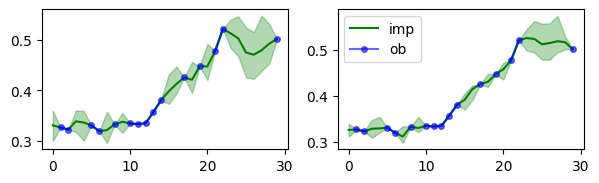

In [245]:
fig = plt.figure(figsize=(7,4))

X_missed1 = X_missed

plt.subplot(2,2,1)
plt.plot(res1_05[:,3], color = 'g', label='imp') 
plt.fill_between( range(0,30), res1_005[:,3], res1_095[:,3], color='g', alpha=0.3)  # alpha是透明程度
plt.plot(X_missed1[0][:,3].cpu().numpy(), color='b', marker='o',alpha=0.6, markersize='4',label='ob') # 观测值的蓝色把之前的值覆盖了 生成区域的值还是之前的0.5分位数的

plt.subplot(2,2,2)
plt.plot(res2_05[:,3], color = 'g', label='imp') 
plt.fill_between( range(0,30), res2_005[:,3], res2_095[:,3], color='g', alpha=0.3)  
plt.plot(X_missed1[0][:,3].cpu().numpy(), color='b', marker='o',alpha=0.6, markersize='4',label='ob')


# X_missed2 = X_missed

# plt.subplot(2,2,3)
# plt.plot(res3_05[:,3], color = 'g', label='imp') 
# plt.fill_between( range(0,30), res3_005[:,3], res3_095[:,3], color='g', alpha=0.3)  
# plt.plot(X_missed2[0][:,3].cpu().numpy(), color='b', marker='o',alpha=0.6, markersize='4',label='ob')


# plt.subplot(2,2,4)
# plt.plot(res4_05[:,3], color = 'g', label='imp') 
# plt.fill_between( range(0,30), res4_005[:,3], res4_095[:,3], color='g', alpha=0.3)  
# plt.plot(X_missed2[0][:,3].cpu().numpy(), color='b', marker='o',alpha=0.6, markersize='4',label='ob')

plt.legend()

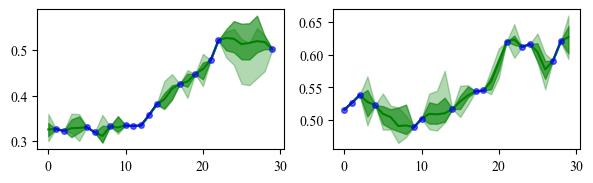

In [255]:
fig = plt.figure(figsize=(7,4))

plt.subplot(2,2,1)

X_missed1 = X_missed

plt.plot(res2_05[:,3], color = 'g') 

plt.fill_between( range(0,30), res1_005[:,3], res1_095[:,3], color='g', alpha=0.3, label = 'SAITS')  # alpha是透明程度

plt.fill_between( range(0,30), res2_005[:,3], res2_095[:,3], color='g', alpha=0.6, label = 'ours')  

plt.plot(X_missed1[0][:,3].cpu().numpy(), color='b', marker='o',alpha=0.6, markersize='4')

plt.xticks(fontproperties = 'Times New Roman')
plt.yticks(fontproperties = 'Times New Roman')



plt.subplot(2,2,2)

# X_missed2 = X_missed

plt.plot(res4_05[:,3], color = 'g') 

plt.fill_between( range(0,30), res3_005[:,3], res3_095[:,3], color='g', alpha=0.3)  

plt.fill_between( range(0,30), res4_005[:,3], res4_095[:,3], color='g', alpha=0.6)  


plt.plot(X_missed2[0][:,3].cpu().numpy(), color='b', marker='o',alpha=0.6, markersize='4')



plt.xticks(fontproperties = 'Times New Roman')
plt.yticks(fontproperties = 'Times New Roman')

# plt.legend()

plt.savefig('./sp500_分位数.pdf')